In [57]:
import pandas as pd
station_precip = pd.read_csv('D:/Desktop/mentor_research/clean/LSTM/lstm_result_with_lonlat/cali_precipitation.csv', index_col=0, parse_dates=True)

import numpy as np
import xarray as xr
modis001 = xr.open_dataset("D:/Desktop/mentor_research/data_modis/nyc_modis_data_2015_present.nc")
modis001 = modis001.sel(time=modis001.time < np.datetime64("2024-12-01"))
modis001
precip001 = xr.open_dataset("D:/Desktop/mentor_research/data_imerg/nyc_precipitation_data_2015_to_present.nc")
precip001
combined001 = xr.merge([modis001, precip001])
combined001
# 1. 将 precipitation < 0 的值设为 NaN
combined001["precipitation"] = combined001["precipitation"].where(combined001["precipitation"] >= 0)

# 2. 删除变量 snow_cover（如果存在）
if "snow_cover" in combined001.data_vars:
    combined001 = combined001.drop_vars("snow_cover")

# 可选：查看结果
print(combined001)

combined005 = combined001.coarsen(lat=5, lon=5, boundary="trim").mean()
combined005

<xarray.Dataset>
Dimensions:              (time: 119, lat: 50, lon: 100)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * lat                  (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
Data variables:
    surface_temperature  (time, lat, lon) float32 ...
    vegetation_index     (time, lat, lon) float32 ...
    evapotranspiration   (time, lat, lon) float32 ...
    dem                  (time, lat, lon) float32 ...
    burned_area          (time, lat, lon) float32 ...
    precipitation        (time, lat, lon) float32 nan 0.0 0.0 ... 0.01102 0.0
Attributes:
    title:                NASA MODIS Data for New York City (2015-Present)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-20
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly avera

<xarray.Dataset>
Dimensions:              (time: 119, lat: 10, lon: 20)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.08 -74.03 -73.98 ... -73.17 -73.12
  * lat                  (lat) float32 40.42 40.47 40.52 ... 40.78 40.83 40.88
Data variables:
    surface_temperature  (time, lat, lon) float32 67.77 75.86 73.39 ... 0.0 0.0
    vegetation_index     (time, lat, lon) float32 0.1851 0.1869 ... -0.3 -0.3
    evapotranspiration   (time, lat, lon) float32 394.5 394.6 ... 3.277e+03
    dem                  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    burned_area          (time, lat, lon) float32 -0.12 -0.12 ... -2.0 -2.0
    precipitation        (time, lat, lon) float32 0.0009419 0.05037 ... 0.005709
Attributes:
    title:                NASA MODIS Data for New York City (2015-Present)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-20
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

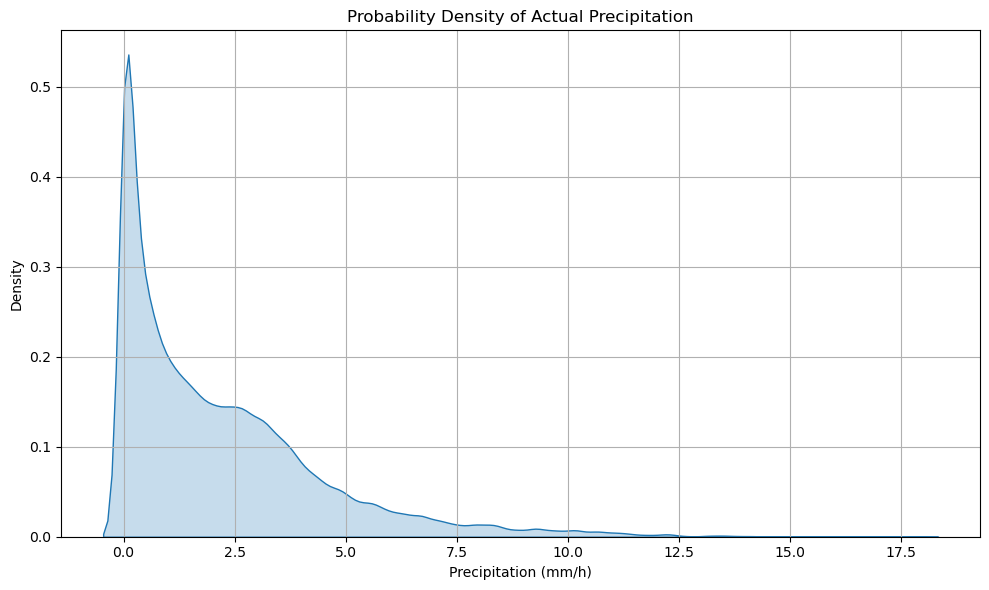

In [58]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# 提取降水量数据并转换为1D向量
actual_precip = combined005['precipitation'].values.flatten()

# 过滤掉NaN和负值（如有）
actual_precip = actual_precip[~np.isnan(actual_precip)]
actual_precip = actual_precip[actual_precip >= 0]

# 可视化概率密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(actual_precip, bw_adjust=0.5, fill=True)
plt.title("Probability Density of Actual Precipitation")
plt.xlabel("Precipitation (mm/h)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

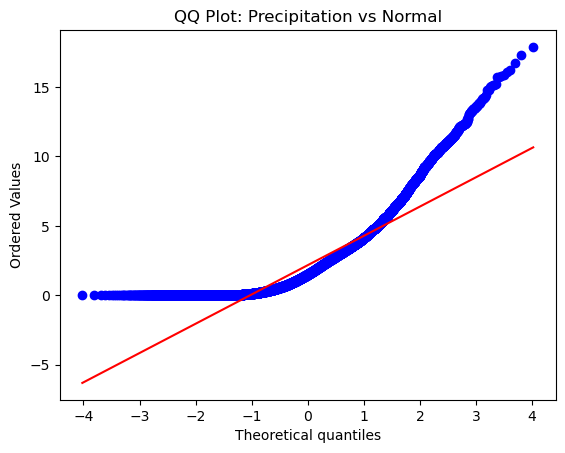

In [59]:
from scipy import stats
import matplotlib.pyplot as plt

stats.probplot(actual_precip, dist="norm", plot=plt)
plt.title("QQ Plot: Precipitation vs Normal")
plt.show()


In [2]:
station_precip.head()

time      lat      lon  cali_precipitation
0  2015-01-01  40.6386 -73.7622            1.226127
1  2015-01-01  40.6825 -74.1694            1.020618
2  2015-02-01  40.6386 -73.7622            0.746125
3  2015-02-01  40.6825 -74.1694            0.654050
4  2015-03-01  40.6386 -73.7622            0.826347

In [3]:
station_precip.head()
#选取2023/1/1
station_precip_202311 = station_precip[station_precip['time']=='2023-01-01']
station_precip_202311

time      lat      lon  cali_precipitation
258  2023-01-01  40.6386 -73.7622            0.709386
259  2023-01-01  40.6825 -74.1694            0.781957
260  2023-01-01  40.7769 -73.8740            0.789093

# VAE： latent space Gaussian

## Using a VAE for Precipitation Downscaling Pipeline
Data Preparation and Split

Data Extraction: I extracted the precipitation data from both your high-resolution (0.01°) and low-resolution (0.05°) datasets.
Train/Test Split: I used a temporal split rather than random sampling to maintain the time series integrity:

First 95 months (approximately 80%) for training
Remaining 24 months for testing


Data Preprocessing:

Replaced NaN values with zeros
Scaled the data to [0,1] range using MinMaxScaler
Reshaped the data to the format required by the model [samples, height, width, channels]



VAE Model Architecture
The VAE consists of three main components:

Encoder:

Takes low-resolution precipitation maps (10×20) as input
Uses convolutional layers to extract spatial features
Maps to a 128-dimensional latent space
Produces mean and log variance parameters for the latent distribution


Latent Space Sampling:

Implements the reparameterization trick to sample from the learned distribution
Enables backpropagation through the random sampling process


Decoder:

Takes samples from the latent space
Uses transposed convolutions for feature maps
Includes a 5× upsampling layer to increase resolution from 10×20 to 50×100
Outputs high-resolution precipitation maps (50×100)



Training Process
The VAE was trained with:

Custom loss function combining:

MSE reconstruction loss (comparing predicted vs. actual high-res data)
KL divergence loss (regularization term)
Beta parameter (0.1) to balance the two loss components


Adam optimizer with learning rate of 0.001
Early stopping to prevent overfitting
Checkpoint saving to retain the best model

Evaluation and Results
The model was evaluated using:

Statistical metrics:

Mean Squared Error (MSE)
Mean Absolute Error (MAE)
Correlation coefficient between predicted and actual values


Visualization:

Side-by-side comparisons of low-res input, VAE output, and high-res ground truth
Training loss curves
Spatial error distribution map

## VAE: only precipitation as input

In [35]:
import numpy as np
import xarray as xr

# 加载低分辨率和高分辨率降水数据
precip_low = combined005["precipitation"].values  # shape (119, 50, 100)
precip_high = combined001["precipitation"].values  # shape (119, 250, 500)

# 将NaN替换为0
precip_low = np.nan_to_num(precip_low, nan=0.0)
precip_high = np.nan_to_num(precip_high, nan=0.0)

# 归一化数据
max_precip = np.max([precip_low.max(), precip_high.max()])
precip_low = precip_low / max_precip
precip_high = precip_high / max_precip

# 添加通道维度
precip_low = precip_low[..., np.newaxis]  # shape (119, 50, 100, 1)
precip_high = precip_high[..., np.newaxis]  # shape (119, 250, 500, 1)

#划分训练集和测试集
split_time = int(119 * 0.8)  # 按时间顺序划分
X_train, Y_train = precip_low[:split_time], precip_high[:split_time]
X_test, Y_test = precip_low[split_time:], precip_high[split_time:]


import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# 编码器（适配输入形状 (10, 20, 1)）
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_layers = [
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')
        ]
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = inputs
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)
        return self.dense_mean(x), self.dense_log_var(x)

# 解码器（适配输出形状 (50, 100, 1)）
class Decoder(layers.Layer):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(5*10*256, activation='relu')
        self.reshape = layers.Reshape((5, 10, 256))
        self.convT_layers = [
            layers.Conv2DTranspose(128, 3, strides=5, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu'),
        ]
        self.final_conv = layers.Conv2D(1, 3, padding='same', activation='sigmoid')

    def call(self, z):
        x = self.dense(z)
        x = self.reshape(x)
        for layer in self.convT_layers:
            x = layer(x)
        return self.final_conv(x)

# VAE模型
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling(z_mean, z_log_var)
        return self.decoder(z)

    def sampling(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(inputs)
            z = self.sampling(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            
            mask = tf.cast(tf.math.is_finite(targets), tf.float32)
            reconstruction_loss = tf.reduce_mean(
                tf.square((targets - reconstruction) * mask))
            
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# 初始化模型
latent_dim = 32  # 根据实际需求调整
encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=None, run_eagerly=True)

# 数据验证
print("X_train shape:", X_train.shape)  # 应输出 (95, 10, 20, 1)
print("Y_train shape:", Y_train.shape)  # 应输出 (95, 50, 100, 1)

# 单样本测试
test_input = tf.random.normal((1, 10, 20, 1))
test_output = vae(test_input)
print("模型输出形状:", test_output.shape)  # 应输出 (1, 50, 100, 1)

# 训练
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)  # 小批量加速训练
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16)

history = vae.fit(train_dataset, epochs=100, validation_data=test_dataset)

X_train shape: (95, 10, 20, 1)
Y_train shape: (95, 50, 100, 1)
模型输出形状: (1, 50, 100, 1)
Epoch 1/100
6/6 [==============================] - 1s 207ms/step - loss: 0.2163 - reconstruction_loss: 0.2161 - kl_loss: 5.0678e-06 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 1s 201ms/step - loss: 0.2144 - reconstruction_loss: 0.2142 - kl_loss: 1.5467e-06 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 1s 202ms/step - loss: 0.2119 - reconstruction_loss: 0.2115 - kl_loss: 1.0752e-06 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 1s 200ms/step - loss: 0.2083 - reconstruction_loss: 0.2077 - kl_loss: 1.3683e-06 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/100
6

In [9]:
print("X_train shape:", X_train.shape)  # 应输出 (N, 50, 100, 1)
print("Y_train shape:", Y_train.shape)  # 应输出 (N, 250, 500, 1)

X_train shape: (95, 10, 20, 1)
Y_train shape: (95, 50, 100, 1)


In [11]:
# 预测测试集
preds = vae.predict(X_test)

# 反归一化
preds_actual = preds.squeeze() * max_precip
y_test_actual = Y_test.squeeze() * max_precip

# 计算评估指标
mse = np.mean((preds_actual - y_test_actual)**2)
mae = np.mean(np.abs(preds_actual - y_test_actual))
print(f"MSE: {mse}, MAE: {mae}")



# 对比双线性插值结果
from sklearn.metrics import mean_squared_error
from scipy.ndimage import zoom

bilinear_preds = zoom(X_test.squeeze(), (1, 5, 5), order=1)
bilinear_preds_actual = bilinear_preds * max_precip

y_flat = y_test_actual.reshape(y_test_actual.shape[0], -1)
bilinear_flat = bilinear_preds_actual.reshape(bilinear_preds_actual.shape[0], -1)

mse_bilinear = mean_squared_error(y_flat, bilinear_flat)
mae_bilinear = np.mean(np.abs(y_flat - bilinear_flat))

print(f"Bilinear MSE: {mse_bilinear:.6f}, MAE: {mae_bilinear:.6f}")

1/1 [==============================] - 0s 86ms/step
MSE: 15.138520240783691, MAE: 2.2307963371276855
Bilinear MSE: 4.750084, MAE: 1.209404


d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


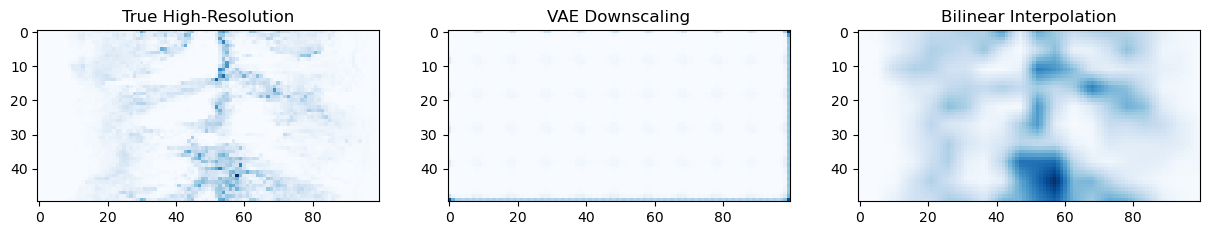

In [12]:
# 结果可视化
import matplotlib.pyplot as plt

# 随机选择一个测试样本
idx = np.random.randint(0, len(Y_test))
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y_test[idx].squeeze(), cmap='Blues')
plt.title("True High-Resolution")

plt.subplot(1, 3, 2)
plt.imshow(preds[idx].squeeze(), cmap='Blues')
plt.title("VAE Downscaling")

plt.subplot(1, 3, 3)
plt.imshow(bilinear_preds[idx], cmap='Blues')
plt.title("Bilinear Interpolation")

plt.show()

## VAE: 加入其他modis

In [ ]:
import numpy as np
import xarray as xr




# 提取并归一化所有变量
vars_to_use = ["precipitation", "surface_temperature", "vegetation_index", "evapotranspiration", "dem", "burned_area"]
data = [combined005[v].values for v in vars_to_use]
data = [np.nan_to_num(d, nan=0.0) / np.nanmax(d) for d in data]

# 堆叠为多通道：shape = (119, 50, 100, 6)
X_all = np.stack(data, axis=-1)

# 高分辨率降水仍用原来的 normalized precip_high（shape: 119, 250, 500, 1）
Y_all = precip_high[..., np.newaxis]

# 按时间划分训练集和测试集
split_time = int(119 * 0.8)
X_train, Y_train = X_all[:split_time], Y_all[:split_time]
X_test, Y_test = X_all[split_time:], Y_all[split_time:]

import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# 编码器（适配输入形状 (10, 20, 1)）
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_layers = [
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')
        ]
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = inputs
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)
        return self.dense_mean(x), self.dense_log_var(x)

# 解码器（适配输出形状 (50, 100, 1)）
class Decoder(layers.Layer):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(5*10*256, activation='relu')
        self.reshape = layers.Reshape((5, 10, 256))
        self.convT_layers = [
            layers.Conv2DTranspose(128, 3, strides=5, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu'),
        ]
        self.final_conv = layers.Conv2D(1, 3, padding='same', activation='sigmoid')

    def call(self, z):
        x = self.dense(z)
        x = self.reshape(x)
        for layer in self.convT_layers:
            x = layer(x)
        return self.final_conv(x)

# VAE模型
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling(z_mean, z_log_var)
        return self.decoder(z)

    def sampling(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(inputs)
            z = self.sampling(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            # 修复：确保 target 和 prediction 维度一致
            targets = tf.reshape(targets, tf.shape(reconstruction))
            
            mask = tf.cast(tf.math.is_finite(targets), tf.float32)
            reconstruction_loss = tf.reduce_mean(
                tf.square((targets - reconstruction) * mask)
            )

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# 初始化模型
latent_dim = 128  # 根据实际需求调整
encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=None, run_eagerly=True)

# 数据验证
print("X_train shape:", X_train.shape) 
print("Y_train shape:", Y_train.shape)  

# 单样本测试
test_input = tf.random.normal((1, 10, 20, 6))
test_output = vae(test_input)
print("模型输出形状:", test_output.shape)  # 应输出 (1, 50, 100, 1)

# 训练
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)  # 小批量加速训练
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16)

history = vae.fit(train_dataset, epochs=100, validation_data=test_dataset)# 预测测试集
preds = vae.predict(X_test)

# 反归一化
preds_actual = preds.squeeze() * max_precip
y_test_actual = Y_test.squeeze() * max_precip

# 计算评估指标
mse = np.mean((preds_actual - y_test_actual)**2)
mae = np.mean(np.abs(preds_actual - y_test_actual))
print(f"MSE: {mse}, MAE: {mae}")

X_train shape: (95, 10, 20, 6)
Y_train shape: (95, 50, 100, 1, 1)
模型输出形状: (1, 50, 100, 1)
Epoch 1/100
6/6 [==============================] - 1s 196ms/step - loss: 0.2156 - reconstruction_loss: 0.2144 - kl_loss: 7.5558e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 1s 199ms/step - loss: 0.2117 - reconstruction_loss: 0.2108 - kl_loss: 2.8156e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 1s 194ms/step - loss: 0.2065 - reconstruction_loss: 0.2054 - kl_loss: 1.1571e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 1s 213ms/step - loss: 0.1991 - reconstruction_loss: 0.1975 - kl_loss: 6.2149e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/10

Bilinear MSE: 46.233768, MAE: 4.979117


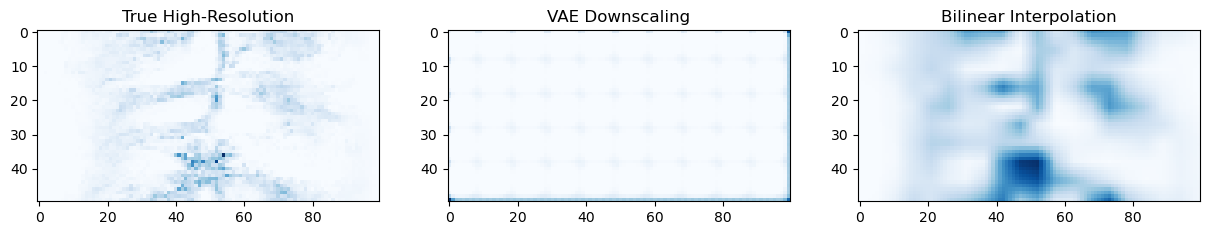

In [24]:
precip_input = X_test[..., 0]  # shape: (N, 50, 100)

# zoom along spatial axes only → (N, 250, 500)
bilinear_preds = np.stack([zoom(img, (5, 5), order=1) for img in precip_input])

# 恢复单位
bilinear_preds_actual = bilinear_preds * max_precip

# 评估
y_flat = y_test_actual.reshape(y_test_actual.shape[0], -1)
bilinear_flat = bilinear_preds_actual.reshape(bilinear_preds_actual.shape[0], -1)

from sklearn.metrics import mean_squared_error
mse_bilinear = mean_squared_error(y_flat, bilinear_flat)
mae_bilinear = np.mean(np.abs(y_flat - bilinear_flat))

print(f"Bilinear MSE: {mse_bilinear:.6f}, MAE: {mae_bilinear:.6f}")

import matplotlib.pyplot as plt

# 随机选择一个测试样本
idx = np.random.randint(0, len(Y_test))
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y_test[idx].squeeze(), cmap='Blues')
plt.title("True High-Resolution")

plt.subplot(1, 3, 2)
plt.imshow(preds[idx].squeeze(), cmap='Blues')
plt.title("VAE Downscaling")

plt.subplot(1, 3, 3)
plt.imshow(bilinear_preds[idx], cmap='Blues')
plt.title("Bilinear Interpolation")

plt.show()

# VAE: Mixture of Gaussians VAE (MoG-VAE)

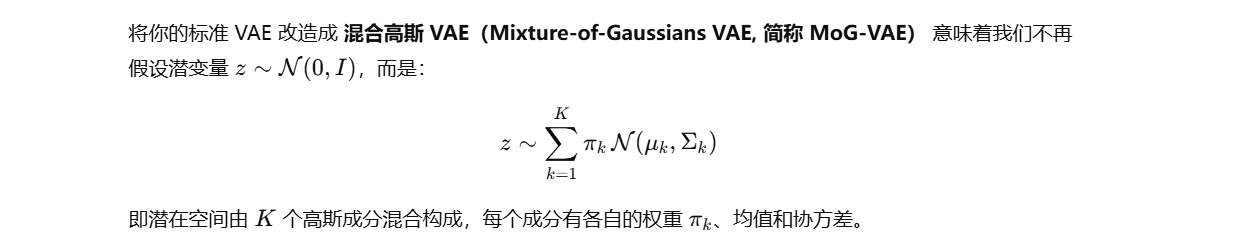

In [41]:
import numpy as np
import xarray as xr
# 加载低分辨率和高分辨率降水数据
precip_low = combined005["precipitation"].values  # shape (119, 50, 100)
precip_high = combined001["precipitation"].values  # shape (119, 250, 500)

# 将NaN替换为0
precip_low = np.nan_to_num(precip_low, nan=0.0)
precip_high = np.nan_to_num(precip_high, nan=0.0)

# 归一化数据
max_precip = np.max([precip_low.max(), precip_high.max()])
precip_low = precip_low / max_precip
precip_high = precip_high / max_precip

# 添加通道维度
precip_low = precip_low[..., np.newaxis]  # shape (119, 50, 100, 1)
precip_high = precip_high[..., np.newaxis]  # shape (119, 250, 500, 1)

# 提取并归一化所有变量
vars_to_use = ["precipitation", "surface_temperature", "vegetation_index", "evapotranspiration", "dem", "burned_area"]
data = [combined005[v].values for v in vars_to_use]
data = [np.nan_to_num(d, nan=0.0) / np.nanmax(d) for d in data]

# 堆叠为多通道：shape = (119, 50, 100, 6)
X_all = np.stack(data, axis=-1)

# 高分辨率降水仍用原来的 normalized precip_high（shape: 119, 250, 500, 1）
Y_all = precip_high[..., np.newaxis]

# 按时间划分训练集和测试集
split_time = int(119 * 0.8)
X_train, Y_train = X_all[:split_time], Y_all[:split_time]
X_test, Y_test = X_all[split_time:], Y_all[split_time:]

# Remove extra singleton dimension in Y if needed
Y_train = np.squeeze(Y_train, axis=-1) if Y_train.shape[-1] == 1 and Y_train.ndim == 5 else Y_train
Y_test = np.squeeze(Y_test, axis=-1) if Y_test.shape[-1] == 1 and Y_test.ndim == 5 else Y_test


In [42]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow as tf
tf.config.run_functions_eagerly(True)

def mog_kl_loss(z, z_mean, z_log_var, prior_means, prior_logvars, prior_logits):
    """
    z: sampled latent (B, D)
    z_mean, z_log_var: from encoder (B, D)
    prior_means, prior_logvars: (K, D)
    prior_logits: (K,)
    """

    B, D = tf.shape(z)[0], tf.shape(z)[1]
    K = tf.shape(prior_means)[0]

    # Expand: z → (B, 1, D), priors → (1, K, D)
    z_exp = tf.expand_dims(z, 1)
    means = tf.expand_dims(prior_means, 0)
    logvars = tf.expand_dims(prior_logvars, 0)
    logits = tf.expand_dims(prior_logits, 0)  # (1, K)

    log_probs = -0.5 * (
        tf.reduce_sum(np.log(2.0 * np.pi) + logvars + tf.square(z_exp - means) / tf.exp(logvars), axis=2)
    )  # shape: (B, K)

    log_mix = tf.nn.log_softmax(logits, axis=-1)
    log_joint = log_probs + log_mix  # shape: (B, K)

    log_qz = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z - z_mean) - tf.exp(z_log_var), axis=1)
    log_pz = tf.reduce_logsumexp(log_joint, axis=1)

    return tf.reduce_mean(log_qz - log_pz)







# 编码器（适配输入形状 (10, 20, 1)）
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_layers = [
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')
        ]
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = inputs
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)
        return self.dense_mean(x), self.dense_log_var(x)

# 解码器（适配输出形状 (50, 100, 1)）
class Decoder(layers.Layer):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(5*10*256, activation='relu')
        self.reshape = layers.Reshape((5, 10, 256))
        self.convT_layers = [
            layers.Conv2DTranspose(128, 3, strides=5, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu'),
        ]
        self.final_conv = layers.Conv2D(1, 3, padding='same', activation='sigmoid')

    def call(self, z):
        x = self.dense(z)
        x = self.reshape(x)
        for layer in self.convT_layers:
            x = layer(x)
        x = self.final_conv(x)
        return tf.squeeze(x, axis=-1) if x.shape[-1] == 1 and len(x.shape) == 5 else x


# VAE模型
class MoGVAE(Model):
    def __init__(self, encoder, decoder, num_components=5, latent_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.K = num_components
        self.latent_dim = latent_dim

        # 🧩 添加这些指标 tracker
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        # 🧠 MoG 先验参数
        self.prior_means = self.add_weight(shape=(self.K, latent_dim),
                                           initializer='random_normal', trainable=True)
        self.prior_logvars = self.add_weight(shape=(self.K, latent_dim),
                                             initializer='zeros', trainable=True)
        self.prior_logits = self.add_weight(shape=(self.K,),
                                            initializer='zeros', trainable=True)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def sampling(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling(z_mean, z_log_var)
        return self.decoder(z)

    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(inputs)
            z = self.sampling(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            # 修复：确保 target 和 prediction 维度一致
            targets = tf.reshape(targets, tf.shape(reconstruction))
            
            mask = tf.cast(tf.math.is_finite(targets), tf.float32)
            reconstruction_loss = tf.reduce_mean(
                tf.square((targets - reconstruction) * mask)
            )

            kl_loss = mog_kl_loss(z, z_mean, z_log_var, self.prior_means, self.prior_logvars, self.prior_logits)


            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# 初始化模型
latent_dim = 128  # 根据实际需求调整
encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=None, run_eagerly=True)

# 数据验证
print("X_train shape:", X_train.shape) 
print("Y_train shape:", Y_train.shape)  

# 单样本测试
test_input = tf.random.normal((1, 10, 20, 6))
test_output = vae(test_input)
print("模型输出形状:", test_output.shape)  # 应输出 (1, 50, 100, 1)

# 训练
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)  # 小批量加速训练
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16)

history = vae.fit(train_dataset, epochs=100, validation_data=test_dataset)# 预测测试集
preds = vae.predict(X_test)

# 反归一化
preds_actual = preds.squeeze() * max_precip
y_test_actual = Y_test.squeeze() * max_precip

# 计算评估指标
mse = np.mean((preds_actual - y_test_actual)**2)
mae = np.mean(np.abs(preds_actual - y_test_actual))
print(f"MSE: {mse}, MAE: {mae}")

X_train shape: (95, 10, 20, 6)
Y_train shape: (95, 50, 100, 1)
模型输出形状: (1, 50, 100, 1)
Epoch 1/100
6/6 [==============================] - 1s 236ms/step - loss: 0.2181 - reconstruction_loss: 0.2170 - kl_loss: 8.1727e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 1s 213ms/step - loss: 0.2156 - reconstruction_loss: 0.2151 - kl_loss: 3.1937e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 1s 222ms/step - loss: 0.2134 - reconstruction_loss: 0.2131 - kl_loss: 1.2953e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 1s 219ms/step - loss: 0.2108 - reconstruction_loss: 0.2103 - kl_loss: 6.3651e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/100
6

d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


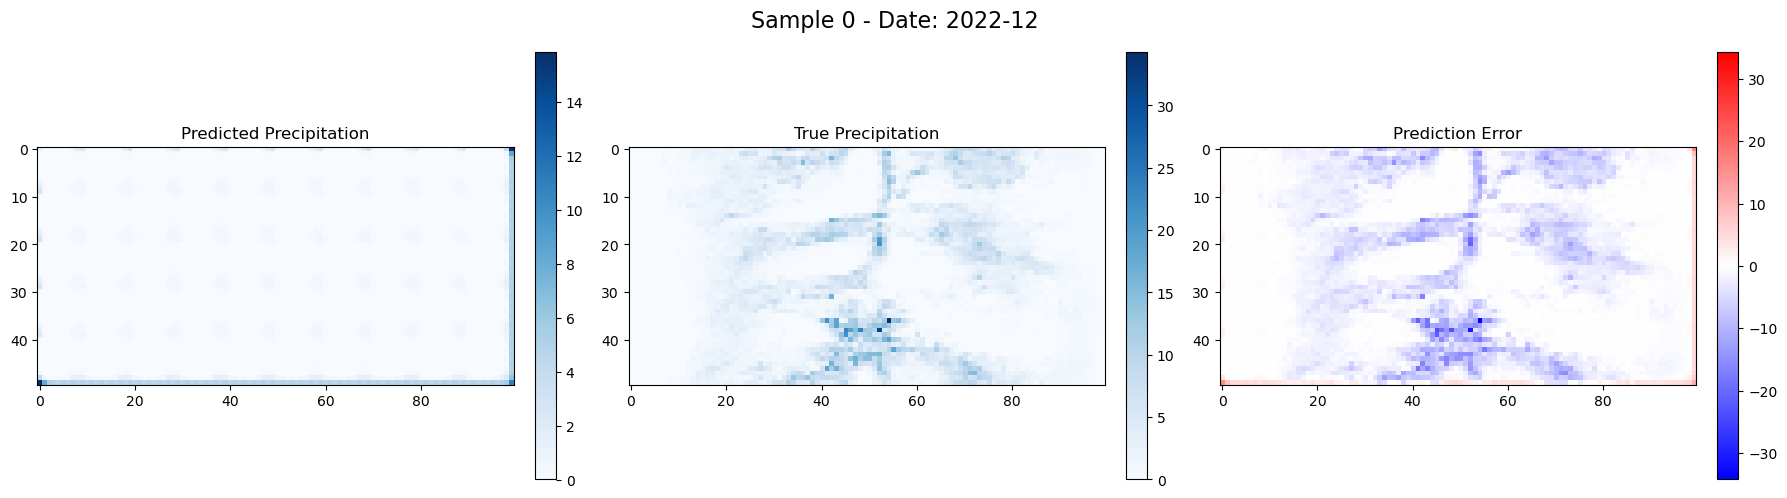

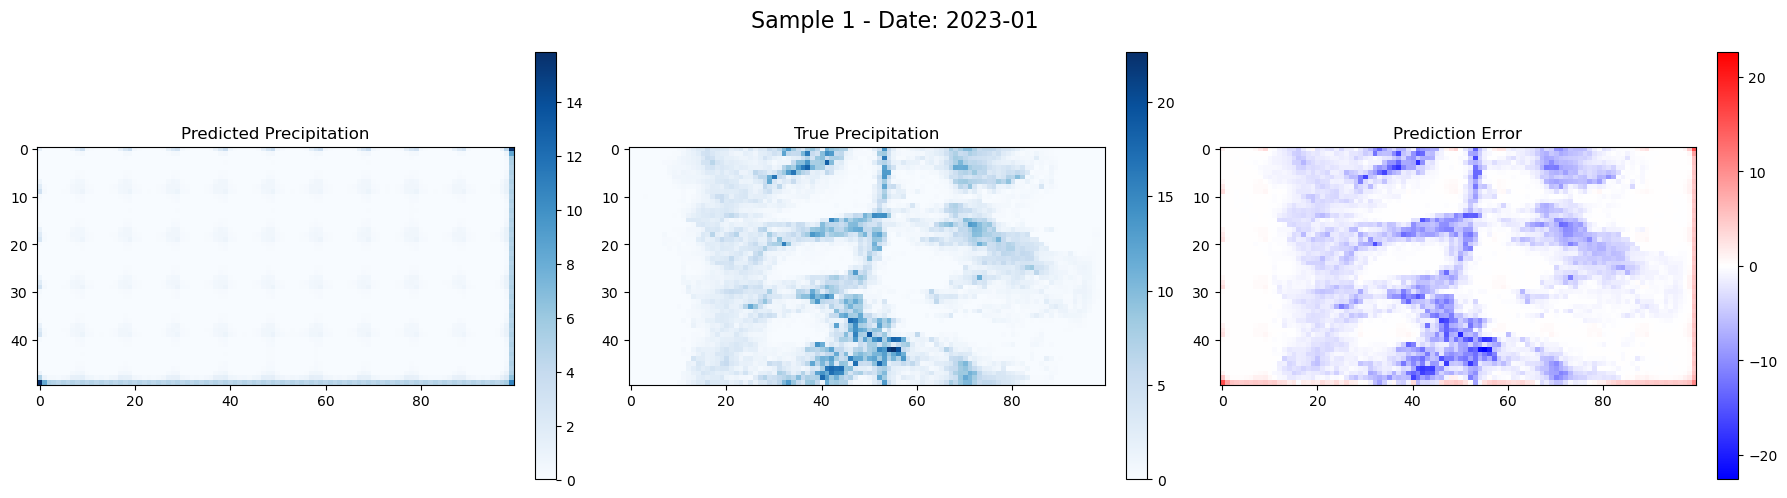

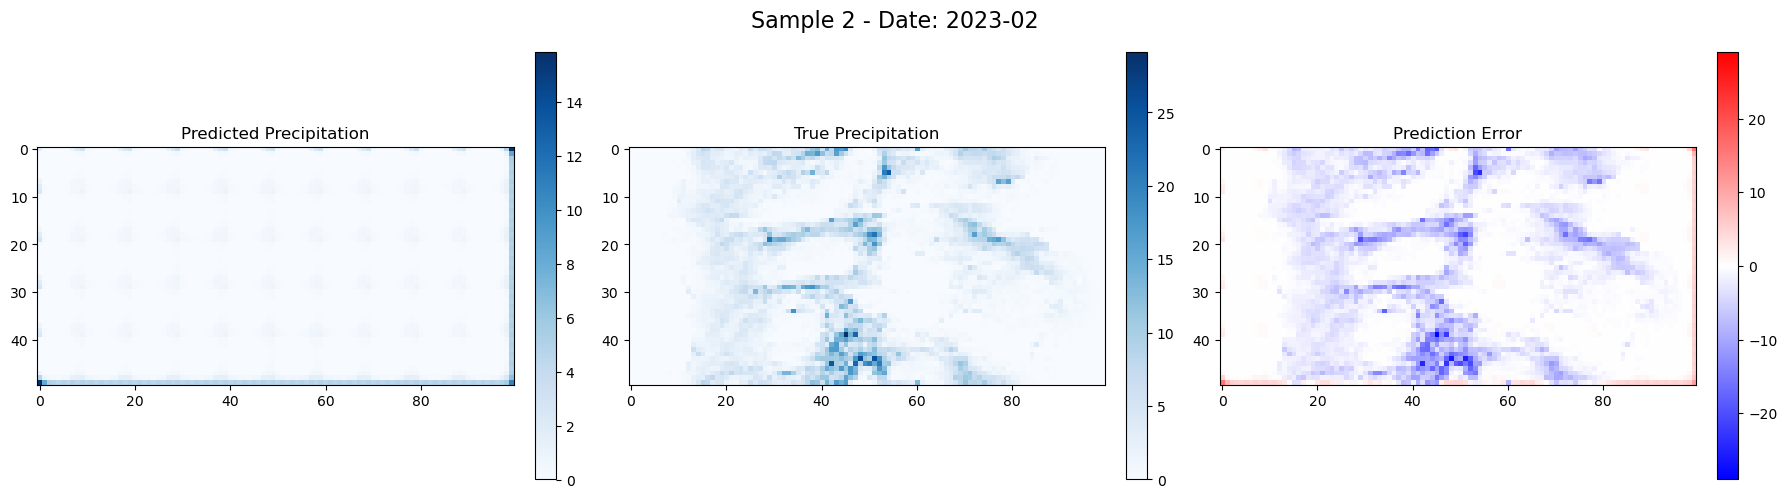

In [45]:
import matplotlib.pyplot as plt

def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array, split_time):
    """
    绘制 index 号样本的预测值 vs. 真实值 vs. 误差图，并标注对应时间
    参数：
        index: 第几个测试样本
        preds_actual: (N, 50, 100) 模型预测结果
        y_test_actual: (N, 50, 100) 实际观测
        time_array: xarray 中的 combined005.time.values
        split_time: 训练集长度（测试集的起始索引）
    """
    pred = preds_actual[index]
    truth = y_test_actual[index]
    error = pred - truth

    # 获取时间戳字符串
    time_str = np.datetime_as_string(time_array[split_time + index], unit='M')

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].imshow(pred, cmap='Blues')
    axes[0].set_title("Predicted Precipitation")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(truth, cmap='Blues')
    axes[1].set_title("True Precipitation")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(error, cmap='bwr', vmin=-np.max(np.abs(error)), vmax=np.max(np.abs(error)))
    axes[2].set_title("Prediction Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Sample {index} - Date: {time_str}", fontsize=16)
    plt.tight_layout()
    plt.show()


# 示例：绘制前3个样本并标注时间
for i in range(3):
    plot_prediction_comparison(i, preds_actual, y_test_actual, combined005.time.values, split_time)


# VAE: light tail	Student-t VAE / Laplace VAE	

## Laplace VAE

In [46]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow as tf
tf.config.run_functions_eagerly(True)

def mog_kl_loss(z, z_mean, z_log_var, prior_means, prior_logvars, prior_logits):
    """
    z: sampled latent (B, D)
    z_mean, z_log_var: from encoder (B, D)
    prior_means, prior_logvars: (K, D)
    prior_logits: (K,)
    """

    B, D = tf.shape(z)[0], tf.shape(z)[1]
    K = tf.shape(prior_means)[0]

    # Expand: z → (B, 1, D), priors → (1, K, D)
    z_exp = tf.expand_dims(z, 1)
    means = tf.expand_dims(prior_means, 0)
    logvars = tf.expand_dims(prior_logvars, 0)
    logits = tf.expand_dims(prior_logits, 0)  # (1, K)

    log_probs = -0.5 * (
        tf.reduce_sum(np.log(2.0 * np.pi) + logvars + tf.square(z_exp - means) / tf.exp(logvars), axis=2)
    )  # shape: (B, K)

    log_mix = tf.nn.log_softmax(logits, axis=-1)
    log_joint = log_probs + log_mix  # shape: (B, K)

    log_qz = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z - z_mean) - tf.exp(z_log_var), axis=1)
    log_pz = tf.reduce_logsumexp(log_joint, axis=1)

    return tf.reduce_mean(log_qz - log_pz)







# 编码器（适配输入形状 (10, 20, 1)）
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv_layers = [
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')
        ]
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = inputs
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)
        return self.dense_mean(x), self.dense_log_var(x)

# 解码器（适配输出形状 (50, 100, 1)）
class Decoder(layers.Layer):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(5*10*256, activation='relu')
        self.reshape = layers.Reshape((5, 10, 256))
        self.convT_layers = [
            layers.Conv2DTranspose(128, 3, strides=5, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu'),
        ]
        self.final_conv = layers.Conv2D(1, 3, padding='same', activation='sigmoid')

    def call(self, z):
        x = self.dense(z)
        x = self.reshape(x)
        for layer in self.convT_layers:
            x = layer(x)
        x = self.final_conv(x)
        return tf.squeeze(x, axis=-1) if x.shape[-1] == 1 and len(x.shape) == 5 else x


# VAE模型
class MoGVAE(Model):
    def __init__(self, encoder, decoder, num_components=5, latent_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.K = num_components
        self.latent_dim = latent_dim

        # 🧩 添加这些指标 tracker
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        # 🧠 MoG 先验参数
        self.prior_means = self.add_weight(shape=(self.K, latent_dim),
                                           initializer='random_normal', trainable=True)
        self.prior_logvars = self.add_weight(shape=(self.K, latent_dim),
                                             initializer='zeros', trainable=True)
        self.prior_logits = self.add_weight(shape=(self.K,),
                                            initializer='zeros', trainable=True)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def sampling(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling(z_mean, z_log_var)
        return self.decoder(z)

    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(inputs)
            z = self.sampling(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            # 修复：确保 target 和 prediction 维度一致
            targets = tf.reshape(targets, tf.shape(reconstruction))
            
            mask = tf.cast(tf.math.is_finite(targets), tf.float32)
            reconstruction_loss = tf.reduce_mean(
                tf.abs((targets - reconstruction) * mask)
            )

            kl_loss = mog_kl_loss(z, z_mean, z_log_var, self.prior_means, self.prior_logvars, self.prior_logits)


            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# 初始化模型
latent_dim = 128  # 根据实际需求调整
encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=None, run_eagerly=True)

# 数据验证
print("X_train shape:", X_train.shape) 
print("Y_train shape:", Y_train.shape)  

# 单样本测试
test_input = tf.random.normal((1, 10, 20, 6))
test_output = vae(test_input)
print("模型输出形状:", test_output.shape)  # 应输出 (1, 50, 100, 1)

# 训练
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)  # 小批量加速训练
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16)

history = vae.fit(train_dataset, epochs=100, validation_data=test_dataset)# 预测测试集
preds = vae.predict(X_test)

# 反归一化
preds_actual = preds.squeeze() * max_precip
y_test_actual = Y_test.squeeze() * max_precip

# 计算评估指标
mse = np.mean((preds_actual - y_test_actual)**2)
mae = np.mean(np.abs(preds_actual - y_test_actual))
print(f"MSE: {mse}, MAE: {mae}")

X_train shape: (95, 10, 20, 6)
Y_train shape: (95, 50, 100, 1)
模型输出形状: (1, 50, 100, 1)
Epoch 1/100
6/6 [==============================] - 1s 204ms/step - loss: 0.2169 - reconstruction_loss: 0.2158 - kl_loss: 7.2567e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 1s 205ms/step - loss: 0.2135 - reconstruction_loss: 0.2129 - kl_loss: 2.6221e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 1s 209ms/step - loss: 0.2097 - reconstruction_loss: 0.2089 - kl_loss: 1.0462e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 1s 211ms/step - loss: 0.2044 - reconstruction_loss: 0.2033 - kl_loss: 5.5672e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/100
6

d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


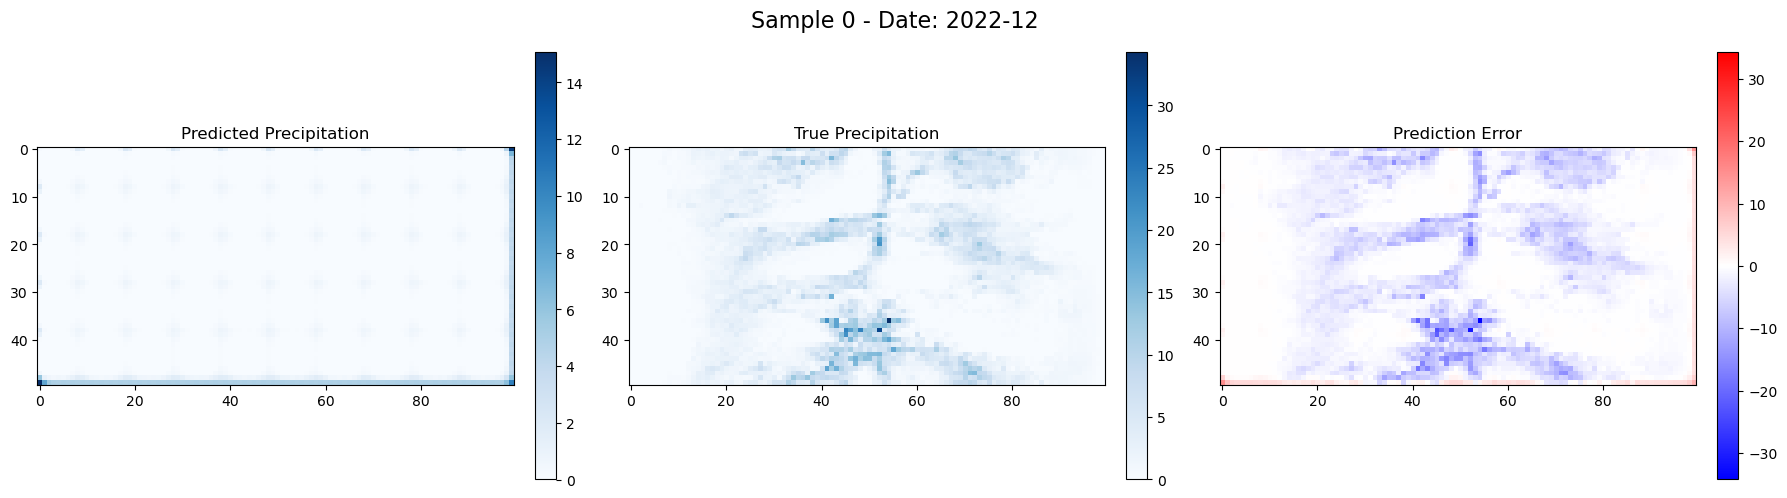

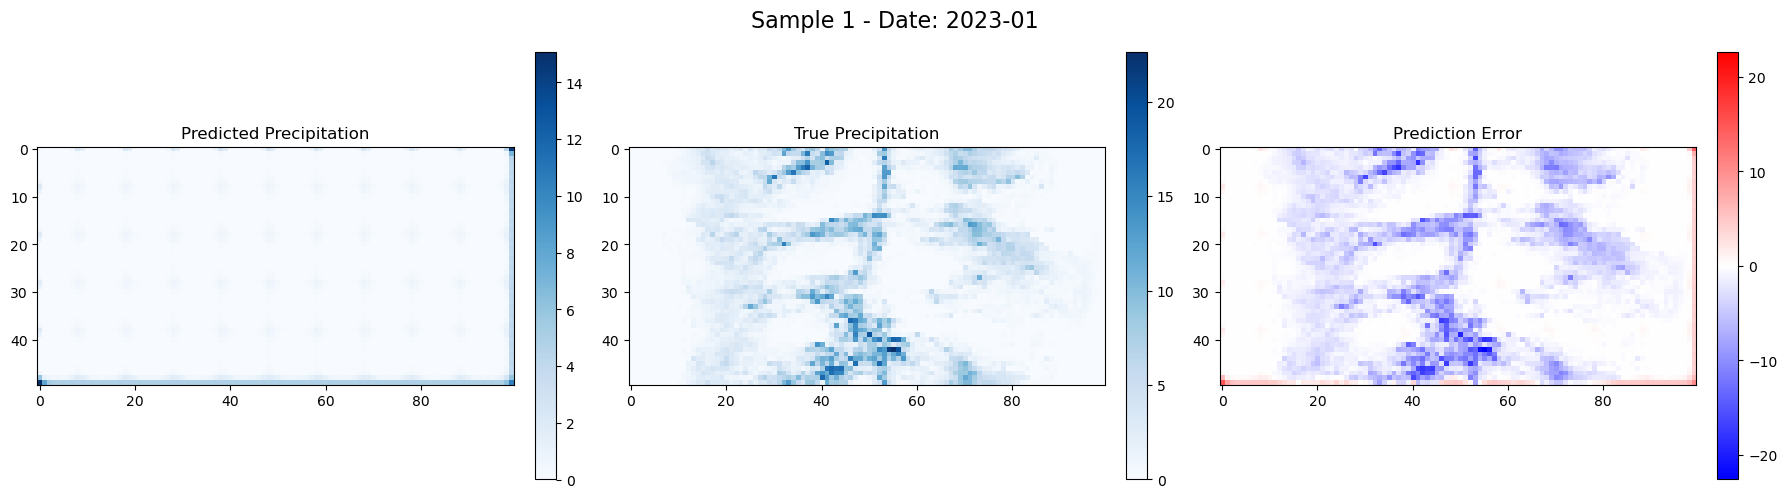

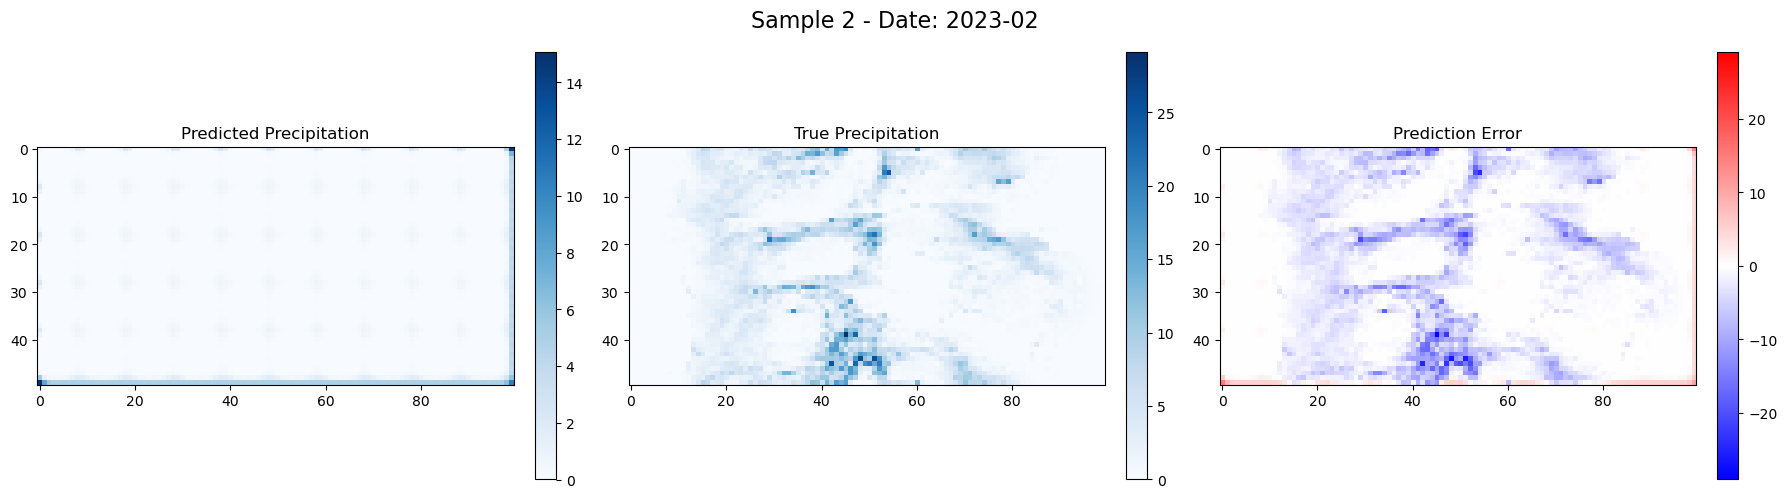

In [47]:
import matplotlib.pyplot as plt

def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array, split_time):
    """
    绘制 index 号样本的预测值 vs. 真实值 vs. 误差图，并标注对应时间
    参数：
        index: 第几个测试样本
        preds_actual: (N, 50, 100) 模型预测结果
        y_test_actual: (N, 50, 100) 实际观测
        time_array: xarray 中的 combined005.time.values
        split_time: 训练集长度（测试集的起始索引）
    """
    pred = preds_actual[index]
    truth = y_test_actual[index]
    error = pred - truth

    # 获取时间戳字符串
    time_str = np.datetime_as_string(time_array[split_time + index], unit='M')

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].imshow(pred, cmap='Blues')
    axes[0].set_title("Predicted Precipitation")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(truth, cmap='Blues')
    axes[1].set_title("True Precipitation")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(error, cmap='bwr', vmin=-np.max(np.abs(error)), vmax=np.max(np.abs(error)))
    axes[2].set_title("Prediction Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Sample {index} - Date: {time_str}", fontsize=16)
    plt.tight_layout()
    plt.show()


# 示例：绘制前3个样本并标注时间
for i in range(3):
    plot_prediction_comparison(i, preds_actual, y_test_actual, combined005.time.values, split_time)


# xVAE: contain modis

In [3]:
import numpy as np
import xarray as xr
# 加载低分辨率和高分辨率降水数据
precip_low = combined005["precipitation"].values  # shape (119, 50, 100)
precip_high = combined001["precipitation"].values  # shape (119, 250, 500)

# 将NaN替换为0
precip_low = np.nan_to_num(precip_low, nan=0.0)
precip_high = np.nan_to_num(precip_high, nan=0.0)

# 归一化数据
max_precip = np.max([precip_low.max(), precip_high.max()])
precip_low = precip_low / max_precip
precip_high = precip_high / max_precip

# 添加通道维度
precip_low = precip_low[..., np.newaxis]  # shape (119, 50, 100, 1)
precip_high = precip_high[..., np.newaxis]  # shape (119, 250, 500, 1)

# 提取并归一化所有变量
vars_to_use = ["precipitation", "surface_temperature", "vegetation_index", "evapotranspiration", "dem", "burned_area"]
data = [combined005[v].values for v in vars_to_use]
data = [np.nan_to_num(d, nan=0.0) / np.nanmax(d) for d in data]

# 堆叠为多通道：shape = (119, 50, 100, 6)
X_all = np.stack(data, axis=-1)

# 高分辨率降水仍用原来的 normalized precip_high（shape: 119, 250, 500, 1）
Y_all = precip_high[..., np.newaxis]

# 按时间划分训练集和测试集
split_time = int(119 * 0.8)
X_train, Y_train = X_all[:split_time], Y_all[:split_time]
X_test, Y_test = X_all[split_time:], Y_all[split_time:]

# Remove extra singleton dimension in Y if needed
Y_train = np.squeeze(Y_train, axis=-1) if Y_train.shape[-1] == 1 and Y_train.ndim == 5 else Y_train
Y_test = np.squeeze(Y_test, axis=-1) if Y_test.shape[-1] == 1 and Y_test.ndim == 5 else Y_test


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder_net = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim * 2)  # 输出 mu 和 log_zeta
        ])

    def call(self, x):
        h = self.encoder_net(x)
        mu, log_zeta = tf.split(h, num_or_size_splits=2, axis=1)
        return mu, log_zeta

def sample_exp_ps(mu, log_zeta, alpha=0.5):
    eps = tf.random.gamma(shape=tf.shape(mu), alpha=tf.constant(alpha, dtype=tf.float32))  # gamma 分布
    eps = tf.clip_by_value(eps, 1e-4, 1e4)  # 避免过小或过大
    sigma = tf.exp(0.5 * log_zeta)
    z = mu + sigma * tf.pow(eps, -1.0 / alpha)
    return z


class MaxIDDecoder(tf.keras.Model):
    def __init__(self, omega, alpha0, tau, target_shape):  # 改名这里
        super().__init__()
        self.omega = tf.constant(omega, dtype=tf.float32)  # shape: (K, H*W)
        self.alpha0 = alpha0
        self.tau = tau
        self.target_shape = target_shape  # 这里改掉！

    def call(self, z):
        raw = tf.matmul(z, self.omega)  # shape: (B, D)
        raw = tf.nn.softplus(raw) + 1e-6  # 保证正值输入
        Y = tf.pow(raw, self.alpha0)
        epsilon = tf.random.gamma(shape=tf.shape(Y), alpha=self.alpha0)
        x_rec = Y * epsilon * self.tau
        return tf.reshape(x_rec, (-1,) + self.target_shape)



class xVAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        x, y = data  # ✅ 正确：解包为 input 和 target
        with tf.GradientTape() as tape:
            mu, log_zeta = self.encoder(x)
            z = sample_exp_ps(mu, log_zeta, alpha=0.5)
            x_rec = self.decoder(z)

            # 确保 target 和预测值维度一致（如 reshape 或 squeeze）
            y = tf.reshape(y, tf.shape(x_rec))
            nll = tf.reduce_mean(tf.square(y - x_rec))  # 重建误差
            kl = tf.reduce_mean(0.5 * tf.square(z))     # KL 近似项

            loss = nll + kl

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss, "nll": nll, "kl": kl}


from sklearn.decomposition import NMF



In [ ]:
# 假设 Y_train: (95, 50, 100)
Y_train = np.squeeze(Y_train)  # remove channel dim if needed → (95, 50, 100)
y_mean = Y_train.mean()
y_std = Y_train.std()
Y_train_scaled = (Y_train - y_mean) / y_std

# 保证非负
Y_train_nonneg = Y_train - np.min(Y_train)

# reshape 为 (N_samples, H*W) = (95, 5000)
Y_flat = Y_train_nonneg.reshape((Y_train_nonneg.shape[0], -1))  # shape: (95, 5000)

# 执行 NMF
K = 50
nmf = NMF(n_components=K, init='random', random_state=0, max_iter=500)
Z_nmf = nmf.fit_transform(Y_flat)
omega = nmf.components_  # shape: (50, 5000)

# decoder 用到的就是 omega: shape (K, H*W)


d:\anaconda\envs\dxtorch\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [87]:
print("X min:", np.min(X_train))
print("X max:", np.max(X_train))
print("Any NaNs:", np.isnan(X_train).any())
print("Any Infs:", np.isinf(X_train).any())


X min: 0.0
X max: 1.0
Any NaNs: False
Any Infs: False


In [83]:
# X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())  # 到 [0, 1]

K = 50  # 保持一致！
encoder = Encoder(latent_dim=K)
decoder = MaxIDDecoder(omega=omega, alpha0=0.8, tau=1.0, target_shape=(50, 100))
model = xVAE(encoder, decoder)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(X_train, Y_train, epochs=100, batch_size=16)


Epoch 1/100
4/6 [===================>..........] - ETA: 0s - loss: 56217513754624.0000 - nll: 59282351616.0000 - kl: 56158231461888.0000

d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 [==============================] - 0s 26ms/step - loss: 56199651262464.0000 - nll: 58644189476.5714 - kl: 56141006503936.0000
Epoch 2/100
6/6 [==============================] - 0s 22ms/step - loss: 58343000525092.5703 - nll: 60935973888.0000 - kl: 58282065077394.2891
Epoch 3/100
6/6 [==============================] - 0s 22ms/step - loss: 63195346482907.4297 - nll: 67213621833.1429 - kl: 63128133360493.7109
Epoch 4/100
6/6 [==============================] - 0s 22ms/step - loss: 57610304150381.7109 - nll: 91416481792.0000 - kl: 57518886897956.5703
Epoch 5/100
6/6 [==============================] - 0s 22ms/step - loss: 54520969166848.0000 - nll: 69296472649.1429 - kl: 54451672673718.8594
Epoch 6/100
6/6 [==============================] - 0s 23ms/step - loss: 73438622384128.0000 - nll: 90844718226.2857 - kl: 73347776755419.4219
Epoch 7/100
6/6 [==============================] - 0s 27ms/step - loss: 68195486531584.0000 - nll: 72648417280.0000 - kl: 68122837591186.2891
Epoch 8/100
6/6 [=

Epoch 1/50


d:\anaconda\envs\dxtorch\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


6/6 [==============================] - 1s 26ms/step - loss: 4259988809.1429 - nll: 223243568.0000 - kl: 19736313856.0000 - val_loss: 1.5532 - val_nll: 1.0319 - val_kl: 0.5213
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 4263156041.1429 - nll: 168311824.0000 - kl: 18856466432.0000 - val_loss: 1.2774 - val_nll: 0.7904 - val_kl: 0.4870
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 4234192640.0000 - nll: 193073712.0000 - kl: 19347986432.0000 - val_loss: 1.3226 - val_nll: 0.8822 - val_kl: 0.4403
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 4304983734.8571 - nll: 207868160.0000 - kl: 20532047872.0000 - val_loss: 1.2730 - val_nll: 0.7858 - val_kl: 0.4872
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 4195925357.7143 - nll: 215792080.0000 - kl: 18701215744.0000 - val_loss: 1.3799 - val_nll: 0.9350 - val_kl: 0.4449
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 3419982409.142

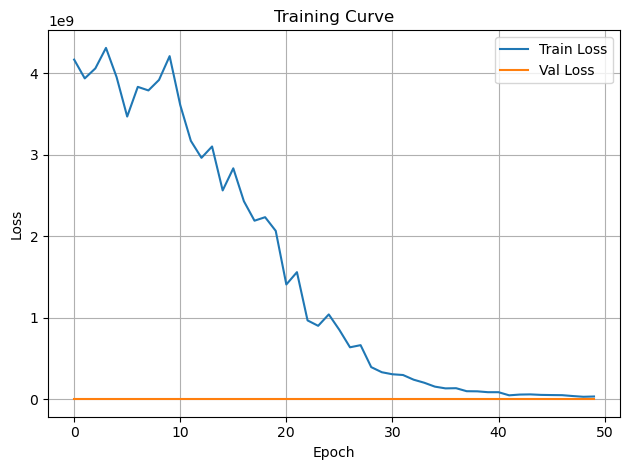

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import numpy as np
from sklearn.decomposition import NMF

# 确保 Y_train 是非负的用于 NMF
Y_train_min = Y_train.min()
Y_train_nmf_input = Y_train - Y_train_min  # 移为非负

# 展平为 (samples, features) 形状
Y_flat = Y_train_nmf_input.reshape((Y_train_nmf_input.shape[0], -1))  # shape: (samples, 250*500)

# 执行 NMF 分解
K = 50
nmf = NMF(n_components=K, init='random', random_state=0, max_iter=500)
Z_nmf = nmf.fit_transform(Y_flat)
omega = nmf.components_  # shape: (K, 250*500)

# 检查维度信息
Z_nmf_shape = Z_nmf.shape
omega_shape = omega.shape

Z_nmf_shape, omega_shape

# 模型定义
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder_net = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim * 2)
        ])
    def call(self, x):
        h = self.encoder_net(x)
        mu, log_zeta = tf.split(h, num_or_size_splits=2, axis=1)
        return mu, log_zeta

def sample_exp_ps(mu, log_zeta, alpha=0.5):
    eps = tf.random.gamma(shape=tf.shape(mu), alpha=alpha)
    z = mu + tf.exp(0.5 * log_zeta) * eps ** (-1.0 / alpha)
    return z

class MaxIDDecoder(tf.keras.Model):
    def __init__(self, omega, alpha0, tau, target_shape):
        super().__init__()
        self.omega = tf.constant(omega, dtype=tf.float32)
        self.alpha0 = alpha0
        self.tau = tau
        self.target_shape = target_shape
    def call(self, z):
        raw = tf.matmul(z, self.omega)
        positive = tf.nn.softplus(raw)
        Y = tf.pow(positive + 1e-6, self.alpha0)
        epsilon = tf.random.gamma(shape=tf.shape(Y), alpha=self.alpha0)
        x_rec = -Y * epsilon * self.tau
        return tf.reshape(x_rec, (-1,) + self.target_shape)

class xVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, kl_annealing=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_annealing = kl_annealing
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.nll_tracker = tf.keras.metrics.Mean(name="nll")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")
        self.epoch_counter = 0
        self.metrics_list = [self.total_loss_tracker, self.nll_tracker, self.kl_tracker]

    @property
    def metrics(self):
        return self.metrics_list


    def compile(self, optimizer, kl_max_weight=1.0, kl_warmup_epochs=10):
        super().compile()
        self.optimizer = optimizer
        self.kl_max_weight = kl_max_weight
        self.kl_warmup_epochs = kl_warmup_epochs

    def train_step(self, data):
        x, y = data
        self.epoch_counter += 1
        kl_weight = min(self.epoch_counter / self.kl_warmup_epochs, 1.0) * self.kl_max_weight

        with tf.GradientTape() as tape:
            mu, log_zeta = self.encoder(x)
            eps = tf.random.gamma(shape=tf.shape(mu), alpha=0.5, beta=1.0)
            eps = tf.clip_by_value(eps, 1e-3, 10.0)
            z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -2.0)  # alpha = 0.5 → -1/alpha = -2

            x_rec = self.decoder(z)
            y = tf.reshape(y, tf.shape(x_rec))
            nll = tf.reduce_mean(tf.square(x_rec - y))
            kl = tf.reduce_mean(0.5 * tf.square(z))
            loss = nll + kl_weight * kl

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)
        return {"loss": self.total_loss_tracker.result(), "nll": self.nll_tracker.result(), "kl": self.kl_tracker.result()}

    def test_step(self, data):
        x, y = data
        mu, log_zeta = self.encoder(x)
        z = mu + tf.exp(0.5 * log_zeta) * tf.random.normal(tf.shape(mu))
        x_rec = self.decoder(z)
        y = tf.reshape(y, tf.shape(x_rec))
        nll = tf.reduce_mean(tf.square(x_rec - y))
        kl = tf.reduce_mean(0.5 * tf.square(z))
        loss = nll + kl

        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)

        return {"loss": loss, "nll": nll, "kl": kl}


# KL 逐步增加 callback
class KLWeightScheduler(callbacks.Callback):
    def __init__(self, kl_weight_var, max_value, epochs):
        self.kl_weight = kl_weight_var
        self.max_value = max_value
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        tf.keras.backend.set_value(self.kl_weight, self.max_value * epoch / self.epochs)

# 构建模型
kl_weight_var = tf.Variable(0.0, trainable=False)
encoder = Encoder(latent_dim=50)
decoder = MaxIDDecoder(omega=omega, alpha0=0.8, tau=1.0, target_shape=(50, 100))
model = xVAE(encoder, decoder, kl_weight_var)
model.compile(optimizer=optimizers.Adam(1e-4))

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, Y_test)
)

# 可视化
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



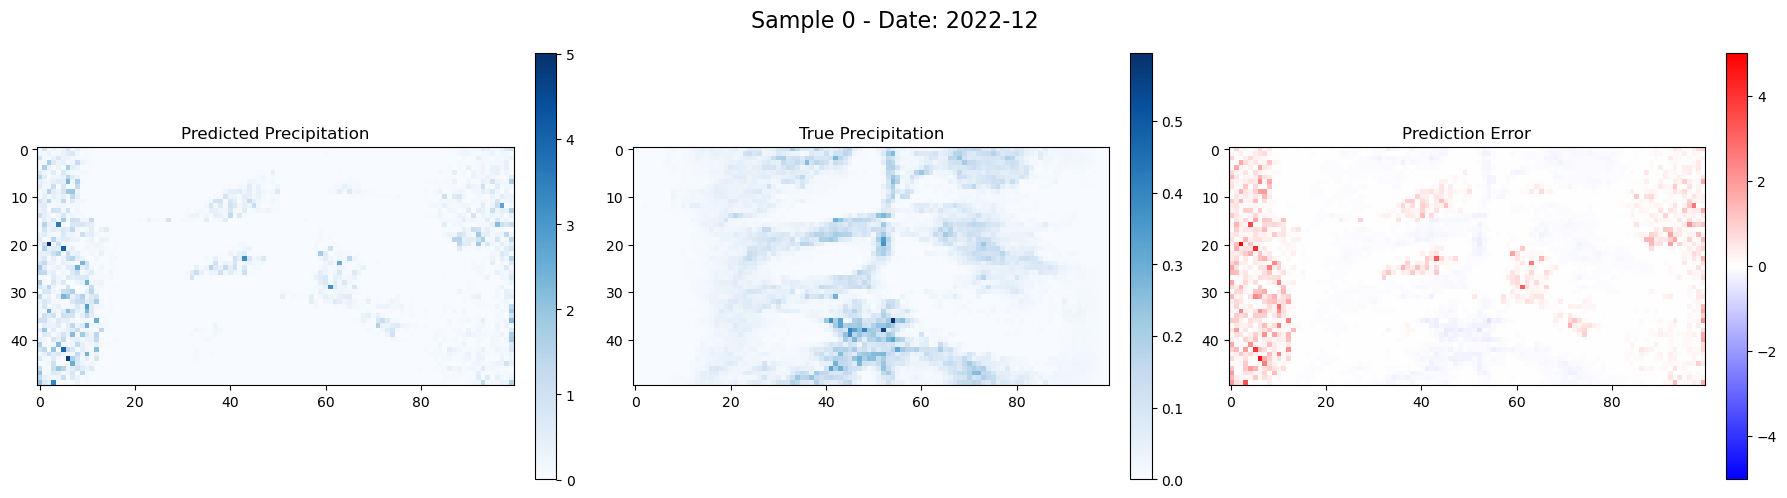

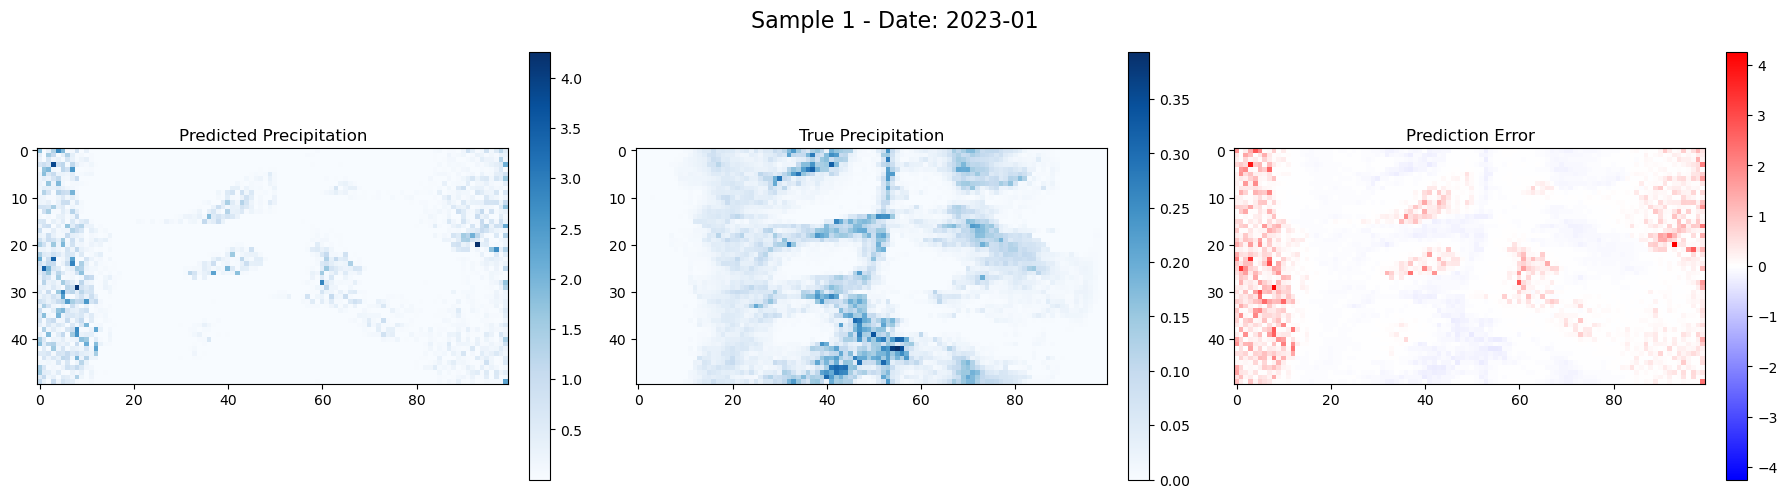

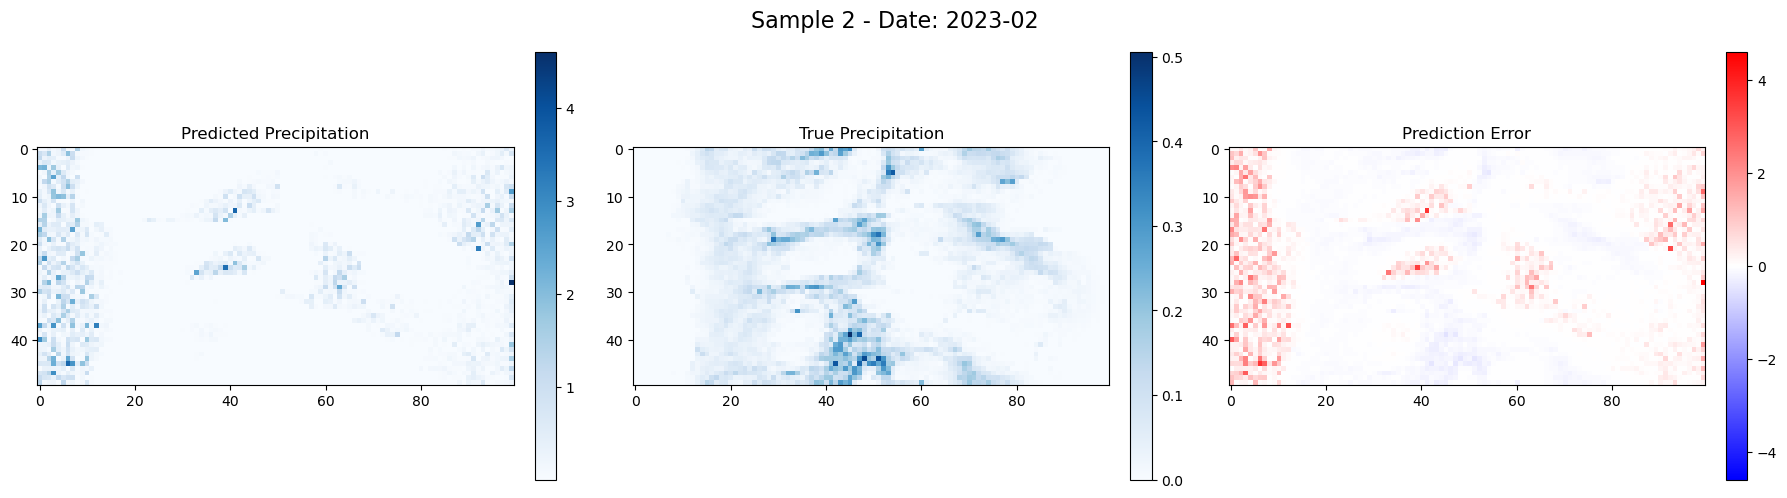

In [11]:
# 1. 获取预测值
mu_test, log_zeta_test = model.encoder(X_test)
z_test = mu_test + tf.exp(0.5 * log_zeta_test) * tf.random.normal(tf.shape(mu_test))
x_rec_test = model.decoder(z_test)  # shape: (num_test, 50, 100)

# 2. 恢复为实际降水值（反归一化 + Y_train_min 还原）
preds_actual = x_rec_test.numpy()  # decoder 本身输出为负值 → 还原为正值
preds_actual = preds_actual + Y_train_min  # 加上之前为了 NMF 而减掉的最小值
preds_actual = np.maximum(preds_actual, 0)  # clip 负值为0

# 3. 真实值也要做相同的还原
y_test_actual = Y_test + Y_train_min

# 4. 可视化预测效果
def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array, split_time):
    pred = preds_actual[index]
    truth = np.squeeze(y_test_actual[index], axis=-1)  # 修复多余的维度
    error = pred - truth

    time_str = np.datetime_as_string(time_array[split_time + index], unit='M')

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].imshow(pred, cmap='Blues')
    axes[0].set_title("Predicted Precipitation")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(truth, cmap='Blues')
    axes[1].set_title("True Precipitation")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(error, cmap='bwr', vmin=-np.max(np.abs(error)), vmax=np.max(np.abs(error)))
    axes[2].set_title("Prediction Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Sample {index} - Date: {time_str}", fontsize=16)
    plt.tight_layout()
    plt.show()


# 5. 展示前几个样本
for i in range(3):
    plot_prediction_comparison(i, preds_actual, y_test_actual, combined005.time.values, split_time)


正在进行预测...
还原测试集真实值...
计算评估指标...

评估指标:
MSE: 731686266470400.000000
MAE: 3266691.000000
RMSE: 27049700.000000
Correlation: 0.093372

可视化前5个样本的预测结果...


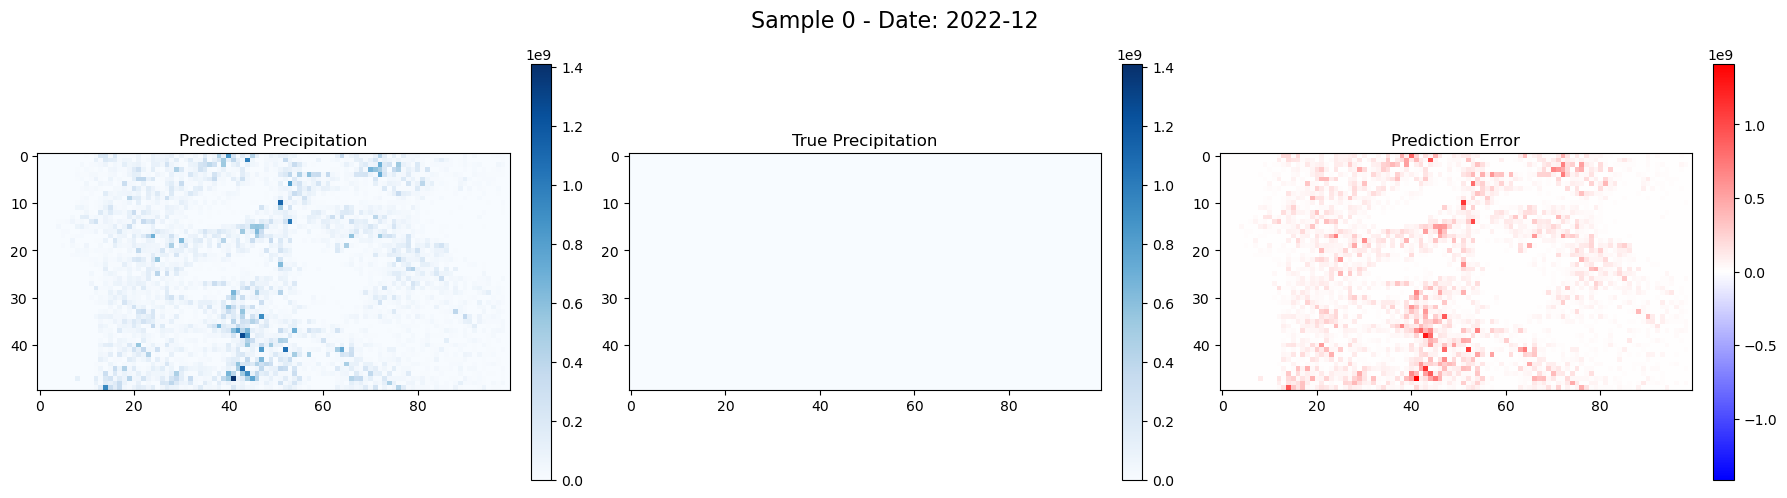

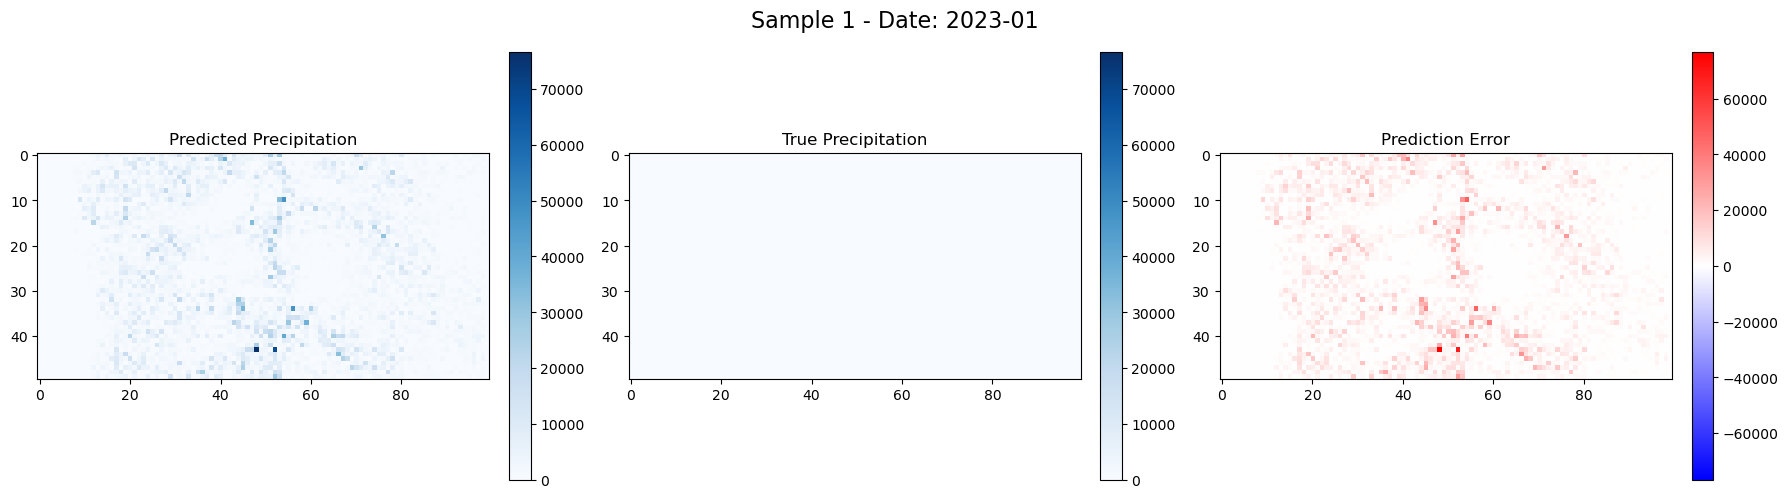

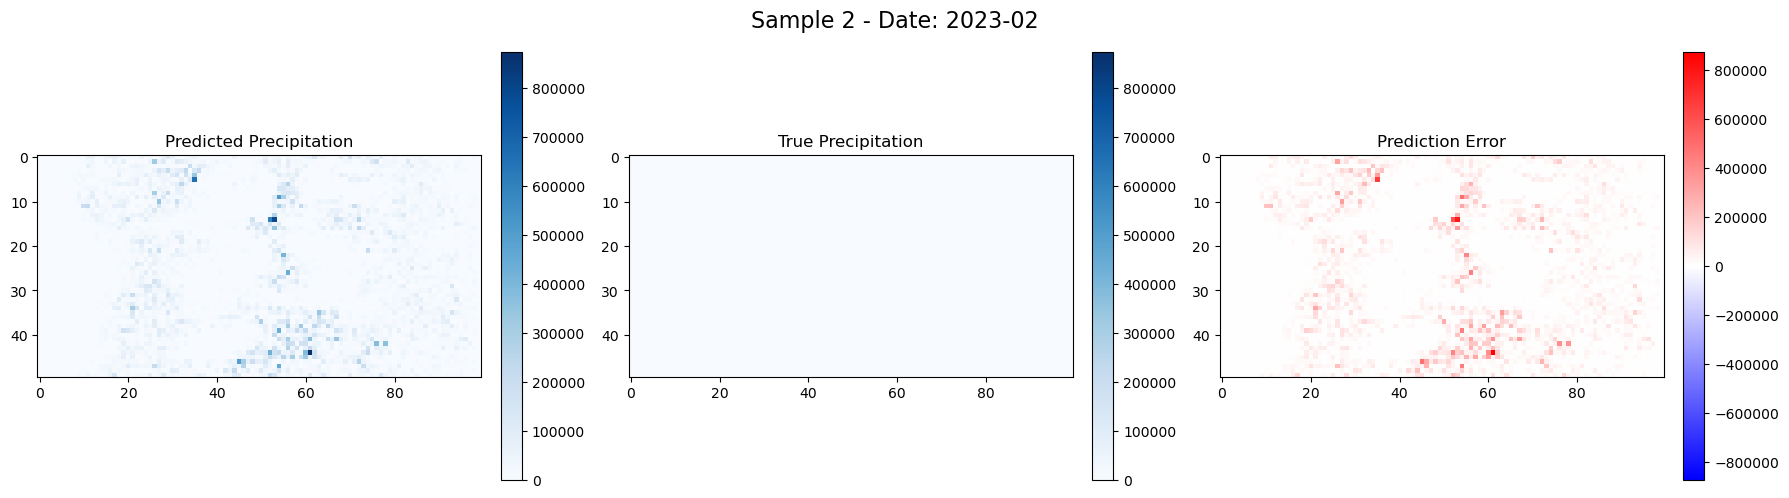

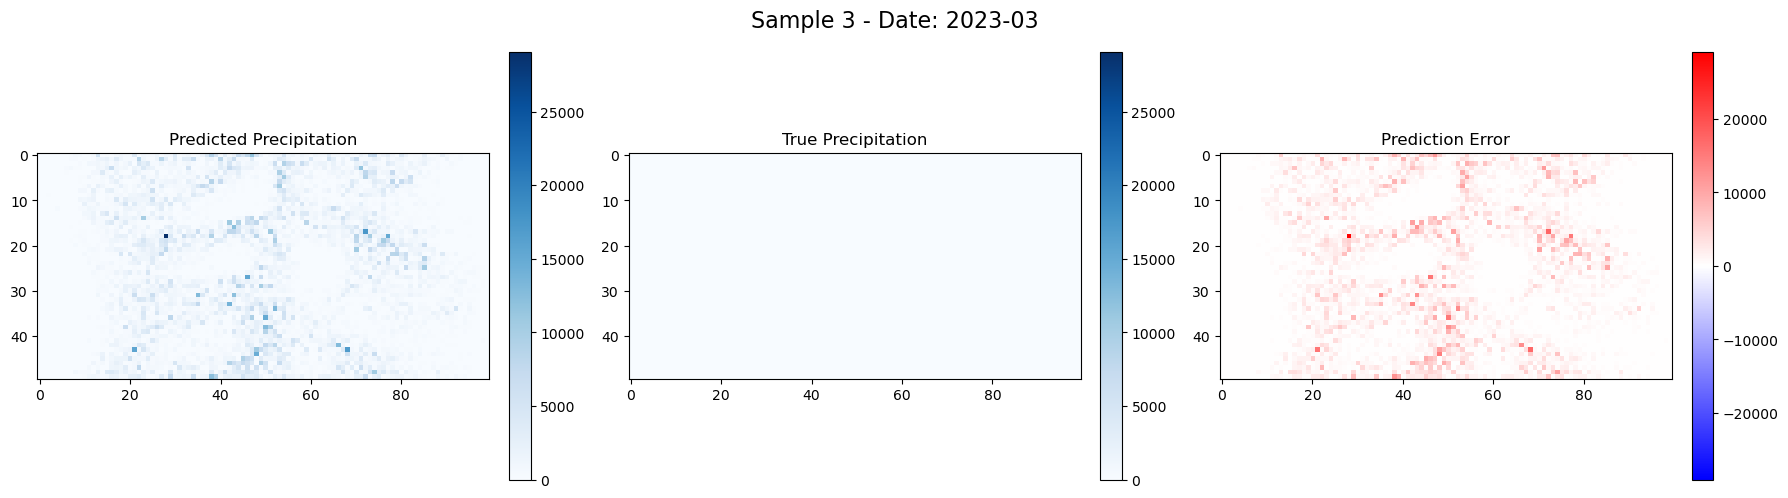

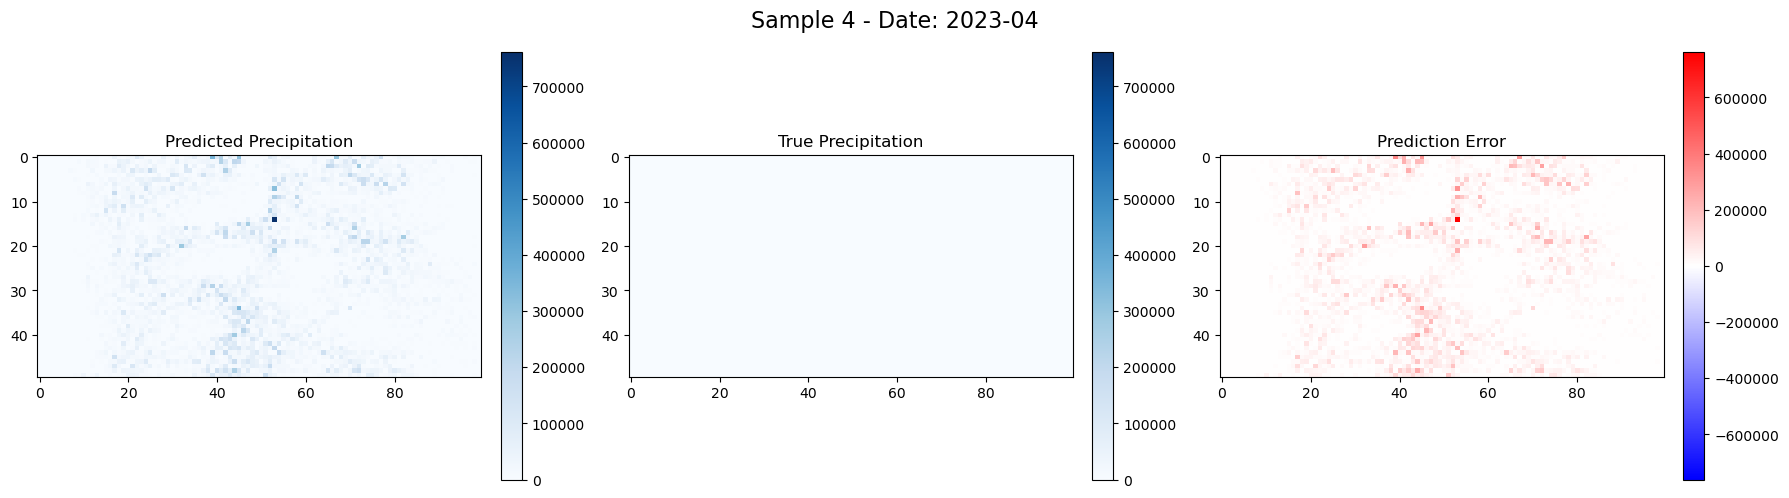

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. 获取预测值
def predict_with_xvae(model, X_test, Y_train_min):
    """
    使用训练好的xVAE模型进行预测
    
    Args:
        model: 训练好的xVAE模型
        X_test: 测试数据
        Y_train_min: 训练数据中的最小值 (用于还原预测值)
    
    Returns:
        preds_actual: 实际预测降水值
    """
    # 获取潜在编码
    mu_test, log_zeta_test = model.encoder(X_test)
    
    # 从分布中采样，使用正确的采样方法（与模型训练中使用的方法一致）
    eps = tf.random.gamma(shape=tf.shape(mu_test), alpha=0.5)
    z_test = mu_test + tf.exp(0.5 * log_zeta_test) * tf.pow(eps, -2.0)  # alpha = 0.5 -> -1/alpha = -2
    
    # 使用decoder生成预测
    x_rec_test = model.decoder(z_test)  # shape: (num_test, 50, 100)
    
    # 2. 恢复为实际降水值（反归一化 + Y_train_min 还原）
    preds_actual = x_rec_test.numpy()
    preds_actual = preds_actual + Y_train_min  # 加上之前为了 NMF 而减掉的最小值
    preds_actual = np.maximum(preds_actual, 0)  # clip 负值为0
    
    return preds_actual

# 3. 对实际测试值进行同样的还原
def restore_test_values(Y_test, Y_train_min):
    """
    还原测试集的真实值
    
    Args:
        Y_test: 测试集标签
        Y_train_min: 训练数据中的最小值
    
    Returns:
        y_test_actual: 还原后的测试集真实值
    """
    y_test_actual = Y_test + Y_train_min
    return y_test_actual

# 4. 可视化预测效果
def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array=None, split_time=None):
    """
    可视化预测与真实降水对比
    
    Args:
        index: 样本索引
        preds_actual: 预测的实际降水值
        y_test_actual: 测试集的实际降水值
        time_array: 时间数组（可选）
        split_time: 分割时间点（可选）
    """
    pred = preds_actual[index]
    truth = np.squeeze(y_test_actual[index], axis=-1) if len(y_test_actual[index].shape) > 2 else y_test_actual[index]
    error = pred - truth
    
    # 处理时间显示
    time_str = ""
    if time_array is not None and split_time is not None:
        try:
            time_str = np.datetime_as_string(time_array[split_time + index], unit='M')
            title_suffix = f" - Date: {time_str}"
        except:
            title_suffix = ""
    else:
        title_suffix = ""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 预测图
    vmax = max(np.max(pred), np.max(truth))
    
    im0 = axes[0].imshow(pred, cmap='Blues', vmin=0, vmax=vmax)
    axes[0].set_title("Predicted Precipitation")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # 真实值图
    im1 = axes[1].imshow(truth, cmap='Blues', vmin=0, vmax=vmax)
    axes[1].set_title("True Precipitation")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # 误差图
    max_error = np.max(np.abs(error))
    im2 = axes[2].imshow(error, cmap='bwr', vmin=-max_error, vmax=max_error)
    axes[2].set_title("Prediction Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Sample {index}{title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

# 5. 计算评估指标
def calculate_metrics(preds_actual, y_test_actual):
    """
    计算预测性能指标
    
    Args:
        preds_actual: 预测的实际降水值
        y_test_actual: 测试集的实际降水值
        
    Returns:
        metrics: 包含各种评估指标的字典
    """
    # 确保维度一致
    if len(y_test_actual.shape) > len(preds_actual.shape):
        y_test_actual = np.squeeze(y_test_actual, axis=-1)
    
    # 计算MSE
    mse = np.mean((preds_actual - y_test_actual) ** 2)
    
    # 计算MAE
    mae = np.mean(np.abs(preds_actual - y_test_actual))
    
    # 计算RMSE
    rmse = np.sqrt(mse)
    
    # 计算相关系数
    # 首先将数据展平
    pred_flat = preds_actual.flatten()
    truth_flat = y_test_actual.flatten()
    
    # 计算皮尔逊相关系数
    correlation = np.corrcoef(pred_flat, truth_flat)[0, 1]
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Correlation': correlation
    }

# 主执行函数
def main_prediction_workflow(model, X_test, Y_test, Y_train_min, time_array=None, split_time=None, num_samples=3):
    """
    完整的预测工作流程
    
    Args:
        model: 训练好的xVAE模型
        X_test: 测试输入数据
        Y_test: 测试标签数据
        Y_train_min: 训练数据最小值
        time_array: 时间数组（可选）
        split_time: 分割时间点（可选）
        num_samples: 要可视化的样本数量
    """
    # 1. 进行预测
    print("正在进行预测...")
    preds_actual = predict_with_xvae(model, X_test, Y_train_min)
    
    # 2. 还原测试集真实值
    print("还原测试集真实值...")
    y_test_actual = restore_test_values(Y_test, Y_train_min)
    
    # 3. 计算评估指标
    print("计算评估指标...")
    metrics = calculate_metrics(preds_actual, y_test_actual)
    print("\n评估指标:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.6f}")
    
    # 4. 可视化样本
    print(f"\n可视化前{num_samples}个样本的预测结果...")
    for i in range(min(num_samples, len(X_test))):
        plot_prediction_comparison(i, preds_actual, y_test_actual, time_array, split_time)
    
    return preds_actual, y_test_actual, metrics

# 使用示例:

# 假设模型已经训练好，并且有以下变量:
# model: 训练好的模型
# X_test, Y_test: 测试数据
# Y_train_min: 训练数据的最小值
# combined005.time.values: 时间数组
# split_time: 分割时间点

# 运行预测工作流
preds_actual, y_test_actual, metrics = main_prediction_workflow(
    model, X_test, Y_test, Y_train_min, 
    time_array=combined005.time.values, 
    split_time=split_time,
    num_samples=5
)


正在进行预测...
还原测试集真实值...
计算评估指标...

评估指标:
MSE: 14604361817729684996096.000000
MAE: 8611406848.000000
RMSE: 120848506880.000000
Correlation: 0.059629

可视化前5个样本的预测结果...


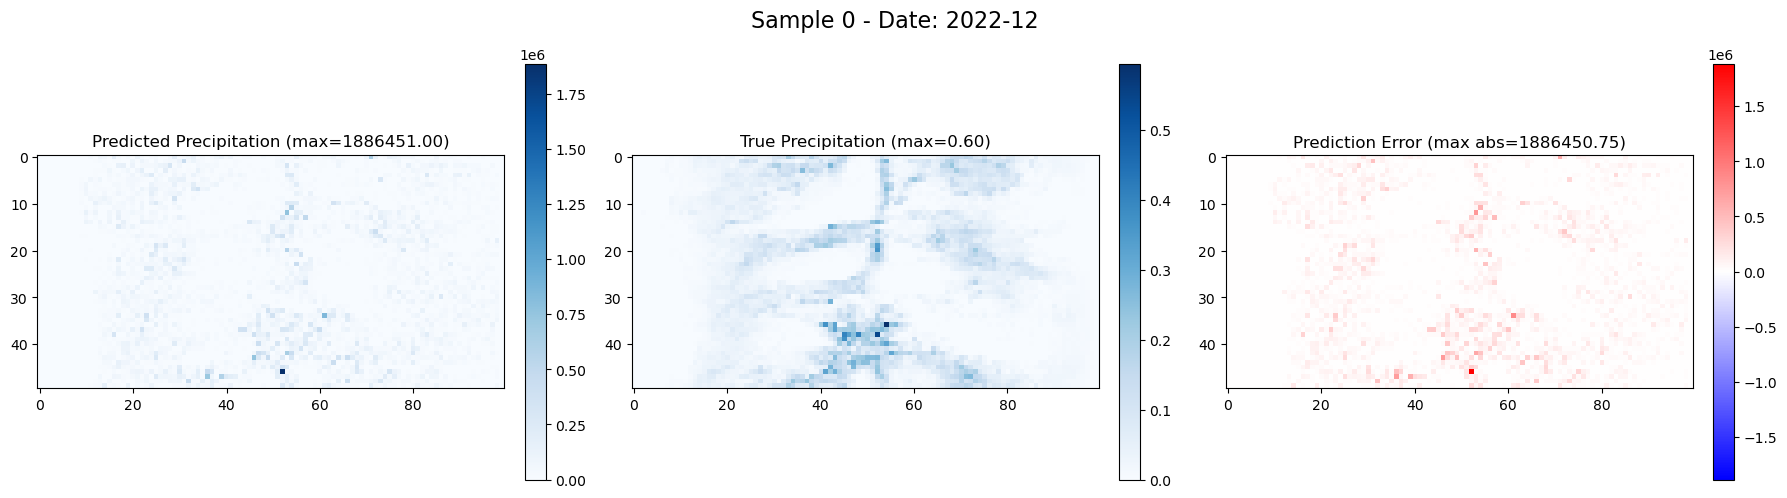

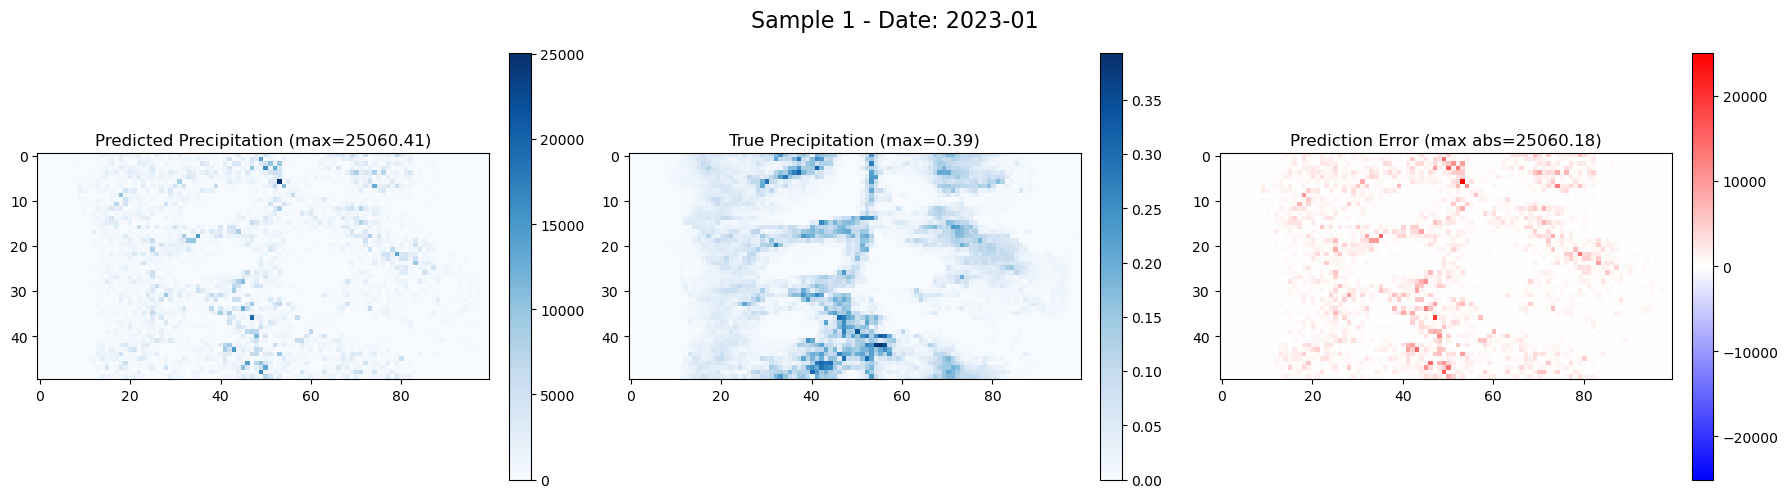

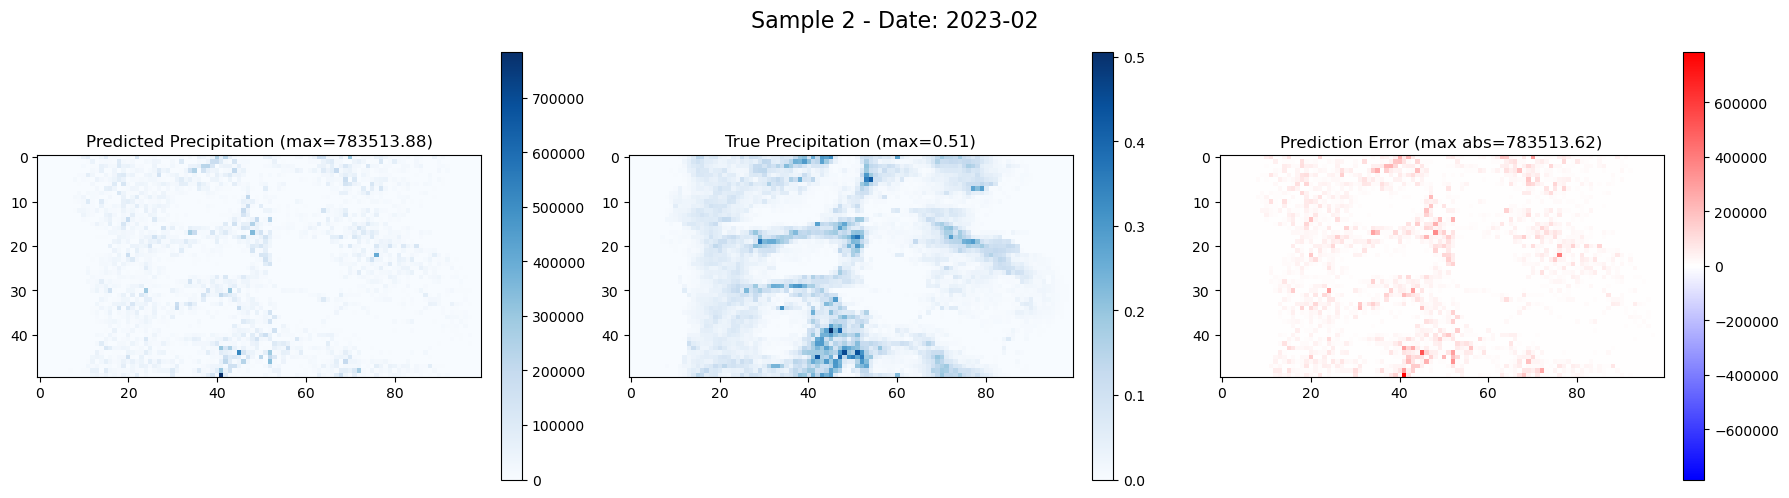

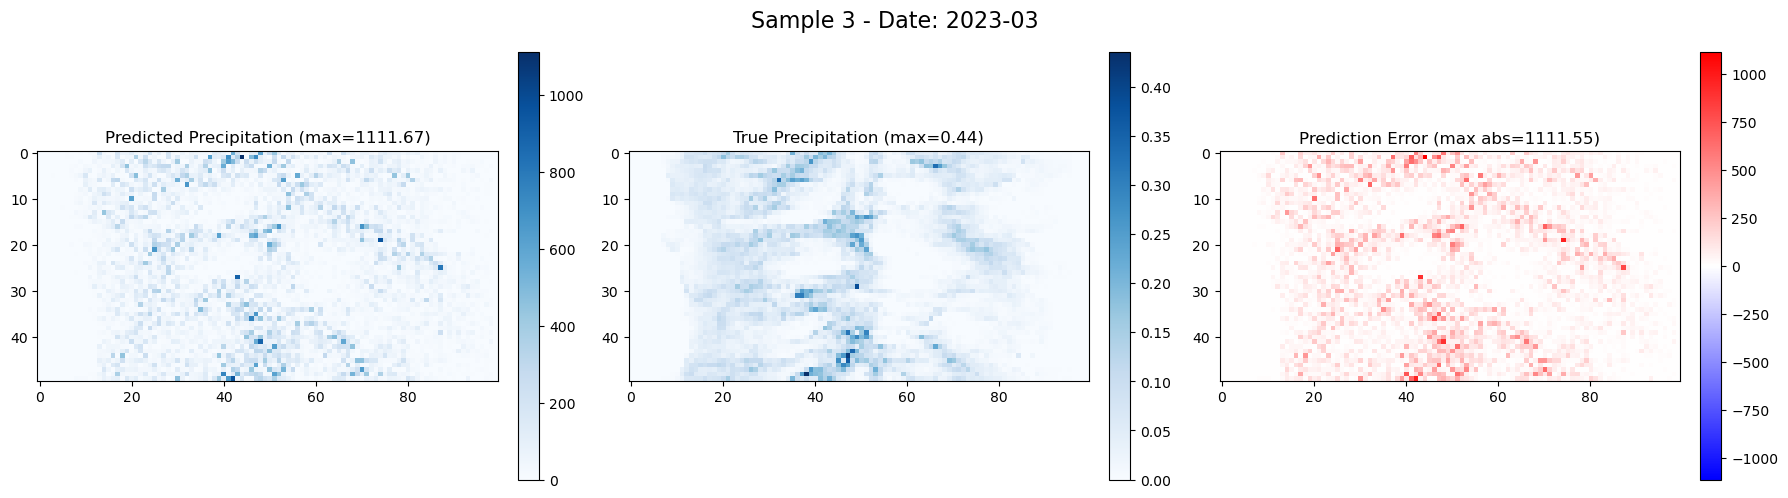

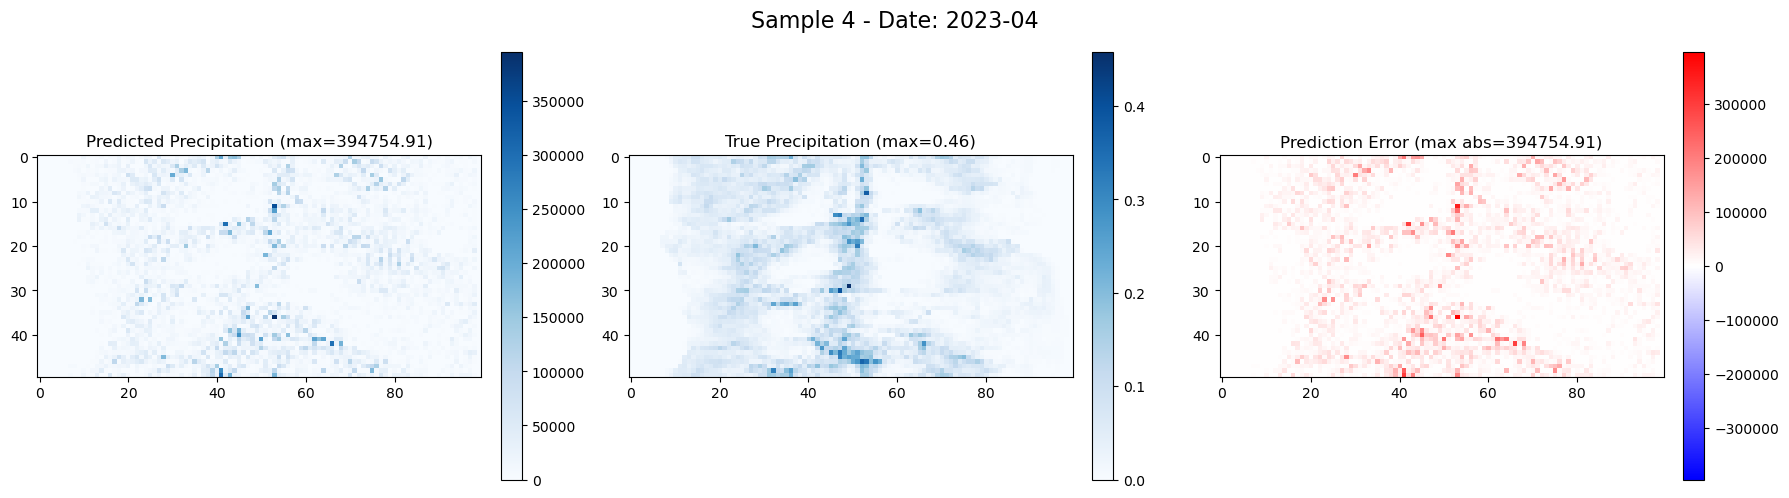

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. 获取预测值
def predict_with_xvae(model, X_test, Y_train_min):
    """
    使用训练好的xVAE模型进行预测
    
    Args:
        model: 训练好的xVAE模型
        X_test: 测试数据
        Y_train_min: 训练数据中的最小值 (用于还原预测值)
    
    Returns:
        preds_actual: 实际预测降水值
    """
    # 获取潜在编码
    mu_test, log_zeta_test = model.encoder(X_test)
    
    # 从分布中采样，使用正确的采样方法（与模型训练中使用的方法一致）
    eps = tf.random.gamma(shape=tf.shape(mu_test), alpha=0.5)
    z_test = mu_test + tf.exp(0.5 * log_zeta_test) * tf.pow(eps, -2.0)  # alpha = 0.5 -> -1/alpha = -2
    
    # 使用decoder生成预测
    x_rec_test = model.decoder(z_test)  # shape: (num_test, 50, 100)
    
    # 2. 恢复为实际降水值（反归一化 + Y_train_min 还原）
    preds_actual = x_rec_test.numpy()
    preds_actual = preds_actual + Y_train_min  # 加上之前为了 NMF 而减掉的最小值
    preds_actual = np.maximum(preds_actual, 0)  # clip 负值为0
    
    return preds_actual

# 3. 对实际测试值进行同样的还原
def restore_test_values(Y_test, Y_train_min):
    """
    还原测试集的真实值
    
    Args:
        Y_test: 测试集标签
        Y_train_min: 训练数据中的最小值
    
    Returns:
        y_test_actual: 还原后的测试集真实值
    """
    y_test_actual = Y_test + Y_train_min
    return y_test_actual

# 4. 可视化预测效果
def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array=None, split_time=None):
    """
    可视化预测与真实降水对比，每个图使用独立的颜色尺度
    
    Args:
        index: 样本索引
        preds_actual: 预测的实际降水值
        y_test_actual: 测试集的实际降水值
        time_array: 时间数组（可选）
        split_time: 分割时间点（可选）
    """
    pred = preds_actual[index]
    truth = np.squeeze(y_test_actual[index], axis=-1) if len(y_test_actual[index].shape) > 2 else y_test_actual[index]
    error = pred - truth
    
    # 处理时间显示
    time_str = ""
    if time_array is not None and split_time is not None:
        try:
            time_str = np.datetime_as_string(time_array[split_time + index], unit='M')
            title_suffix = f" - Date: {time_str}"
        except:
            title_suffix = ""
    else:
        title_suffix = ""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 预测图 - 使用独立尺度
    vmin_pred, vmax_pred = 0, np.max(pred)
    im0 = axes[0].imshow(pred, cmap='Blues', vmin=vmin_pred, vmax=vmax_pred)
    axes[0].set_title(f"Predicted Precipitation (max={vmax_pred:.2f})")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # 真实值图 - 使用独立尺度
    vmin_truth, vmax_truth = 0, np.max(truth)
    im1 = axes[1].imshow(truth, cmap='Blues', vmin=vmin_truth, vmax=vmax_truth)
    axes[1].set_title(f"True Precipitation (max={vmax_truth:.2f})")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # 误差图 - 使用独立尺度
    max_error = np.max(np.abs(error))
    im2 = axes[2].imshow(error, cmap='bwr', vmin=-max_error, vmax=max_error)
    axes[2].set_title(f"Prediction Error (max abs={max_error:.2f})")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Sample {index}{title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

# 5. 计算评估指标
def calculate_metrics(preds_actual, y_test_actual):
    """
    计算预测性能指标
    
    Args:
        preds_actual: 预测的实际降水值
        y_test_actual: 测试集的实际降水值
        
    Returns:
        metrics: 包含各种评估指标的字典
    """
    # 确保维度一致
    if len(y_test_actual.shape) > len(preds_actual.shape):
        y_test_actual = np.squeeze(y_test_actual, axis=-1)
    
    # 计算MSE
    mse = np.mean((preds_actual - y_test_actual) ** 2)
    
    # 计算MAE
    mae = np.mean(np.abs(preds_actual - y_test_actual))
    
    # 计算RMSE
    rmse = np.sqrt(mse)
    
    # 计算相关系数
    # 首先将数据展平
    pred_flat = preds_actual.flatten()
    truth_flat = y_test_actual.flatten()
    
    # 计算皮尔逊相关系数
    correlation = np.corrcoef(pred_flat, truth_flat)[0, 1]
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Correlation': correlation
    }

# 主执行函数
def main_prediction_workflow(model, X_test, Y_test, Y_train_min, time_array=None, split_time=None, num_samples=3):
    """
    完整的预测工作流程
    
    Args:
        model: 训练好的xVAE模型
        X_test: 测试输入数据
        Y_test: 测试标签数据
        Y_train_min: 训练数据最小值
        time_array: 时间数组（可选）
        split_time: 分割时间点（可选）
        num_samples: 要可视化的样本数量
    """
    # 1. 进行预测
    print("正在进行预测...")
    preds_actual = predict_with_xvae(model, X_test, Y_train_min)
    
    # 2. 还原测试集真实值
    print("还原测试集真实值...")
    y_test_actual = restore_test_values(Y_test, Y_train_min)
    
    # 3. 计算评估指标
    print("计算评估指标...")
    metrics = calculate_metrics(preds_actual, y_test_actual)
    print("\n评估指标:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.6f}")
    
    # 4. 可视化样本
    print(f"\n可视化前{num_samples}个样本的预测结果...")
    for i in range(min(num_samples, len(X_test))):
        plot_prediction_comparison(i, preds_actual, y_test_actual, time_array, split_time)
    
    return preds_actual, y_test_actual, metrics

# 使用示例:

# 假设模型已经训练好，并且有以下变量:
# model: 训练好的模型
# X_test, Y_test: 测试数据
# Y_train_min: 训练数据的最小值
# combined005.time.values: 时间数组
# split_time: 分割时间点

# 运行预测工作流
preds_actual, y_test_actual, metrics = main_prediction_workflow(
    model, X_test, Y_test, Y_train_min, 
    time_array=combined005.time.values, 
    split_time=split_time,
    num_samples=5
)


Organizing predictions by time and coordinates...
Creating spatial plot for the first time step...
Creating time series for a specific region...
Creating comparison between predicted and actual precipitation...
Creating multi-panel time visualization...


C:\Users\18857\AppData\Local\Temp\ipykernel_7400\1155939201.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Exporting predictions to netCDF file...
Exported predictions to precipitation_predictions.nc
Organization workflow completed!


C:\Users\18857\AppData\Local\Temp\ipykernel_7400\1155939201.py:403: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


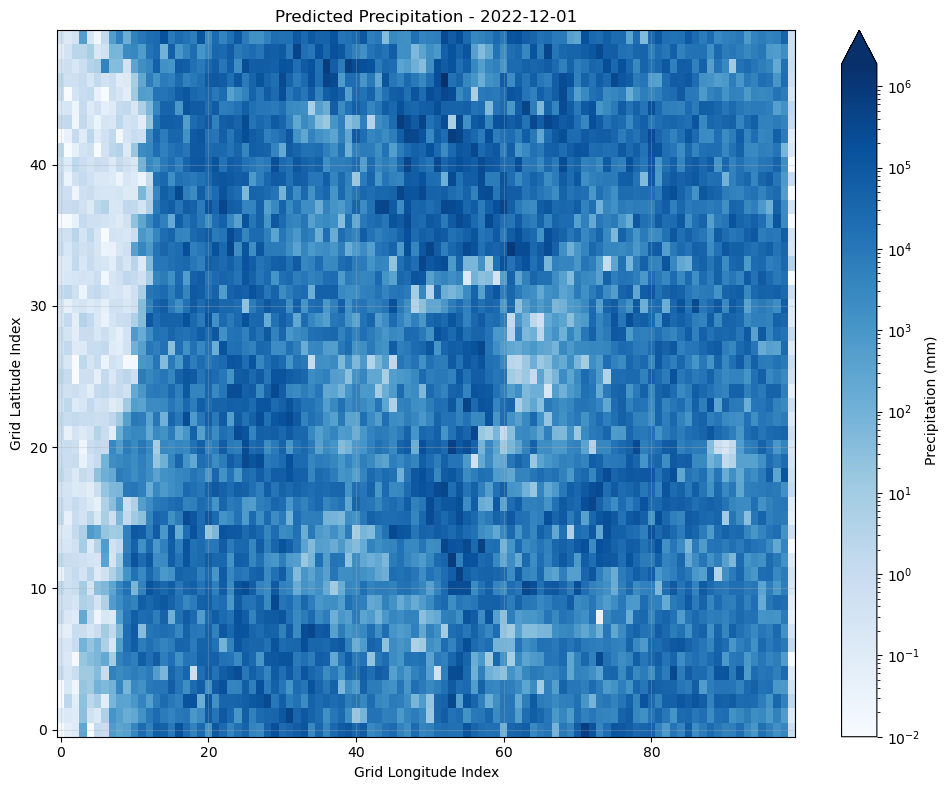

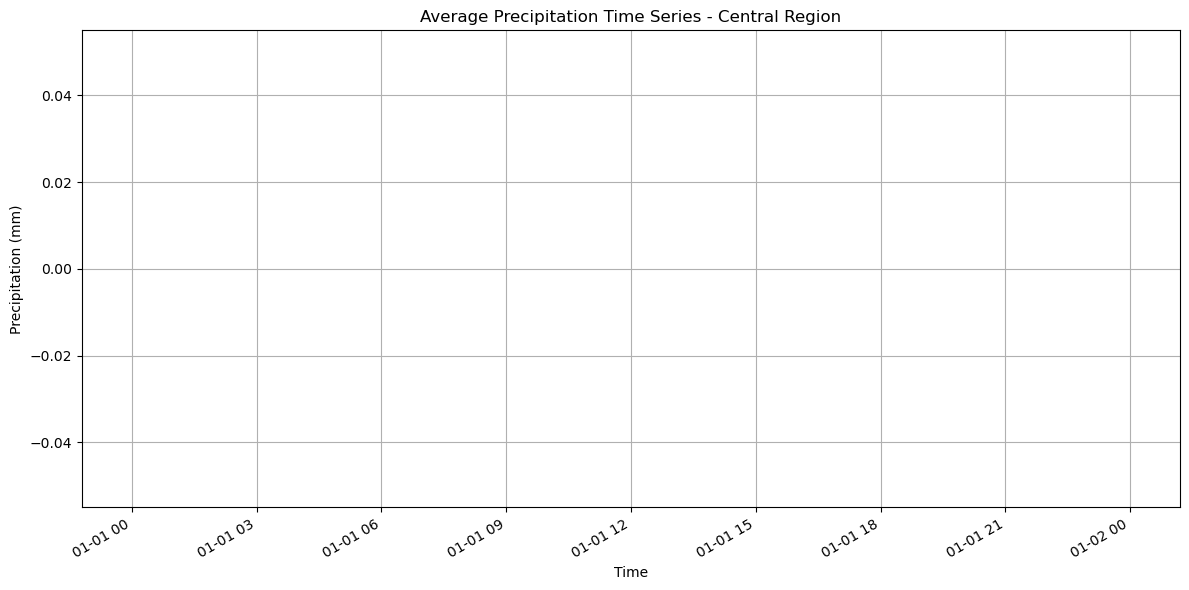

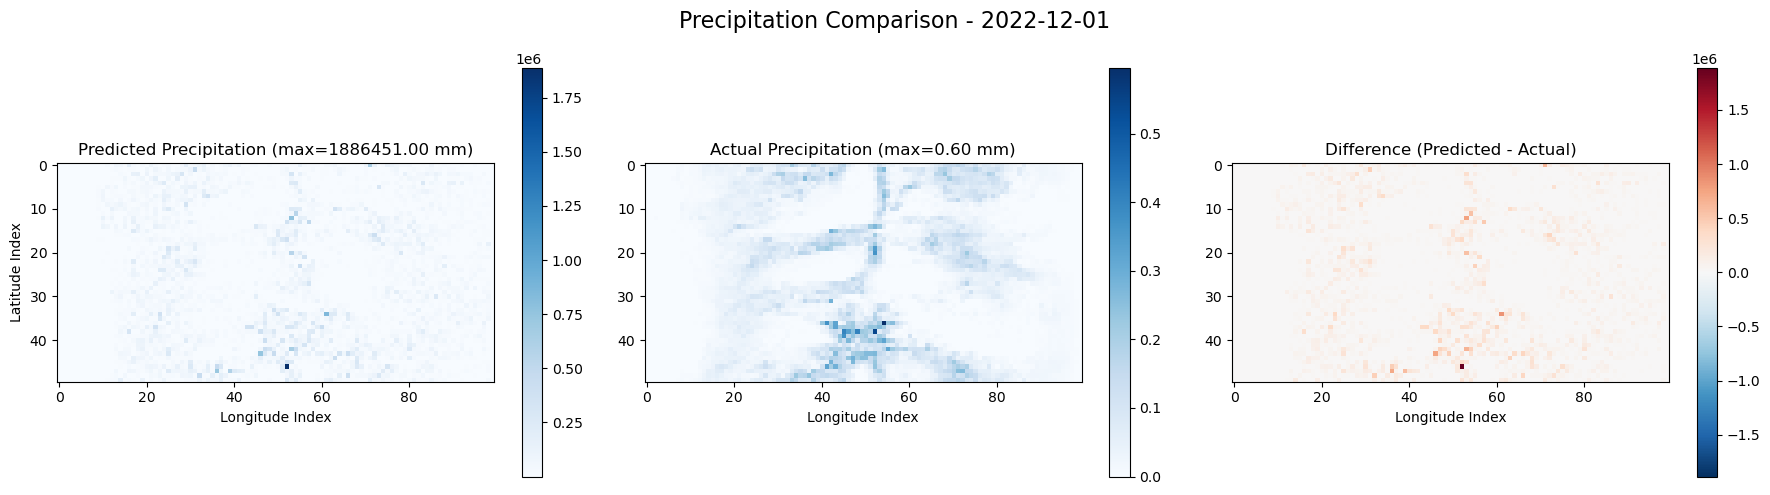

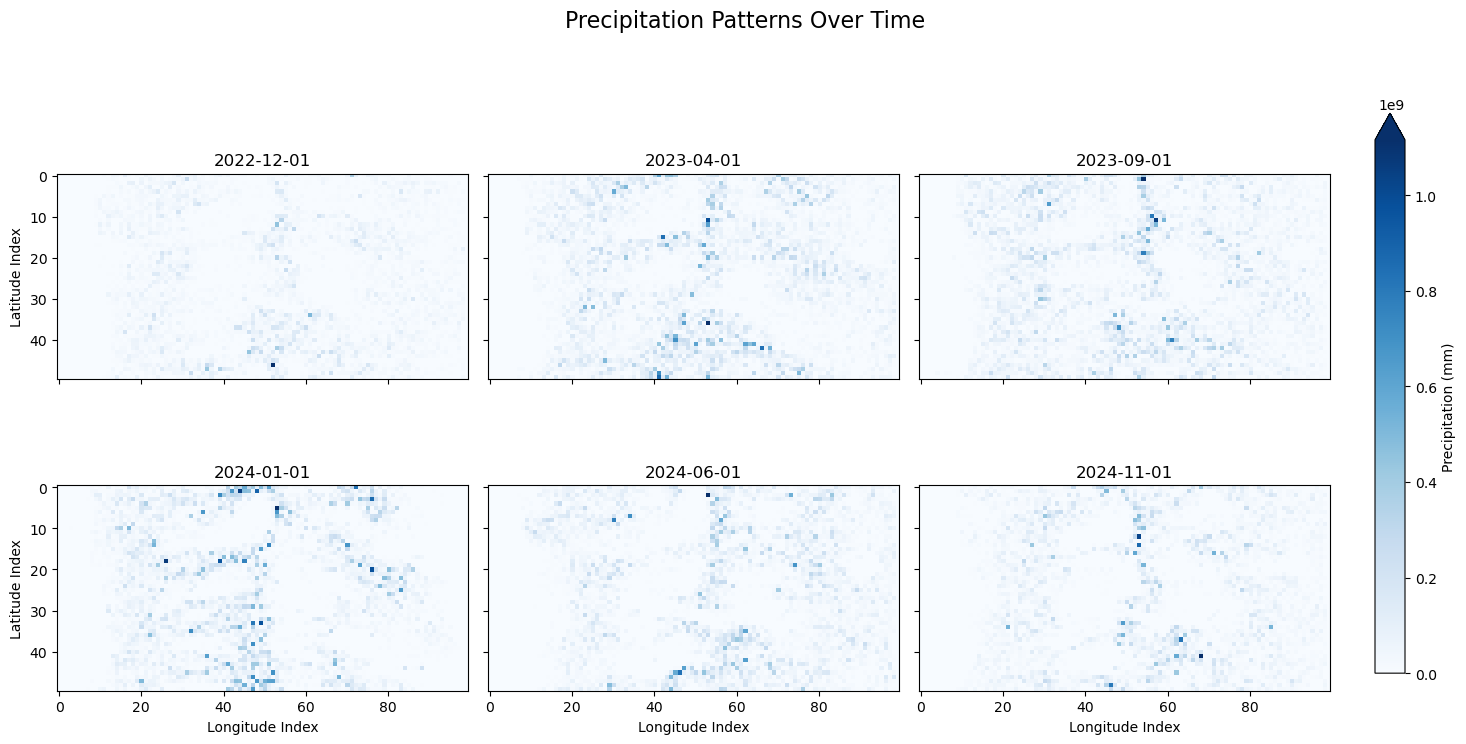

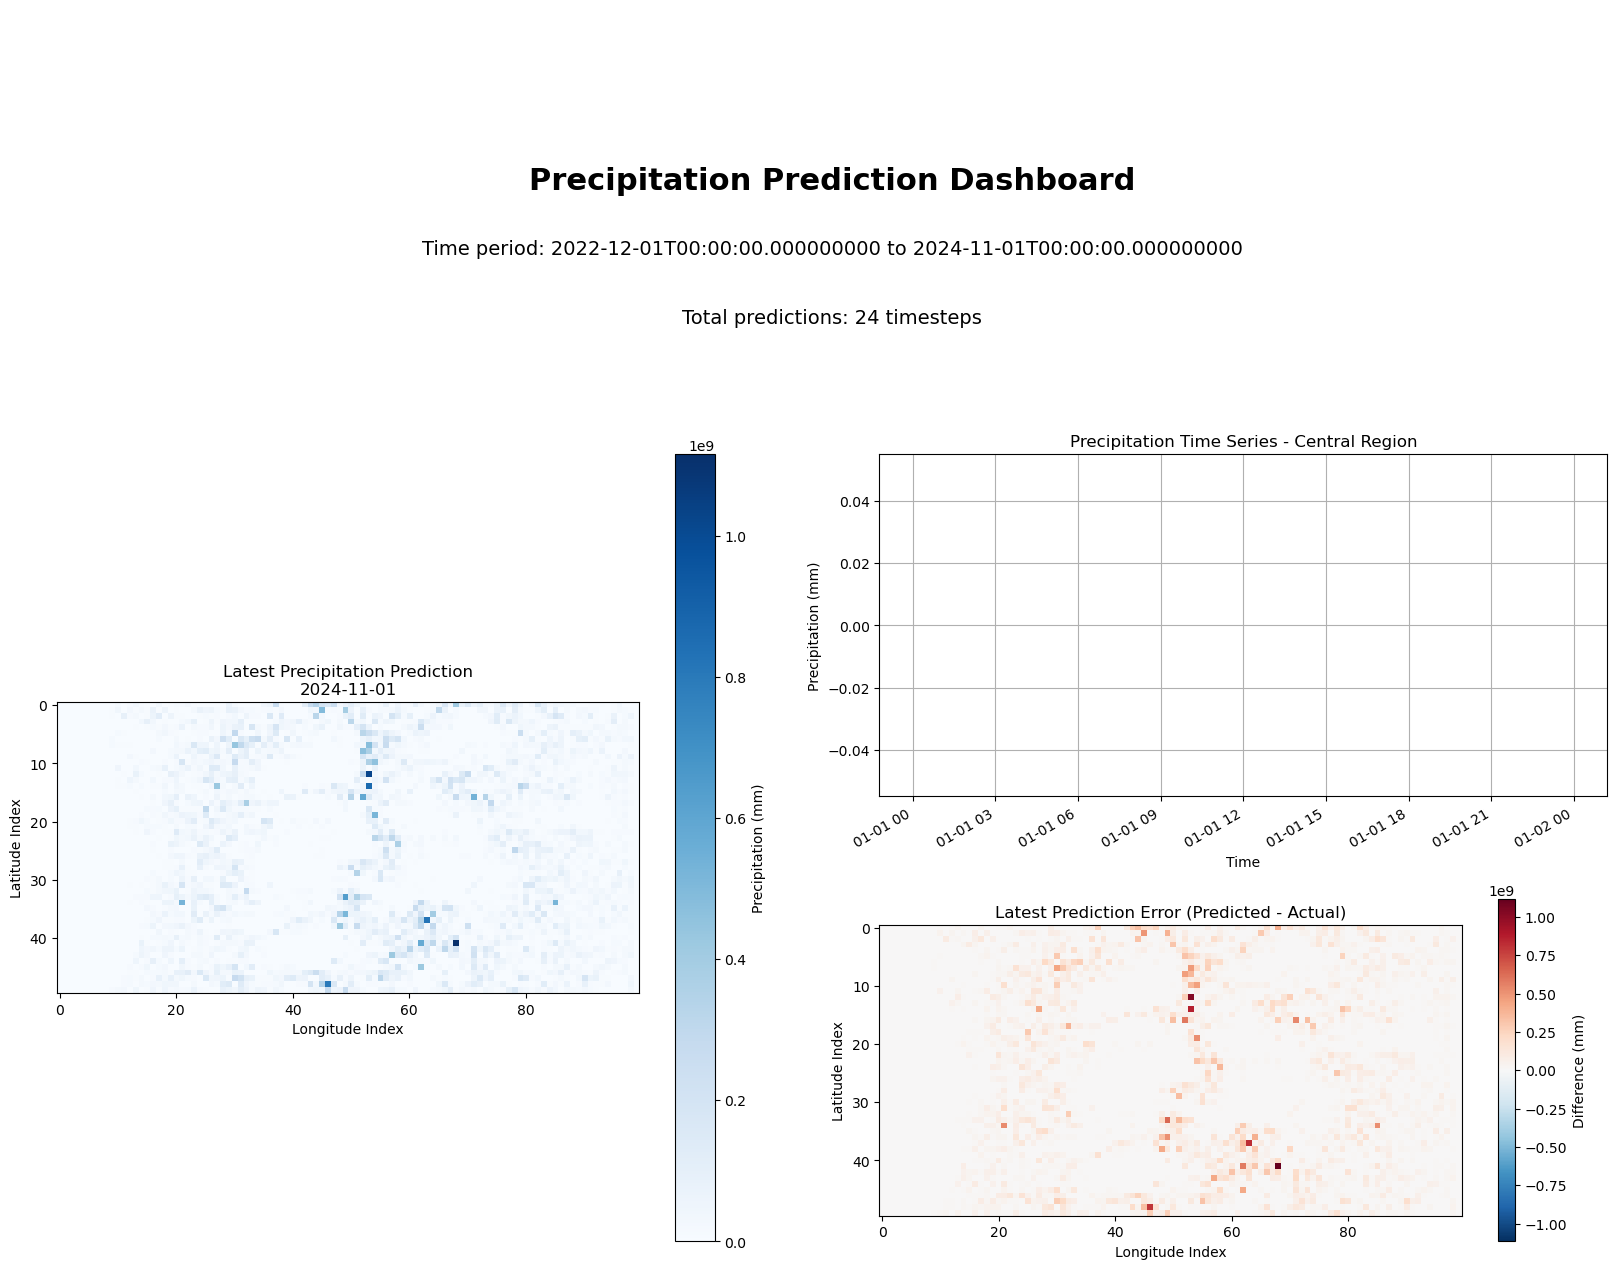

In [22]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors

def organize_predictions_by_time_and_coords(preds_actual, time_array, split_time):
    """
    Organize prediction results by time and geographic coordinates
    
    Args:
        preds_actual: Predicted precipitation values
        time_array: Array of time values
        split_time: Time index where training/test split occurs
        
    Returns:
        ds_predictions: xarray Dataset with predictions organized by time and location
    """
    # Get the time values for the test period
    test_times = time_array[split_time:split_time+len(preds_actual)]
    
    # Get dimensions
    n_time = len(test_times)
    n_lat, n_lon = preds_actual.shape[1:3]
    
    # Create 1D coordinate arrays (simple indices)
    lat_1d = np.arange(n_lat)
    lon_1d = np.arange(n_lon)
    
    # Reshape predictions if needed
    if len(preds_actual.shape) > 3:
        preds_reshaped = preds_actual.reshape(n_time, n_lat, n_lon)
    else:
        preds_reshaped = preds_actual
    
    # Create an xarray Dataset with 1D coordinates
    ds_predictions = xr.Dataset(
        data_vars={
            "predicted_precipitation": (["time", "lat", "lon"], preds_reshaped),
        },
        coords={
            "time": test_times,
            "lat": lat_1d,
            "lon": lon_1d
        }
    )
    
    # Add metadata
    ds_predictions.attrs["description"] = "Super-resolution precipitation predictions from xVAE model"
    ds_predictions.predicted_precipitation.attrs["units"] = "mm"
    
    return ds_predictions

def plot_spatial_prediction(ds_predictions, time_index):
    """
    Plot a spatial map of precipitation prediction for a specific time
    
    Args:
        ds_predictions: xarray Dataset with predictions
        time_index: Index of time to plot
    """
    # Extract the precipitation data for the given time
    precip = ds_predictions.predicted_precipitation.isel(time=time_index)
    time_value = ds_predictions.time.values[time_index]
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a colormap for precipitation
    vmin = 0
    vmax = precip.max().item()
    
    # Use log norm if data has a wide range, otherwise use linear
    if vmax > 10 * vmin and vmax > 0.1:
        precip_plot = precip.copy()
        # Add a small value to avoid log(0)
        precip_plot = precip_plot.where(precip_plot > 0, 0.01) 
        norm = colors.LogNorm(vmin=max(0.01, precip_plot.min().item()), vmax=vmax)
    else:
        precip_plot = precip
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # Plot the precipitation data
    mesh = ax.pcolormesh(
        ds_predictions.lon, ds_predictions.lat, 
        precip_plot, norm=norm, cmap='Blues'
    )
    
    # Add colorbar and title
    cbar = plt.colorbar(mesh, ax=ax, extend='max', label='Precipitation (mm)')
    plt.title(f'Predicted Precipitation - {np.datetime_as_string(time_value, unit="D")}')
    
    # Add labels
    ax.set_xlabel('Grid Longitude Index')
    ax.set_ylabel('Grid Latitude Index')
    
    # Add grid
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_time_series_for_region(ds_predictions, lat_bounds, lon_bounds):
    """
    Create a time series of average precipitation for a specific region
    
    Args:
        ds_predictions: xarray Dataset with predictions
        lat_bounds: Tuple of (min_lat, max_lat) indices
        lon_bounds: Tuple of (min_lon, max_lon) indices
        
    Returns:
        region_time_series: xarray DataArray with time series for the region
    """
    # Extract the region
    region = ds_predictions.predicted_precipitation.sel(
        lat=slice(lat_bounds[0], lat_bounds[1]),
        lon=slice(lon_bounds[0], lon_bounds[1])
    )
    
    # Calculate the spatial average
    region_time_series = region.mean(dim=["lat", "lon"])
    
    return region_time_series

def plot_time_series(region_time_series, region_name):
    """
    Plot a time series of precipitation for a specific region
    
    Args:
        region_time_series: xarray DataArray with time series
        region_name: Name of the region for the title
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    region_time_series.plot(ax=ax, marker='o')
    
    ax.set_title(f'Average Precipitation Time Series - {region_name}')
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xlabel('Time')
    ax.grid(True)
    
    plt.tight_layout()
    return fig

def export_to_netcdf(ds_predictions, filename):
    """
    Export the predictions to a netCDF file
    
    Args:
        ds_predictions: xarray Dataset with predictions
        filename: Output filename
    """
    ds_predictions.to_netcdf(filename)
    print(f"Exported predictions to {filename}")

def compare_predicted_vs_actual(preds_actual, y_test_actual, time_index, ds_predictions):
    """
    Create a comparison plot between predicted and actual precipitation for a specific time
    
    Args:
        preds_actual: Predicted precipitation values
        y_test_actual: Actual precipitation values
        time_index: Index of time to plot
        ds_predictions: xarray Dataset with predictions
        
    Returns:
        fig: Matplotlib figure
    """
    # Extract data for the given time index
    pred = preds_actual[time_index]
    truth = y_test_actual[time_index]
    
    # Ensure dimensions match
    if len(truth.shape) > len(pred.shape):
        truth = np.squeeze(truth, axis=-1)
    
    # Calculate difference
    diff = pred - truth
    
    # Get time value
    time_value = ds_predictions.time.values[time_index]
    
    # Create figure with three panels
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Panel 1: Predicted precipitation
    vmax_pred = np.max(pred)
    im0 = axes[0].imshow(pred, cmap='Blues', vmax=vmax_pred, origin='upper')
    axes[0].set_title(f'Predicted Precipitation (max={vmax_pred:.2f} mm)')
    axes[0].set_xlabel('Longitude Index')
    axes[0].set_ylabel('Latitude Index')
    fig.colorbar(im0, ax=axes[0])
    
    # Panel 2: Actual precipitation
    vmax_truth = np.max(truth)
    im1 = axes[1].imshow(truth, cmap='Blues', vmax=vmax_truth, origin='upper')
    axes[1].set_title(f'Actual Precipitation (max={vmax_truth:.2f} mm)')
    axes[1].set_xlabel('Longitude Index')
    fig.colorbar(im1, ax=axes[1])
    
    # Panel 3: Difference
    vmax_diff = np.max(np.abs(diff))
    im2 = axes[2].imshow(diff, cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff, origin='upper')
    axes[2].set_title(f'Difference (Predicted - Actual)')
    axes[2].set_xlabel('Longitude Index')
    fig.colorbar(im2, ax=axes[2])
    
    plt.suptitle(f'Precipitation Comparison - {np.datetime_as_string(time_value, unit="D")}', fontsize=16)
    plt.tight_layout()
    
    return fig

def create_multipanel_time_visualization(ds_predictions, num_panels=6):
    """
    Create a multi-panel visualization showing precipitation at different time points
    
    Args:
        ds_predictions: xarray Dataset with predictions
        num_panels: Number of panels to display
        
    Returns:
        fig: Matplotlib figure
    """
    # Determine time indices to plot (evenly spaced)
    total_times = len(ds_predictions.time)
    time_indices = np.linspace(0, total_times-1, num_panels, dtype=int)
    
    # Determine subplot grid dimensions
    n_cols = min(3, num_panels)
    n_rows = (num_panels + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), sharex=True, sharey=True)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Create plots
    for i, time_idx in enumerate(time_indices):
        if i >= len(axes):
            break
            
        ax = axes[i]
        time_value = ds_predictions.time.values[time_idx]
        precip = ds_predictions.predicted_precipitation.isel(time=time_idx)
        
        # Plot
        mesh = ax.imshow(precip, cmap='Blues', origin='upper')
        
        # Add title and grid
        ax.set_title(f'{np.datetime_as_string(time_value, unit="D")}')
        
        # Add labels for edge plots
        if i >= len(axes) - n_cols:
            ax.set_xlabel('Longitude Index')
        if i % n_cols == 0:
            ax.set_ylabel('Latitude Index')
    
    # Hide any unused subplots
    for i in range(len(time_indices), len(axes)):
        axes[i].axis('off')
    
    # Add colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(mesh, cax=cbar_ax, extend='max')
    cbar.set_label('Precipitation (mm)')
    
    plt.suptitle('Precipitation Patterns Over Time', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    return fig

# Main workflow to organize and visualize predictions
def main_organization_workflow(preds_actual, y_test_actual, combined005, split_time):
    """
    Main workflow to organize predictions by time and location
    
    Args:
        preds_actual: Predicted precipitation values
        y_test_actual: Actual test precipitation values
        combined005: Original low-resolution dataset with coordinates
        split_time: Time index where training/test split occurs
    """
    # 1. Organize predictions into xarray Dataset
    print("Organizing predictions by time and coordinates...")
    ds_predictions = organize_predictions_by_time_and_coords(
        preds_actual, 
        combined005.time.values, 
        split_time
    )
    
    # 2. Create a spatial plot for a specific time
    print("Creating spatial plot for the first time step...")
    first_time_plot = plot_spatial_prediction(ds_predictions, time_index=0)
    first_time_plot.savefig('spatial_prediction_first_time.png')
    
    # 3. Create a time series for a specific region
    print("Creating time series for a specific region...")
    # Choose a region (adjust bounds as needed for your grid)
    lat_bounds = (50, 100)  # Example bounds for a central region
    lon_bounds = (100, 200)
    
    region_time_series = create_time_series_for_region(
        ds_predictions, lat_bounds, lon_bounds
    )
    region_plot = plot_time_series(region_time_series, "Central Region")
    region_plot.savefig('time_series_central_region.png')
    
    # 4. Create comparison plot
    print("Creating comparison between predicted and actual precipitation...")
    comparison_fig = compare_predicted_vs_actual(
        preds_actual, y_test_actual, time_index=0, ds_predictions=ds_predictions
    )
    comparison_fig.savefig('precipitation_comparison.png')
    
    # 5. Create multi-panel time visualization
    print("Creating multi-panel time visualization...")
    time_panel_fig = create_multipanel_time_visualization(ds_predictions, num_panels=6)
    time_panel_fig.savefig('precipitation_time_panels.png')
    
    # 6. Export to netCDF for further analysis
    print("Exporting predictions to netCDF file...")
    export_to_netcdf(ds_predictions, 'precipitation_predictions.nc')
    
    print("Organization workflow completed!")
    
    return ds_predictions

# Add a function to create a dashboard-style visualization
def create_precipitation_dashboard(ds_predictions, preds_actual, y_test_actual):
    """
    Create a comprehensive dashboard visualization of precipitation predictions
    
    Args:
        ds_predictions: xarray Dataset with organized predictions
        preds_actual: Raw prediction array
        y_test_actual: Actual test precipitation values
        
    Returns:
        fig: Matplotlib figure
    """
    # Create a large figure for the dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # Define grid layout
    grid = plt.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Title and summary area
    ax_title = fig.add_subplot(grid[0, :])
    ax_title.axis('off')
    ax_title.text(0.5, 0.5, "Precipitation Prediction Dashboard", 
                 fontsize=22, ha='center', va='center', fontweight='bold')
    ax_title.text(0.5, 0.3, f"Time period: {ds_predictions.time.values[0]} to {ds_predictions.time.values[-1]}", 
                 fontsize=14, ha='center', va='center')
    ax_title.text(0.5, 0.1, f"Total predictions: {len(ds_predictions.time)} timesteps", 
                 fontsize=14, ha='center', va='center')
    
    # 2. Latest prediction map
    ax_latest = fig.add_subplot(grid[1:3, 0:2])
    latest_idx = -1  # Last time index
    latest_precip = ds_predictions.predicted_precipitation.isel(time=latest_idx)
    im_latest = ax_latest.imshow(latest_precip, cmap='Blues', origin='upper')
    ax_latest.set_title(f'Latest Precipitation Prediction\n{np.datetime_as_string(ds_predictions.time.values[latest_idx], unit="D")}')
    ax_latest.set_xlabel('Longitude Index')
    ax_latest.set_ylabel('Latitude Index')
    plt.colorbar(im_latest, ax=ax_latest, label='Precipitation (mm)')
    
    # 3. Time series for a selected region
    ax_ts = fig.add_subplot(grid[1, 2:])
    # Choose a region 
    lat_bounds = (50, 100)  # Example bounds for a central region
    lon_bounds = (100, 200)
    region_ts = create_time_series_for_region(ds_predictions, lat_bounds, lon_bounds)
    region_ts.plot(ax=ax_ts, marker='o')
    ax_ts.set_title('Precipitation Time Series - Central Region')
    ax_ts.set_ylabel('Precipitation (mm)')
    ax_ts.set_xlabel('Time')
    ax_ts.grid(True)
    
    # 4. Prediction error for latest time
    ax_error = fig.add_subplot(grid[2, 2:])
    
    # Get actual data for latest time
    latest_pred = preds_actual[latest_idx]
    latest_truth = y_test_actual[latest_idx]
    
    # Ensure dimensions match
    if len(latest_truth.shape) > len(latest_pred.shape):
        latest_truth = np.squeeze(latest_truth, axis=-1)
    
    # Calculate difference
    latest_diff = latest_pred - latest_truth
    
    # Plot the difference
    vmax_diff = np.max(np.abs(latest_diff))
    im_error = ax_error.imshow(latest_diff, cmap='RdBu_r', 
                             vmin=-vmax_diff, vmax=vmax_diff, origin='upper')
    ax_error.set_title('Latest Prediction Error (Predicted - Actual)')
    ax_error.set_xlabel('Longitude Index')
    ax_error.set_ylabel('Latitude Index')
    plt.colorbar(im_error, ax=ax_error, label='Difference (mm)')
    
    plt.tight_layout()
    return fig

# After running your model and getting predictions with main_prediction_workflow:
ds_predictions = main_organization_workflow(preds_actual, y_test_actual, combined005, split_time)

# Create a comprehensive dashboard
dashboard_fig = create_precipitation_dashboard(ds_predictions, preds_actual, y_test_actual)
dashboard_fig.savefig('precipitation_dashboard.png', dpi=150, bbox_inches='tight')

In [23]:
ds_predictions

<xarray.Dataset>
Dimensions:                  (time: 24, lat: 50, lon: 100)
Coordinates:
  * time                     (time) datetime64[ns] 2022-12-01 ... 2024-11-01
  * lat                      (lat) int32 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * lon                      (lon) int32 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    predicted_precipitation  (time, lat, lon) float32 0.005224 ... 0.01269
Attributes:
    description:  Super-resolution precipitation predictions from xVAE model

In [26]:
import numpy as np
import xarray as xr

def organize_predictions_with_actual(preds_actual, y_test_actual, time_array, split_time):
    """
    Organize both prediction results and actual values by time
    
    Args:
        preds_actual: Predicted precipitation values
        y_test_actual: Actual precipitation values from test set
        time_array: Array of time values
        split_time: Time index where training/test split occurs
        
    Returns:
        ds_predictions: xarray Dataset with both predictions and actual values organized by time
    """
    # Get the time values for the test period
    test_times = time_array[split_time:split_time+len(preds_actual)]
    
    # Get dimensions
    n_time = len(test_times)
    n_lat, n_lon = preds_actual.shape[1:3]
    
    # Create 1D coordinate arrays (simple indices)
    lat_1d = np.arange(n_lat)
    lon_1d = np.arange(n_lon)
    
    # Ensure dimensions match for predicted and actual values
    if len(y_test_actual.shape) > len(preds_actual.shape):
        y_test_reshaped = np.squeeze(y_test_actual, axis=-1)
    else:
        y_test_reshaped = y_test_actual
    
    # Reshape predictions if needed
    if len(preds_actual.shape) > 3:
        preds_reshaped = preds_actual.reshape(n_time, n_lat, n_lon)
    else:
        preds_reshaped = preds_actual
    
    # Create an xarray Dataset with both predicted and actual values
    ds_predictions = xr.Dataset(
        data_vars={
            "predicted_precipitation": (["time", "lat", "lon"], preds_reshaped),
            "actual_precipitation": (["time", "lat", "lon"], y_test_reshaped),
            "prediction_error": (["time", "lat", "lon"], preds_reshaped - y_test_reshaped)
        },
        coords={
            "time": test_times,
            "lat": lat_1d,
            "lon": lon_1d
        }
    )
    
    # Add metadata
    ds_predictions.attrs["description"] = "Super-resolution precipitation predictions and actual values from xVAE model"
    ds_predictions.predicted_precipitation.attrs["units"] = "mm"
    ds_predictions.actual_precipitation.attrs["units"] = "mm"
    ds_predictions.prediction_error.attrs["units"] = "mm"
    ds_predictions.prediction_error.attrs["description"] = "Prediction error (predicted - actual)"
    
    return ds_predictions

def calculate_performance_metrics(ds_predictions):
    """
    Calculate performance metrics for predictions at each time step and overall
    
    Args:
        ds_predictions: xarray Dataset with predicted and actual values
        
    Returns:
        metrics_dict: Dictionary with performance metrics
    """
    # Calculate overall error metrics
    mse = ((ds_predictions.predicted_precipitation - ds_predictions.actual_precipitation) ** 2).mean().item()
    mae = abs(ds_predictions.predicted_precipitation - ds_predictions.actual_precipitation).mean().item()
    rmse = np.sqrt(mse)
    
    # Get correlation coefficient
    pred_flat = ds_predictions.predicted_precipitation.values.flatten()
    actual_flat = ds_predictions.actual_precipitation.values.flatten()
    correlation = np.corrcoef(pred_flat, actual_flat)[0, 1]
    
    # Calculate error metrics by time
    mse_by_time = ((ds_predictions.predicted_precipitation - ds_predictions.actual_precipitation) ** 2).mean(
        dim=["lat", "lon"]).values
    mae_by_time = abs(ds_predictions.predicted_precipitation - ds_predictions.actual_precipitation).mean(
        dim=["lat", "lon"]).values
    rmse_by_time = np.sqrt(mse_by_time)
    
    # Return metrics as dictionary
    metrics_dict = {
        'overall': {
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'correlation': correlation
        },
        'by_time': {
            'time': ds_predictions.time.values,
            'mse': mse_by_time,
            'mae': mae_by_time,
            'rmse': rmse_by_time
        }
    }
    
    return metrics_dict

def export_data(ds_predictions, filename='precipitation_data.nc'):
    """
    Export the dataset to a netCDF file
    
    Args:
        ds_predictions: xarray Dataset with predictions and actual values
        filename: Output filename
    """
    ds_predictions.to_netcdf(filename)
    print(f"Exported data to {filename}")

def main_organization_workflow(preds_actual, y_test_actual, combined005, split_time):
    """
    Main workflow to organize predictions by time and location
    
    Args:
        preds_actual: Predicted precipitation values
        y_test_actual: Actual test precipitation values
        combined005: Original low-resolution dataset with coordinates
        split_time: Time index where training/test split occurs
        
    Returns:
        ds_predictions: xarray Dataset with predictions organized by time
        metrics: Dictionary with performance metrics
    """
    # 1. Organize predictions and actual values into xarray Dataset
    print("Organizing predictions and actual values...")
    ds_predictions = organize_predictions_with_actual(
        preds_actual, 
        y_test_actual,
        combined005.time.values, 
        split_time
    )
    
    # 2. Calculate performance metrics
    print("Calculating performance metrics...")
    metrics = calculate_performance_metrics(ds_predictions)
    
    # Print overall metrics
    print("\nOverall Performance Metrics:")
    print(f"MSE: {metrics['overall']['mse']:.6f}")
    print(f"MAE: {metrics['overall']['mae']:.6f}")
    print(f"RMSE: {metrics['overall']['rmse']:.6f}")
    print(f"Correlation: {metrics['overall']['correlation']:.6f}")
    
    # 3. Export to netCDF for further analysis
    print("\nExporting data to netCDF...")
    export_data(ds_predictions, 'precipitation_predictions_with_actual.nc')
    
    print("Organization workflow completed!")
    
    return ds_predictions, metrics

# After running your model and predictions
ds_predictions, metrics = main_organization_workflow(
    preds_actual, y_test_actual, combined005, split_time
)

# You can now access both predictions and actual values in the dataset:
# For a specific time index (e.g., 0):
time_idx = 0

# Get prediction for this time
prediction = ds_predictions.predicted_precipitation.isel(time=time_idx)
print(f"Prediction shape: {prediction.shape}")

# Get corresponding actual value
actual = ds_predictions.actual_precipitation.isel(time=time_idx)
print(f"Actual shape: {actual.shape}")

# Access prediction error
error = ds_predictions.prediction_error.isel(time=time_idx)
print(f"Mean error: {error.mean().item():.4f} mm")

# Access time information
time_value = ds_predictions.time.values[time_idx]
print(f"Time: {np.datetime_as_string(time_value, unit='D')}")

# # Export just a subset of the data if needed
# ds_subset = ds_predictions.isel(time=slice(0, 5))  # First 5 time steps
# ds_subset.to_netcdf('precipitation_subset.nc')

Organizing predictions and actual values...
Calculating performance metrics...

Overall Performance Metrics:
MSE: 14604361817729684996096.000000
MAE: 8611406848.000000
RMSE: 120848507718.257263
Correlation: 0.059629

Exporting data to netCDF...
Exported data to precipitation_predictions_with_actual.nc
Organization workflow completed!
Prediction shape: (50, 100)
Actual shape: (50, 100)
Mean error: 30597.0273 mm
Time: 2022-12-01


In [27]:
ds_predictions

<xarray.Dataset>
Dimensions:                  (time: 24, lat: 50, lon: 100)
Coordinates:
  * time                     (time) datetime64[ns] 2022-12-01 ... 2024-11-01
  * lat                      (lat) int32 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * lon                      (lon) int32 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    predicted_precipitation  (time, lat, lon) float32 0.005224 ... 0.01269
    actual_precipitation     (time, lat, lon) float32 0.0 0.0 ... 0.0001915 0.0
    prediction_error         (time, lat, lon) float32 0.005224 ... 0.01269
Attributes:
    description:  Super-resolution precipitation predictions and actual value...

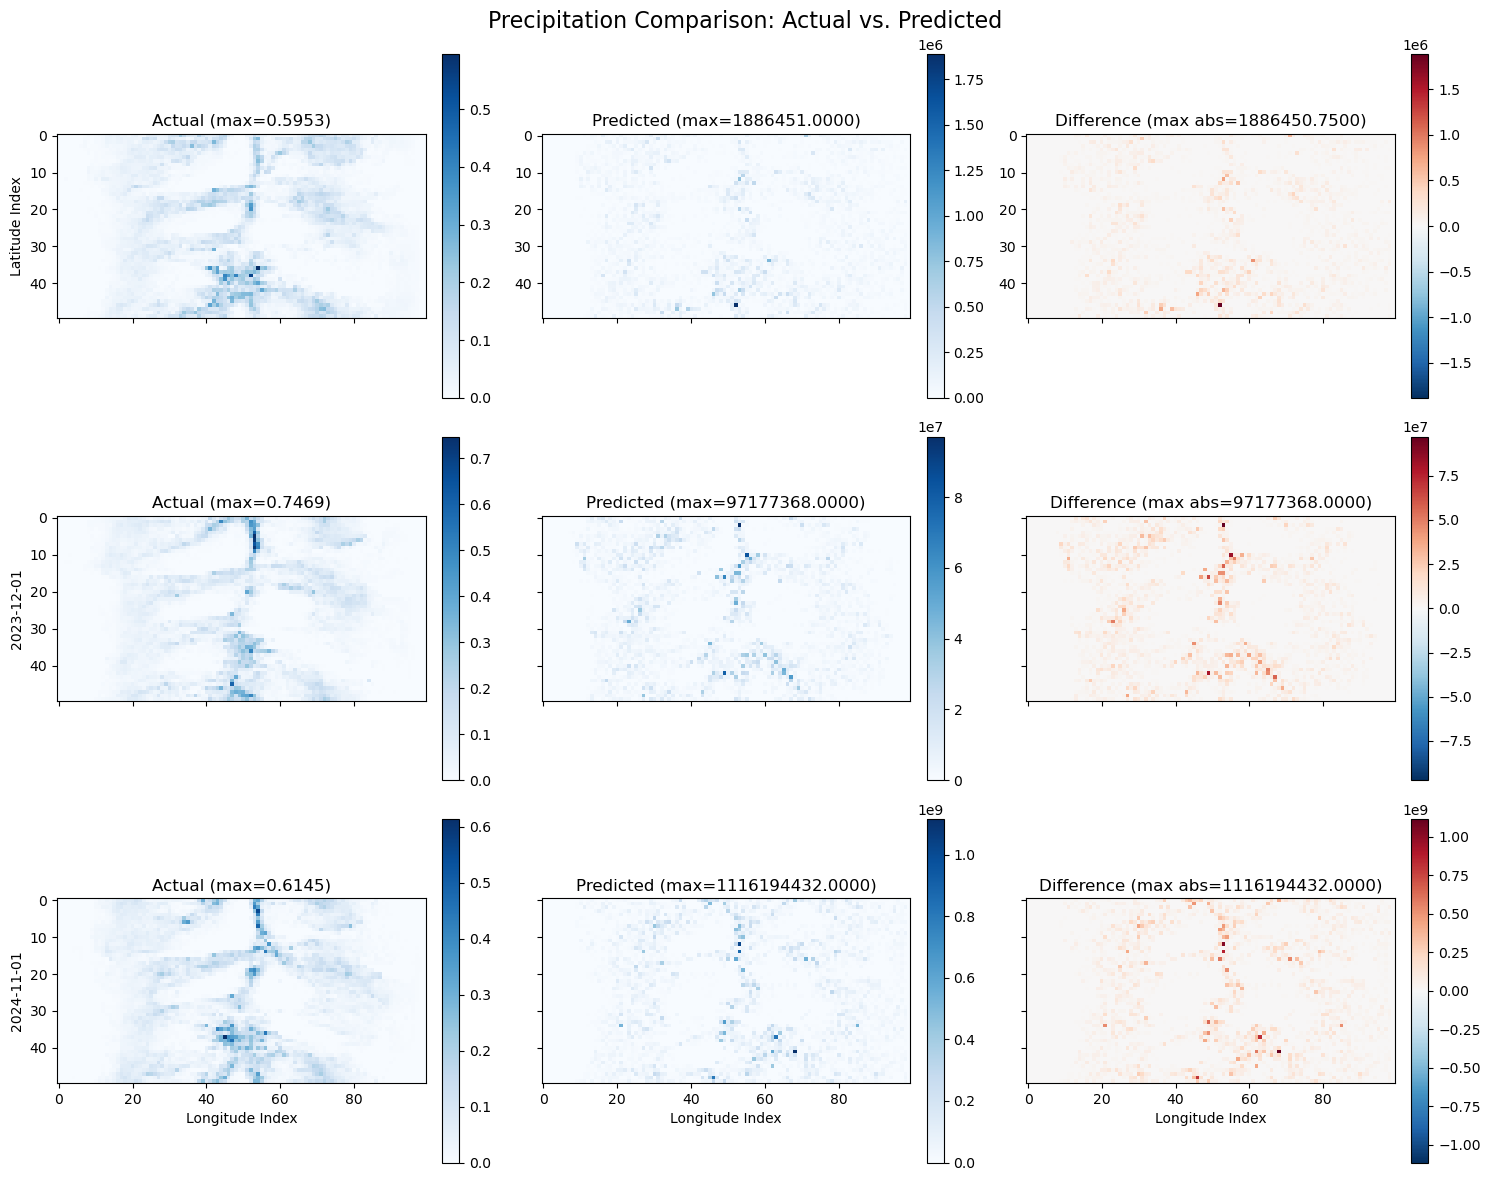

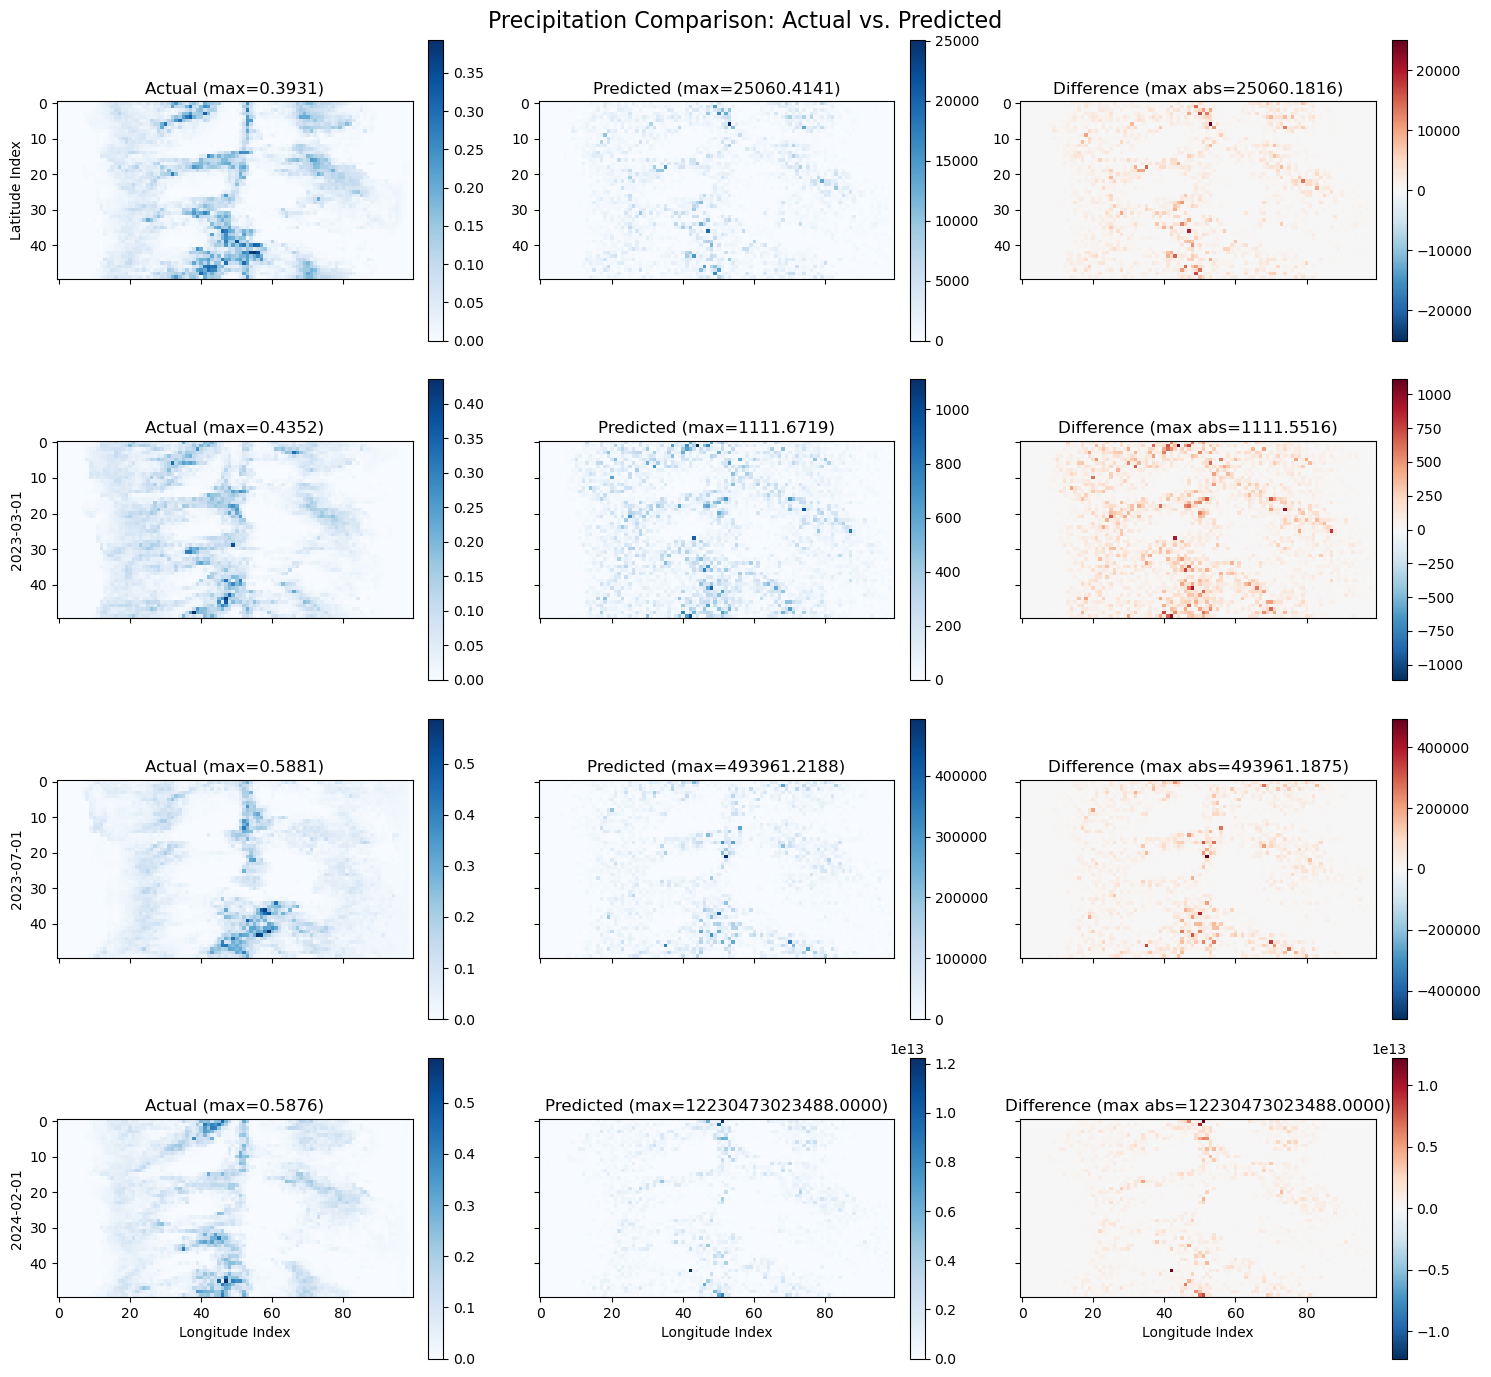

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
import xarray as xr

def plot_precipitation_comparison(ds_predictions, time_indices=None, num_samples=4, figure_size=(16, 12), 
                                 cmap='Blues', save_path=None):
    """
    Plot comparison between actual and predicted precipitation for selected time periods.
    
    Args:
        ds_predictions: xarray Dataset containing actual_precipitation and predicted_precipitation
        time_indices: Specific time indices to plot. If None, randomly sample from available times
        num_samples: Number of time samples to plot if time_indices is None
        figure_size: Size of the figure (width, height)
        cmap: Colormap to use for precipitation visualization
        save_path: Path to save the figure, if None, figure is displayed but not saved
        
    Returns:
        fig: Matplotlib figure object
    """
    # Get time dimension size
    time_dim = ds_predictions.dims['time']
    
    # Select time indices if not provided
    if time_indices is None:
        if num_samples >= time_dim:
            time_indices = list(range(time_dim))
        else:
            time_indices = sorted(random.sample(range(time_dim), num_samples))
    
    # Calculate number of rows and columns for subplots
    n_times = len(time_indices)
    n_cols = 3  # [Actual, Predicted, Difference]
    n_rows = n_times
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figure_size)
    
    # Loop through selected time indices
    for i, t_idx in enumerate(time_indices):
        # Get predicted and actual precipitation for this time
        pred = ds_predictions.predicted_precipitation.isel(time=t_idx)
        actual = ds_predictions.actual_precipitation.isel(time=t_idx)
        diff = ds_predictions.prediction_error.isel(time=t_idx)
        
        # Get time string
        time_str = np.datetime_as_string(ds_predictions.time.values[t_idx], unit='D')
        
        # Get axis for this row
        if n_rows == 1:
            ax_row = axes
        else:
            ax_row = axes[i]
        
        # Plot actual precipitation (with its own scale)
        vmax_actual = actual.max().item()
        im0 = ax_row[0].imshow(actual, cmap=cmap, vmin=0, vmax=vmax_actual, origin='upper')
        ax_row[0].set_title(f'Actual (max={vmax_actual:.4f})')
        plt.colorbar(im0, ax=ax_row[0], fraction=0.046, pad=0.04)
        
        # Plot predicted precipitation (with its own scale)
        vmax_pred = pred.max().item()
        im1 = ax_row[1].imshow(pred, cmap=cmap, vmin=0, vmax=vmax_pred, origin='upper')
        ax_row[1].set_title(f'Predicted (max={vmax_pred:.4f})')
        plt.colorbar(im1, ax=ax_row[1], fraction=0.046, pad=0.04)
        
        # Plot difference (with symmetric scale)
        vmax_diff = max(abs(diff.min().item()), abs(diff.max().item()))
        im2 = ax_row[2].imshow(diff, cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff, origin='upper')
        ax_row[2].set_title(f'Difference (max abs={vmax_diff:.4f})')
        plt.colorbar(im2, ax=ax_row[2], fraction=0.046, pad=0.04)
        
        # Add time label to the left
        ax_row[0].set_ylabel(time_str)
        
        # Only show x and y labels on bottom row
        if i == n_rows - 1:
            for j in range(n_cols):
                ax_row[j].set_xlabel('Longitude Index')
        else:
            for j in range(n_cols):
                ax_row[j].set_xticklabels([])
        
        # Only show y labels on first column
        if i == 0:
            ax_row[0].set_ylabel('Latitude Index')
        else:
            for j in range(1, n_cols):
                ax_row[j].set_yticklabels([])
    
    plt.suptitle('Precipitation Comparison: Actual vs. Predicted', fontsize=16)
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return fig

# Usage example:
# Select specific time indices (e.g., first, middle, and last time periods)
time_indices = [0, 12, 23]  # Assuming you have 24 time periods as shown in your dataset

# Create the comparison plot
fig = plot_precipitation_comparison(
    ds_predictions, 
    time_indices=time_indices,
    figure_size=(15, 12),
    cmap='Blues',
    save_path='precipitation_comparison.png'
)

# Alternative usage: randomly sample 4 time periods
fig = plot_precipitation_comparison(
    ds_predictions, 
    num_samples=4,
    figure_size=(15, 14),
    save_path='precipitation_random_comparison.png'
)

In [29]:
ds_predictions

<xarray.Dataset>
Dimensions:                  (time: 24, lat: 50, lon: 100)
Coordinates:
  * time                     (time) datetime64[ns] 2022-12-01 ... 2024-11-01
  * lat                      (lat) int32 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * lon                      (lon) int32 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    predicted_precipitation  (time, lat, lon) float32 0.005224 ... 0.01269
    actual_precipitation     (time, lat, lon) float32 0.0 0.0 ... 0.0001915 0.0
    prediction_error         (time, lat, lon) float32 0.005224 ... 0.01269
Attributes:
    description:  Super-resolution precipitation predictions and actual value...

# xVAE: only precipitation as input

## xVAE: use MSE for reconstruction error

X_train shape: (95, 10, 20, 1)
Y_train shape: (95, 50, 100)
X_test shape: (24, 10, 20, 1)
Y_test shape: (24, 50, 100)
Target shape: (50, 100)
Y_flat shape for NMF: (95, 5000)
Z_nmf shape: (95, 50)
omega shape: (50, 5000)
Epoch 1/50
4/6 [===================>..........] - ETA: 0s - loss: 4268160064.0000 - nll: 235058304.0000 - kl: 22814857216.0000

d:\anaconda\envs\dxtorch\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 [==============================] - 0s 39ms/step - loss: 6036298349.7143 - nll: 262978128.0000 - kl: 24301180928.0000 - val_loss: 1.2776 - val_nll: 0.8580 - val_kl: 0.4196
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 15528720530.2857 - nll: 190951936.0000 - kl: 19183073280.0000 - val_loss: 1.4029 - val_nll: 0.9220 - val_kl: 0.4809
Epoch 3/50
6/6 [==============================] - 0s 30ms/step - loss: 22236541805.7143 - nll: 206191424.0000 - kl: 20466698240.0000 - val_loss: 1.4349 - val_nll: 0.9298 - val_kl: 0.5051
Epoch 4/50
6/6 [==============================] - 0s 29ms/step - loss: 21820873874.2857 - nll: 235451008.0000 - kl: 21433653248.0000 - val_loss: 1.3197 - val_nll: 0.8125 - val_kl: 0.5072
Epoch 5/50
6/6 [==============================] - 0s 29ms/step - loss: 21277851062.8571 - nll: 233225648.0000 - kl: 21667258368.0000 - val_loss: 1.2903 - val_nll: 0.8090 - val_kl: 0.4813
Epoch 6/50
6/6 [==============================] - 0s 30ms/step - loss: 203264

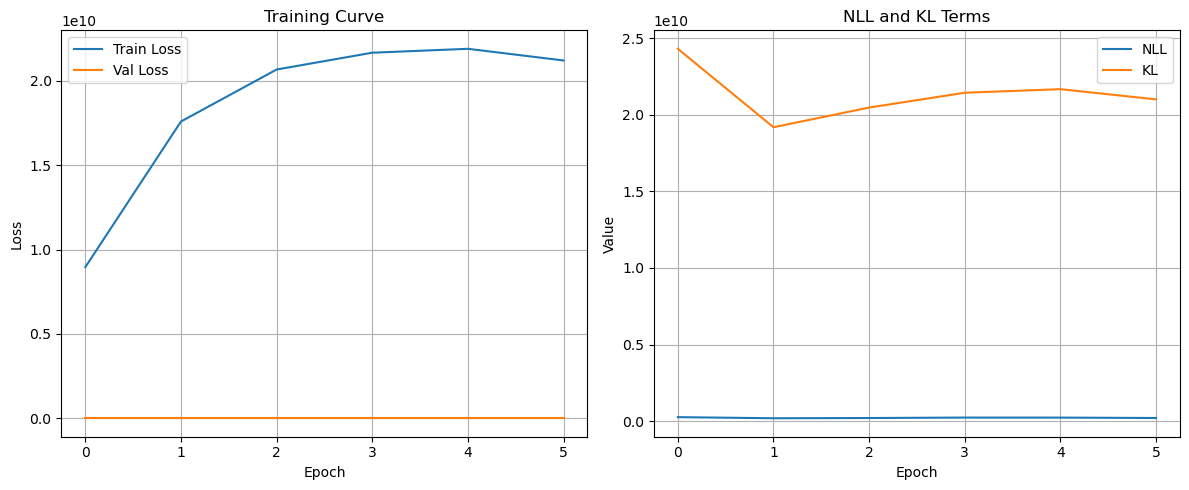

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


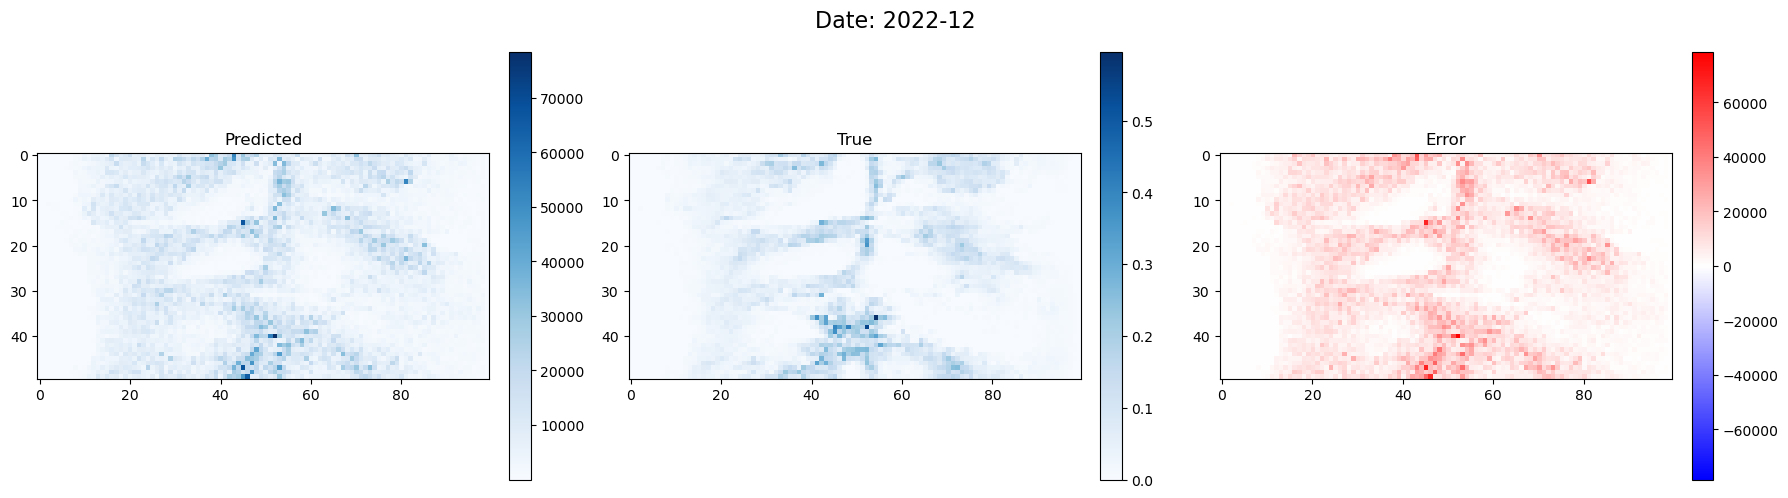

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


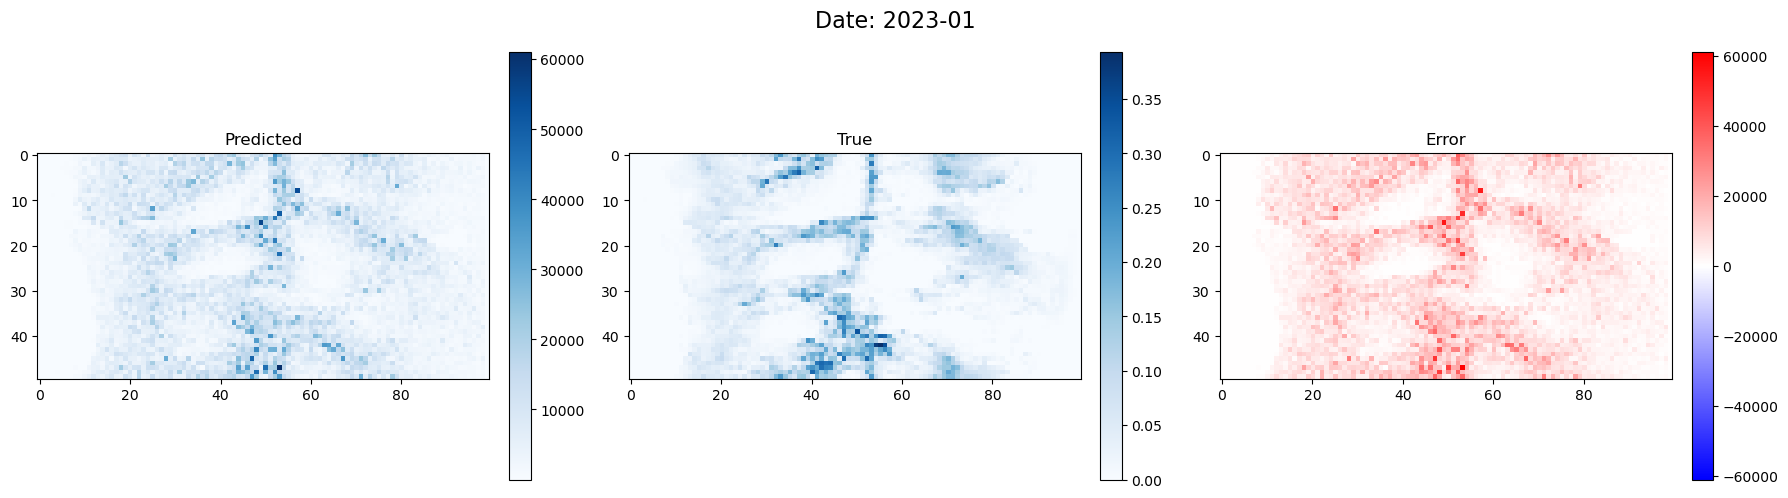

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


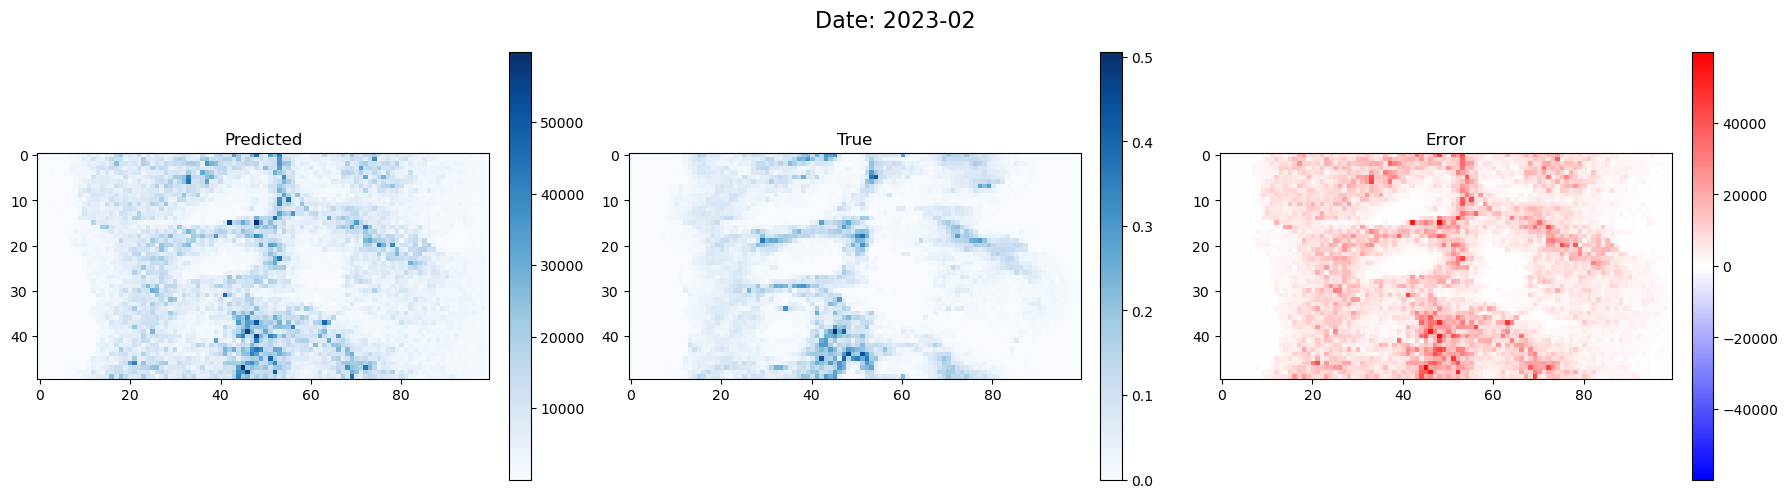

Overall RMSE: 8679.7138671875
No values below p=0.1 threshold
No values below p=0.05 threshold
No values below p=0.01 threshold


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, Model
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Non-negative Matrix Factorization for basis functions
# ------------------------------------------------------
def perform_nmf_decomposition(Y_train, n_components=50):
    """
    Perform NMF decomposition on training data
    
    Parameters:
    -----------
    Y_train : np.ndarray
        Training data for high resolution, shape (time, lat, lon, [channel])
    n_components : int
        Number of NMF components
        
    Returns:
    --------
    Z_nmf : np.ndarray
        NMF coefficients, shape (samples, n_components)
    omega : np.ndarray
        NMF components, shape (n_components, flat_features)
    Y_train_min : float
        Minimum value of Y_train (needed to make data non-negative)
    """
    # Ensure Y_train is non-negative for NMF
    Y_train_min = Y_train.min()
    Y_train_nmf_input = Y_train - Y_train_min  # Shift to make non-negative
    
    # Flatten to (samples, features) shape
    orig_shape = Y_train.shape
    if len(orig_shape) == 4:  # (samples, height, width, channels)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    else:  # (samples, height, width)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    
    print(f"Y_flat shape for NMF: {Y_flat.shape}")
    
    # Perform NMF decomposition
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
    Z_nmf = nmf.fit_transform(Y_flat)
    omega = nmf.components_  # shape: (n_components, features)
    
    print(f"Z_nmf shape: {Z_nmf.shape}")
    print(f"omega shape: {omega.shape}")
    
    return Z_nmf, omega, Y_train_min

# ------------------------------------------------------
# 2. xVAE Model Components
# ------------------------------------------------------

class Encoder(tf.keras.Model):
    """
    Encoder network for the xVAE
    Maps input data to latent space parameters (mu, log_zeta)
    """
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_net = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim * 2)  # Output mu and log_zeta
        ])
        
    def call(self, x):
        h = self.encoder_net(x)
        mu, log_zeta = tf.split(h, num_or_size_splits=2, axis=1)
        return mu, log_zeta

def sample_exp_ps(mu, log_zeta, alpha=0.5):
    """
    Sample from the exponentially-tilted positive stable distribution
    
    Parameters:
    -----------
    mu : tf.Tensor
        Location parameter
    log_zeta : tf.Tensor
        Log of scale parameter
    alpha : float
        Stability parameter (0 < alpha < 1)
        
    Returns:
    --------
    z : tf.Tensor
        Sampled values
    """
    # Generate gamma distribution samples
    eps = tf.random.gamma(shape=tf.shape(mu), alpha=alpha, beta=1.0)
    eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
    
    # Transform to exponentially-tilted positive stable distribution
    # When alpha = 0.5, -1/alpha = -2.0
    z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -1.0/alpha)
    return z

class MaxIDDecoder(tf.keras.Model):
    """
    Decoder network for the xVAE based on max-infinitely divisible process
    Maps latent variables to reconstructed data
    """
    def __init__(self, omega, alpha0, tau, target_shape):
        super(MaxIDDecoder, self).__init__()
        self.omega = tf.constant(omega, dtype=tf.float32)
        self.alpha0 = alpha0  # Fréchet noise parameter
        self.tau = tau        # Fréchet scale parameter
        self.target_shape = target_shape
        
    def call(self, z):
        # First, project latent variables using NMF basis
        raw = tf.matmul(z, self.omega)
        
        # Apply softplus to ensure positivity
        positive = tf.nn.softplus(raw)
        
        # Raise to power alpha0 (model equation 6 in the paper)
        Y = tf.pow(positive + 1e-6, self.alpha0)
        
        # Generate Fréchet noise (model equation 5 in the paper)
        epsilon = tf.random.gamma(shape=tf.shape(Y), alpha=self.alpha0)
        
        # Final output: -epsilon * Y (negative because we want to model low extremes)
        x_rec = Y * epsilon * self.tau
        
        # Get the batch size 
        batch_size = tf.shape(z)[0]
        
        # Check compatibility of dimensions
        total_elements = tf.size(x_rec)
        target_elements = np.prod(self.target_shape)
        expected_elements = batch_size * target_elements
        
        if total_elements != expected_elements:
            print(f"Dimension mismatch: {total_elements} vs {expected_elements}")
            
            # Calculate new dimensions that preserve the spatial shape as much as possible
            elements_per_sample = total_elements // batch_size
            
            if len(self.target_shape) == 3:  # (height, width, channels)
                width = self.target_shape[1]
                channels = self.target_shape[2]
                height = elements_per_sample // (width * channels)
                adjusted_shape = (height, width, channels)
            else:  # (height, width)
                width = self.target_shape[1]
                height = elements_per_sample // width
                adjusted_shape = (height, width)
            
            print(f"Adjusted shape: {adjusted_shape} (original: {self.target_shape})")
            return tf.reshape(x_rec, (batch_size,) + adjusted_shape)
        
        return tf.reshape(x_rec, (batch_size,) + self.target_shape)

class xVAE(tf.keras.Model):
    """
    Extreme Variational Autoencoder
    Combines encoder and decoder with KL divergence for extreme value modeling
    """
    def __init__(self, encoder, decoder, kl_annealing=False):
        super(xVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_annealing = kl_annealing
        
        # Metrics for tracking
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.nll_tracker = tf.keras.metrics.Mean(name="nll")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")
        self.epoch_counter = 0
        self.metrics_list = [self.total_loss_tracker, self.nll_tracker, self.kl_tracker]

    @property
    def metrics(self):
        return self.metrics_list

    def compile(self, optimizer, kl_max_weight=1.0, kl_warmup_epochs=10):
        super().compile()
        self.optimizer = optimizer
        self.kl_max_weight = kl_max_weight
        self.kl_warmup_epochs = kl_warmup_epochs

    def train_step(self, data):
        x, y = data
        self.epoch_counter += 1
        
        # Calculate KL weight for annealing
        kl_weight = min(self.epoch_counter / self.kl_warmup_epochs, 1.0) * self.kl_max_weight

        with tf.GradientTape() as tape:
            # Encode input to get mu and log_zeta
            mu, log_zeta = self.encoder(x)
            
            # Sample from exponentially-tilted positive stable distribution
            # Using alpha = 0.5 as in the paper
            eps = tf.random.gamma(shape=tf.shape(mu), alpha=0.5, beta=1.0)
            eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
            z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -2.0)  # alpha = 0.5 → -1/alpha = -2

            # Decode to get reconstruction
            x_rec = self.decoder(z)
            
            # Need to reshape y to match x_rec
            y_reshaped = tf.reshape(y, tf.shape(x_rec))
            
            # Calculate loss components
            # MSE loss for reconstruction
            nll = tf.reduce_mean(tf.square(x_rec - y_reshaped))
            
            # KL divergence for regularization
            # For expPS distribution, using a simpler approximation
            kl = tf.reduce_mean(0.5 * tf.square(z))
            
            # Total loss
            loss = nll + kl_weight * kl

        # Get gradients and update model parameters
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "nll": self.nll_tracker.result(), 
            "kl": self.kl_tracker.result()
        }

    def test_step(self, data):
        x, y = data
        
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = mu + tf.exp(0.5 * log_zeta) * tf.random.normal(tf.shape(mu))
        
        # Decode
        x_rec = self.decoder(z)
        
        # Reshape y to match x_rec
        y_reshaped = tf.reshape(y, tf.shape(x_rec))
        
        # Calculate loss components
        nll = tf.reduce_mean(tf.square(x_rec - y_reshaped))
        kl = tf.reduce_mean(0.5 * tf.square(z))
        loss = nll + kl

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)

        return {
            "loss": loss, 
            "nll": nll, 
            "kl": kl
        }
    
    def call(self, x):
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = sample_exp_ps(mu, log_zeta, alpha=0.5)
        
        # Decode
        return self.decoder(z)

# KL weight scheduler callback
class KLWeightScheduler(callbacks.Callback):
    """Callback to schedule KL weight during training"""
    def __init__(self, kl_weight_var, max_value, epochs):
        self.kl_weight = kl_weight_var
        self.max_value = max_value
        self.epochs = epochs
        
    def on_epoch_begin(self, epoch, logs=None):
        # Linear annealing of KL weight
        tf.keras.backend.set_value(self.kl_weight, self.max_value * epoch / self.epochs)

# ------------------------------------------------------
# 3. Data Preprocessing Functions
# ------------------------------------------------------

def preprocess_precipitation_data(low_res_data, high_res_data):
    """
    Preprocess precipitation data for xVAE model
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    
    Returns:
    --------
    X_train, X_test, Y_train, Y_test, Y_train_min, split_time
    """
    # Replace NaN with 0
    low_res = np.nan_to_num(low_res_data, nan=0.0)
    high_res = np.nan_to_num(high_res_data, nan=0.0)
    
    # Normalize data
    max_precip = np.max([low_res.max(), high_res.max()])
    low_res = low_res / max_precip
    high_res = high_res / max_precip
    
    # Add channel dimension if needed
    if low_res.ndim == 3:
        low_res = low_res[..., np.newaxis]  # shape (time, lat, lon, 1)
    
    # For high_res, we'll keep the original dimensions
    # This is a key fix - we don't add a channel dimension to high_res to ensure
    # compatibility with the model input/output
    
    # Split by time (80% train, 20% test)
    num_samples = low_res.shape[0]
    split_time = int(num_samples * 0.8)
    X_train, Y_train = low_res[:split_time], high_res[:split_time]
    X_test, Y_test = low_res[split_time:], high_res[split_time:]
    
    # Get minimum value of Y_train for later denormalization
    Y_train_min = Y_train.min()
    
    # Print shapes for debugging
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")
    
    return X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time

# ------------------------------------------------------
# 4. Visualization and Evaluation Functions
# ------------------------------------------------------

def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array=None, split_time=None):
    """
    Visualize prediction comparison for a single sample
    
    Parameters:
    -----------
    index : int
        Index of the sample to visualize
    preds_actual : np.ndarray
        Predicted values (after denormalization)
    y_test_actual : np.ndarray
        True values (after denormalization)
    time_array : np.ndarray, optional
        Array of time values for labeling plots
    split_time : int, optional
        Index where test set begins
    """
    if index >= len(preds_actual) or index >= len(y_test_actual):
        print(f"Index {index} out of range. preds_actual length: {len(preds_actual)}, y_test_actual length: {len(y_test_actual)}")
        return
    
    # Get prediction and ground truth
    pred = preds_actual[index]
    truth = y_test_actual[index]
    
    # Remove unnecessary singleton dimensions if any
    if pred.ndim > 2:
        pred = np.squeeze(pred)
    if truth.ndim > 2:
        truth = np.squeeze(truth)
    
    # Print shapes for debugging
    print(f"Pred shape after squeeze: {pred.shape}")
    print(f"Truth shape after squeeze: {truth.shape}")
    
    # If prediction and ground truth have different shapes, resize prediction
    if pred.shape != truth.shape:
        print(f"Warning: Shape mismatch. Resizing prediction to match ground truth.")
        # Simple resize - could be improved with interpolation
        from scipy.ndimage import zoom
        
        # Calculate zoom factors
        zoom_factors = [ts/ps for ts, ps in zip(truth.shape, pred.shape)]
        pred_resized = zoom(pred, zoom_factors)
        pred = pred_resized
        print(f"Resized pred shape: {pred.shape}")
    
    # Calculate error
    error = pred - truth
    
    # Get time string if available
    time_str = ""
    if time_array is not None and split_time is not None and (split_time + index) < len(time_array):
        try:
            time_str = np.datetime_as_string(time_array[split_time + index], unit='M')
        except:
            time_str = f"Sample {index}"
    else:
        time_str = f"Sample {index}"
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im0 = axes[0].imshow(pred, cmap='Blues')
    axes[0].set_title(f"Predicted")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(truth, cmap='Blues')
    axes[1].set_title(f"True")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    im2 = axes[2].imshow(error, cmap='bwr', 
                       vmin=-np.max(np.abs(error)), 
                       vmax=np.max(np.abs(error)))
    axes[2].set_title("Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Date: {time_str}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to calculate tail RMSE
def calculate_tail_rmse(predictions, ground_truth, p=0.05):
    """
    Calculate RMSE for values below a quantile threshold
    
    Parameters:
    -----------
    predictions : np.ndarray
        Predicted values
    ground_truth : np.ndarray
        True values
    p : float
        Quantile threshold (0 < p < 1)
        
    Returns:
    --------
    tail_rmse : float
        RMSE for values below threshold
    """
    # Reshape if needed
    if predictions.shape != ground_truth.shape:
        from scipy.ndimage import zoom
        
        # Calculate zoom factors for each spatial dimension
        zoom_factors = [gs/ps for gs, ps in zip(ground_truth.shape, predictions.shape)]
        
        # We keep the batch dimension as is
        if len(zoom_factors) >= 3:  # Handle batch dimension
            zoom_factors = [1] + zoom_factors[1:]
            
        # Resize predictions to match ground truth
        predictions_resized = zoom(predictions, zoom_factors)
        predictions = predictions_resized
    
    # Find threshold
    threshold = np.quantile(ground_truth, p)
    
    # Create mask for values below threshold
    mask = ground_truth < threshold
    
    # Check if there are any values below threshold
    if np.sum(mask) == 0:
        print(f"No values below p={p} threshold")
        return None
    
    # Calculate RMSE for values below threshold
    tail_rmse = np.sqrt(np.mean((predictions[mask] - ground_truth[mask])**2))
    
    return tail_rmse

# ------------------------------------------------------
# 5. Main Function to Run the xVAE Model
# ------------------------------------------------------

def run_xvae_model(low_res_data, high_res_data, latent_dim=50,
                  epochs=50, batch_size=16, time_array=None):
    """
    Run the complete xVAE pipeline for precipitation super-resolution
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    latent_dim : int, optional
        Latent dimension for the VAE
    epochs : int, optional
        Number of training epochs
    batch_size : int, optional
        Batch size for training
    time_array : np.ndarray, optional
        Array of time values for visualization
        
    Returns:
    --------
    model : xVAE
        Trained model
    history : tf.keras.callbacks.History
        Training history
    predictions : np.ndarray
        Model predictions
    ground_truth : np.ndarray
        Ground truth data
    """
    # Set TensorFlow to eager execution for better debugging
    tf.config.run_functions_eagerly(True)
    
    # 1. Preprocess data
    X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time = preprocess_precipitation_data(
        low_res_data, high_res_data
    )
    
    # 2. Get target shape for decoder output
    # Using Y_train shape directly to ensure dimensions match
    target_shape = Y_train.shape[1:]  # (height, width) or (height, width, channels)
    print(f"Target shape: {target_shape}")
    
    # 3. Perform NMF decomposition to get basis functions
    _, omega, _ = perform_nmf_decomposition(Y_train, n_components=latent_dim)
    
    # 4. Ensure omega shape is compatible with target shape
    flat_size = np.prod(target_shape)
    if omega.shape[1] != flat_size:
        print(f"Warning: Omega shape {omega.shape[1]} doesn't match target shape flat size {flat_size}")
        
        # Two options:
        # 1. Adjust target shape to match omega (keeping spatial dimensions as close as possible)
        # 2. Adjust omega to match target shape (requires re-running NMF with constraints)
        
        # We'll go with option 1 for simplicity
        width = target_shape[-1]  # Last dimension (width)
        if len(target_shape) == 3:  # (height, width, channels)
            channels = target_shape[-1]
            width = target_shape[-2]
            height = omega.shape[1] // (width * channels)
            target_shape = (height, width, channels)
        else:  # (height, width)
            height = omega.shape[1] // width
            target_shape = (height, width)
        
        print(f"Adjusted target shape to: {target_shape}")
    
    # 5. Build xVAE model
    encoder = Encoder(latent_dim=latent_dim)
    decoder = MaxIDDecoder(omega=omega, alpha0=0.8, tau=1.0, target_shape=target_shape)
    model = xVAE(encoder, decoder, kl_annealing=True)
    model.compile(optimizer=optimizers.Adam(1e-4), kl_max_weight=1.0, kl_warmup_epochs=10)
    
    # 6. Train model with a callback for early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 7. Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["nll"], label="NLL")
    plt.plot(history.history["kl"], label="KL")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("NLL and KL Terms")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    # 8. Generate predictions - multiple samples for uncertainty
    n_samples = 10
    all_predictions = []
    
    for _ in range(n_samples):
        mu_test, log_zeta_test = model.encoder(X_test)
        z_test = sample_exp_ps(mu_test, log_zeta_test, alpha=0.5)
        x_rec_test = model.decoder(z_test)
        all_predictions.append(x_rec_test.numpy())
    
    # Average the samples for the final prediction
    preds_mean = np.mean(all_predictions, axis=0)
    
    # 9. Denormalize predictions
    preds_actual = preds_mean + Y_train_min
    preds_actual = np.maximum(preds_actual, 0)  # Clip negative values to 0
    
    # 10. Denormalize ground truth
    y_test_actual = Y_test + Y_train_min
    
    # 11. Visualize samples and calculate metrics
    for i in range(min(3, len(X_test))):
        plot_prediction_comparison(i, preds_actual, y_test_actual, time_array, split_time)
    
    # 12. Calculate and print metrics for different tail quantiles
    metrics = {}
    
    # Overall RMSE
    overall_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=1.0)
    metrics["overall_rmse"] = overall_rmse
    print(f"Overall RMSE: {overall_rmse}")
    
    # Tail RMSEs
    for p in [0.1, 0.05, 0.01]:
        tail_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=p)
        if tail_rmse is not None:
            metrics[f"tail_rmse_{p}"] = tail_rmse
            print(f"Tail RMSE (p={p}): {tail_rmse}")
    
    return model, history, preds_actual, y_test_actual, metrics

# Example usage with real data

# Run the xVAE model on real data
model, history, predictions, ground_truth, metrics = run_xvae_model(
    combined005["precipitation"].values,  # Low-res data
    combined001["precipitation"].values,  # High-res data
    latent_dim=50,
    epochs=50,
    batch_size=16,
    time_array=combined005.time.values
)


## xVAE: use Fréchet log-likelihood instead of MSE(similar as paper)

X_train shape: (95, 10, 20, 1)
Y_train shape: (95, 50, 100)
X_test shape: (24, 10, 20, 1)
Y_test shape: (24, 50, 100)
Target shape: (50, 100)
Y_flat shape for NMF: (95, 5000)
Z_nmf shape: (95, 50)
omega shape: (50, 5000)
Epoch 1/50
1/6 [====>.........................] - ETA: 0s - loss: 2389145088.0000 - nll: -8501.5000 - kl: 23891533824.0000

d:\anaconda\envs\dxtorch\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 [==============================] - 0s 38ms/step - loss: 4902699556.5714 - nll: -8465.1631 - kl: 20236335104.0000 - val_loss: 1.3975 - val_nll: 0.8505 - val_kl: 0.5470
Epoch 2/50
6/6 [==============================] - 0s 29ms/step - loss: 17300424850.2857 - nll: -8467.7920 - kl: 20670832640.0000 - val_loss: 1.3603 - val_nll: 0.9010 - val_kl: 0.4593
Epoch 3/50
6/6 [==============================] - 0s 30ms/step - loss: 22586644480.0000 - nll: -8468.0693 - kl: 22623946752.0000 - val_loss: 1.2976 - val_nll: 0.7845 - val_kl: 0.5131
Epoch 4/50
6/6 [==============================] - 0s 29ms/step - loss: 21220763355.4286 - nll: -8467.1455 - kl: 21750953984.0000 - val_loss: 1.5075 - val_nll: 0.9737 - val_kl: 0.5338
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 19771186907.4286 - nll: -8465.8799 - kl: 19268476928.0000 - val_loss: 1.4116 - val_nll: 0.9593 - val_kl: 0.4523
Epoch 6/50
6/6 [==============================] - 0s 30ms/step - loss: 19001807725.7143 - nll: -8

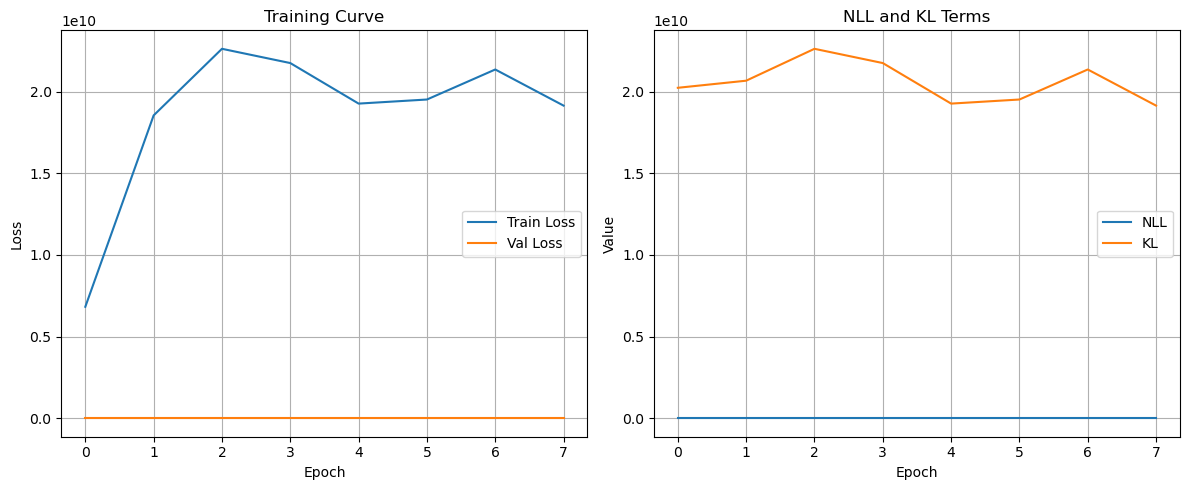

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


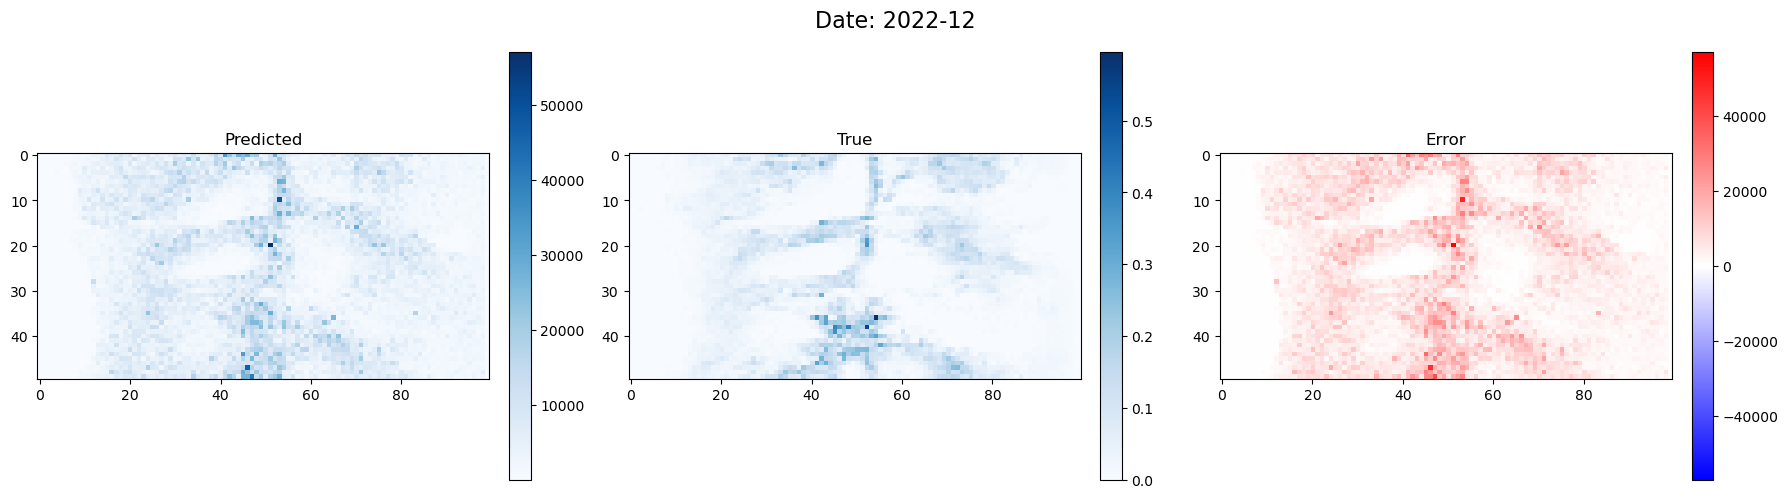

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


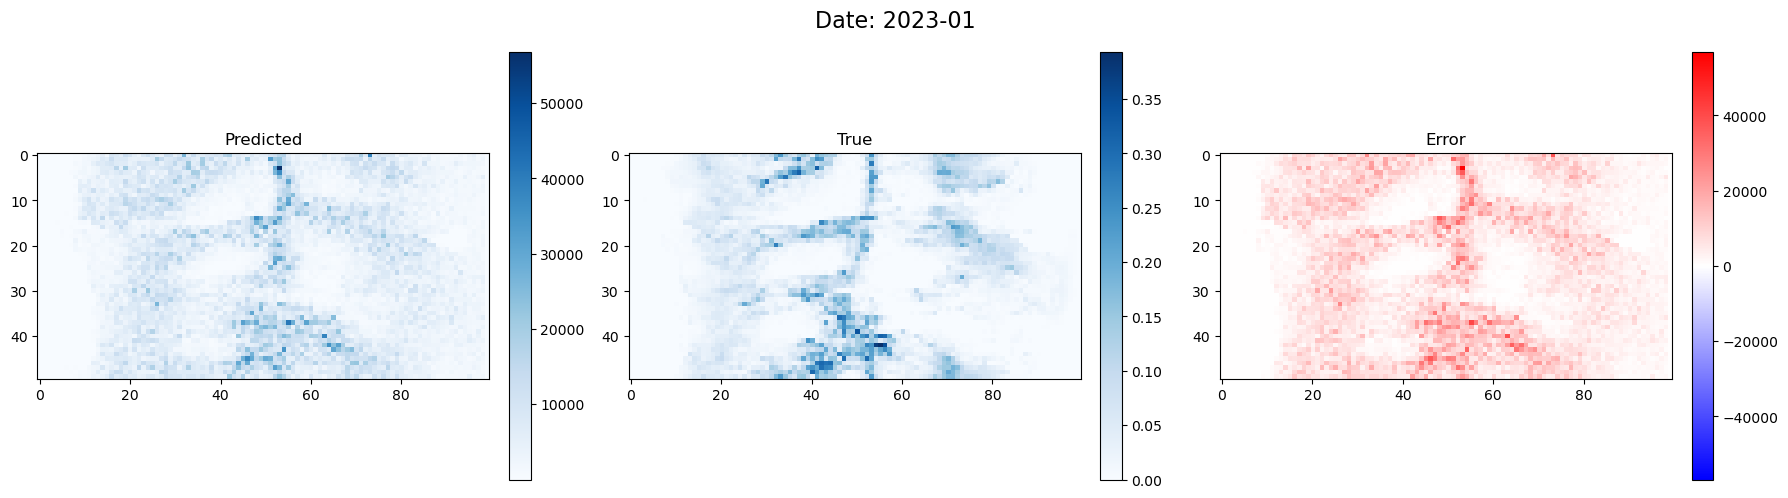

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


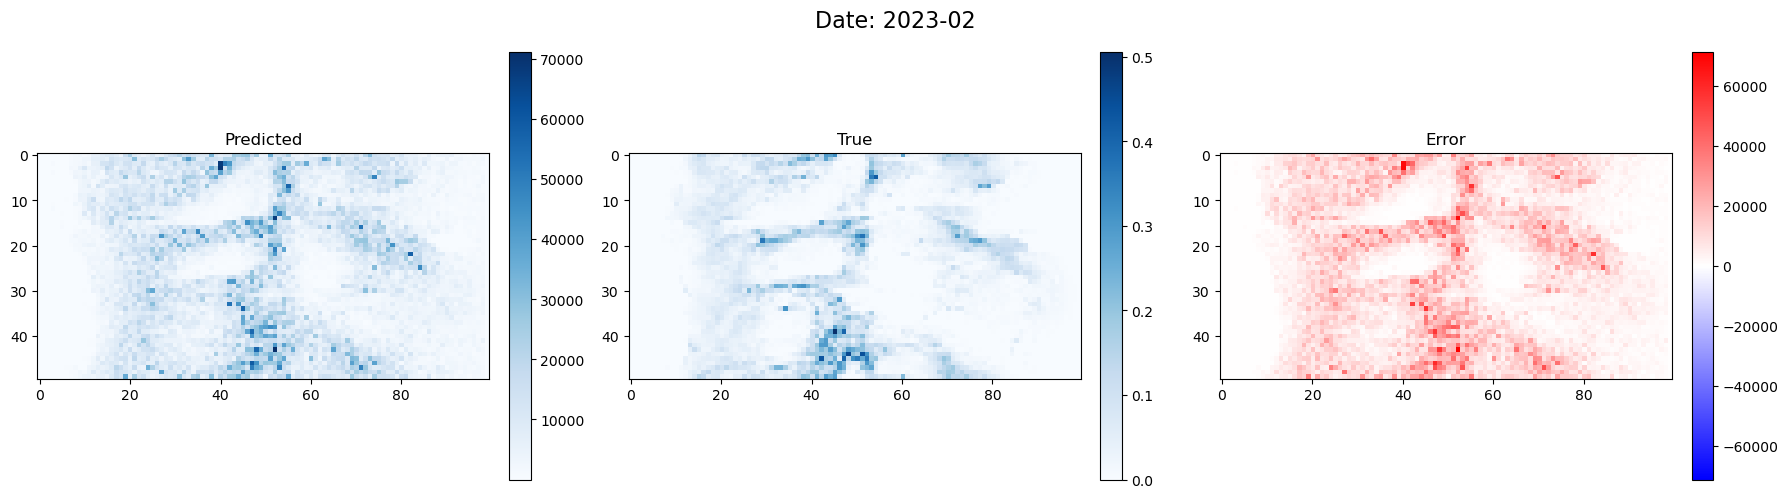

Overall RMSE: 8373.810546875
No values below p=0.1 threshold
No values below p=0.05 threshold
No values below p=0.01 threshold


In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, Model
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Non-negative Matrix Factorization for basis functions
# ------------------------------------------------------
def perform_nmf_decomposition(Y_train, n_components=50):
    """
    Perform NMF decomposition on training data
    
    Parameters:
    -----------
    Y_train : np.ndarray
        Training data for high resolution, shape (time, lat, lon, [channel])
    n_components : int
        Number of NMF components
        
    Returns:
    --------
    Z_nmf : np.ndarray
        NMF coefficients, shape (samples, n_components)
    omega : np.ndarray
        NMF components, shape (n_components, flat_features)
    Y_train_min : float
        Minimum value of Y_train (needed to make data non-negative)
    """
    # Ensure Y_train is non-negative for NMF
    Y_train_min = Y_train.min()
    Y_train_nmf_input = Y_train - Y_train_min  # Shift to make non-negative
    
    # Flatten to (samples, features) shape
    orig_shape = Y_train.shape
    if len(orig_shape) == 4:  # (samples, height, width, channels)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    else:  # (samples, height, width)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    
    print(f"Y_flat shape for NMF: {Y_flat.shape}")
    
    # Perform NMF decomposition
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
    Z_nmf = nmf.fit_transform(Y_flat)
    omega = nmf.components_  # shape: (n_components, features)
    
    print(f"Z_nmf shape: {Z_nmf.shape}")
    print(f"omega shape: {omega.shape}")
    
    return Z_nmf, omega, Y_train_min

# ------------------------------------------------------
# 2. xVAE Model Components
# ------------------------------------------------------

class Encoder(tf.keras.Model):
    """
    Encoder network for the xVAE
    Maps input data to latent space parameters (mu, log_zeta)
    """
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_net = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim * 2)  # Output mu and log_zeta
        ])
        
    def call(self, x):
        h = self.encoder_net(x)
        mu, log_zeta = tf.split(h, num_or_size_splits=2, axis=1)
        return mu, log_zeta

def sample_exp_ps(mu, log_zeta, alpha=0.5):
    """
    Sample from the exponentially-tilted positive stable distribution
    
    Parameters:
    -----------
    mu : tf.Tensor
        Location parameter
    log_zeta : tf.Tensor
        Log of scale parameter
    alpha : float
        Stability parameter (0 < alpha < 1)
        
    Returns:
    --------
    z : tf.Tensor
        Sampled values
    """
    # Generate gamma distribution samples
    eps = tf.random.gamma(shape=tf.shape(mu), alpha=alpha, beta=1.0)
    eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
    
    # Transform to exponentially-tilted positive stable distribution
    # When alpha = 0.5, -1/alpha = -2.0
    z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -1.0/alpha)
    return z

class MaxIDDecoder(tf.keras.Model):
    """
    Decoder network for the xVAE based on max-infinitely divisible process
    Maps latent variables to reconstructed data
    """
    def __init__(self, omega, alpha0, tau, target_shape):
        super(MaxIDDecoder, self).__init__()
        self.omega = tf.constant(omega, dtype=tf.float32)
        self.alpha0 = alpha0  # Fréchet noise parameter
        self.tau = tau        # Fréchet scale parameter
        self.target_shape = target_shape
        
    def call(self, z):
        # First, project latent variables using NMF basis
        raw = tf.matmul(z, self.omega)
        
        # Apply softplus to ensure positivity
        positive = tf.nn.softplus(raw)
        
        # Raise to power alpha0 (model equation 6 in the paper)
        Y = tf.pow(positive + 1e-6, self.alpha0)
        
        # Generate Fréchet noise (model equation 5 in the paper)
        epsilon = tf.random.gamma(shape=tf.shape(Y), alpha=self.alpha0)
        
        # Final output: -epsilon * Y (negative because we want to model low extremes)
        x_rec = Y * epsilon * self.tau
        
        # Get the batch size 
        batch_size = tf.shape(z)[0]
        
        # Check compatibility of dimensions
        total_elements = tf.size(x_rec)
        target_elements = np.prod(self.target_shape)
        expected_elements = batch_size * target_elements
        
        if total_elements != expected_elements:
            print(f"Dimension mismatch: {total_elements} vs {expected_elements}")
            
            # Calculate new dimensions that preserve the spatial shape as much as possible
            elements_per_sample = total_elements // batch_size
            
            if len(self.target_shape) == 3:  # (height, width, channels)
                width = self.target_shape[1]
                channels = self.target_shape[2]
                height = elements_per_sample // (width * channels)
                adjusted_shape = (height, width, channels)
            else:  # (height, width)
                width = self.target_shape[1]
                height = elements_per_sample // width
                adjusted_shape = (height, width)
            
            print(f"Adjusted shape: {adjusted_shape} (original: {self.target_shape})")
            return tf.reshape(x_rec, (batch_size,) + adjusted_shape)
        
        return tf.reshape(x_rec, (batch_size,) + self.target_shape)

class xVAE(tf.keras.Model):
    """
    Extreme Variational Autoencoder
    Combines encoder and decoder with KL divergence for extreme value modeling
    """
    def __init__(self, encoder, decoder, kl_annealing=False):
        super(xVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_annealing = kl_annealing
        
        # Metrics for tracking
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.nll_tracker = tf.keras.metrics.Mean(name="nll")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")
        self.epoch_counter = 0
        self.metrics_list = [self.total_loss_tracker, self.nll_tracker, self.kl_tracker]

    @property
    def metrics(self):
        return self.metrics_list

    def log_frechet_likelihood(self, y, Y, alpha, tau):
        """
        Compute negative log-likelihood under Fréchet distribution.
        y : target
        Y : deterministic part (i.e., output of decoder before noise)
        alpha, tau : Fréchet parameters
        """
        y = tf.maximum(y, 1e-6)
        return tf.reduce_mean(
            -tf.math.log(alpha + 1e-6)
            - (alpha + 1) * tf.math.log(y)
            - tf.pow(tau / y, alpha)
        )

    def compile(self, optimizer, kl_max_weight=1.0, kl_warmup_epochs=10):
        super().compile()
        self.optimizer = optimizer
        self.kl_max_weight = kl_max_weight
        self.kl_warmup_epochs = kl_warmup_epochs

    def train_step(self, data):
        x, y = data
        self.epoch_counter += 1
        
        # Calculate KL weight for annealing
        kl_weight = min(self.epoch_counter / self.kl_warmup_epochs, 1.0) * self.kl_max_weight

        with tf.GradientTape() as tape:
            # Encode input to get mu and log_zeta
            mu, log_zeta = self.encoder(x)
            
            # Sample from exponentially-tilted positive stable distribution
            # Using alpha = 0.5 as in the paper
            eps = tf.random.gamma(shape=tf.shape(mu), alpha=0.5, beta=1.0)
            eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
            z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -2.0)  # alpha = 0.5 → -1/alpha = -2

            # Decode to get reconstruction
            x_rec = self.decoder(z)
            
            # Need to reshape y to match x_rec
            y_reshaped = tf.reshape(y, tf.shape(x_rec))
            
            # Calculate loss components
            # MSE loss for reconstruction
            nll = self.log_frechet_likelihood(y_reshaped, x_rec, alpha=self.decoder.alpha0, tau=self.decoder.tau)

            
            # KL divergence for regularization
            # For expPS distribution, using a simpler approximation
            kl = tf.reduce_mean(0.5 * tf.square(z))
            
            # Total loss
            loss = nll + kl_weight * kl

        # Get gradients and update model parameters
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "nll": self.nll_tracker.result(), 
            "kl": self.kl_tracker.result()
        }

    def test_step(self, data):
        x, y = data
        
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = mu + tf.exp(0.5 * log_zeta) * tf.random.normal(tf.shape(mu))
        
        # Decode
        x_rec = self.decoder(z)
        
        # Reshape y to match x_rec
        y_reshaped = tf.reshape(y, tf.shape(x_rec))
        
        # Calculate loss components
        nll = tf.reduce_mean(tf.square(x_rec - y_reshaped))
        kl = tf.reduce_mean(0.5 * tf.square(z))
        loss = nll + kl

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)

        return {
            "loss": loss, 
            "nll": nll, 
            "kl": kl
        }
    
    def call(self, x):
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = sample_exp_ps(mu, log_zeta, alpha=0.5)
        
        # Decode
        return self.decoder(z)

# KL weight scheduler callback
class KLWeightScheduler(callbacks.Callback):
    """Callback to schedule KL weight during training"""
    def __init__(self, kl_weight_var, max_value, epochs):
        self.kl_weight = kl_weight_var
        self.max_value = max_value
        self.epochs = epochs
        
    def on_epoch_begin(self, epoch, logs=None):
        # Linear annealing of KL weight
        tf.keras.backend.set_value(self.kl_weight, self.max_value * epoch / self.epochs)

# ------------------------------------------------------
# 3. Data Preprocessing Functions
# ------------------------------------------------------

def preprocess_precipitation_data(low_res_data, high_res_data):
    """
    Preprocess precipitation data for xVAE model
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    
    Returns:
    --------
    X_train, X_test, Y_train, Y_test, Y_train_min, split_time
    """
    # Replace NaN with 0
    low_res = np.nan_to_num(low_res_data, nan=0.0)
    high_res = np.nan_to_num(high_res_data, nan=0.0)
    
    # Normalize data
    max_precip = np.max([low_res.max(), high_res.max()])
    low_res = low_res / max_precip
    high_res = high_res / max_precip
    
    # Add channel dimension if needed
    if low_res.ndim == 3:
        low_res = low_res[..., np.newaxis]  # shape (time, lat, lon, 1)
    
    # For high_res, we'll keep the original dimensions
    # This is a key fix - we don't add a channel dimension to high_res to ensure
    # compatibility with the model input/output
    
    # Split by time (80% train, 20% test)
    num_samples = low_res.shape[0]
    split_time = int(num_samples * 0.8)
    X_train, Y_train = low_res[:split_time], high_res[:split_time]
    X_test, Y_test = low_res[split_time:], high_res[split_time:]
    
    # Get minimum value of Y_train for later denormalization
    Y_train_min = Y_train.min()
    
    # Print shapes for debugging
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")
    
    return X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time

# ------------------------------------------------------
# 4. Visualization and Evaluation Functions
# ------------------------------------------------------

def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array=None, split_time=None):
    """
    Visualize prediction comparison for a single sample
    
    Parameters:
    -----------
    index : int
        Index of the sample to visualize
    preds_actual : np.ndarray
        Predicted values (after denormalization)
    y_test_actual : np.ndarray
        True values (after denormalization)
    time_array : np.ndarray, optional
        Array of time values for labeling plots
    split_time : int, optional
        Index where test set begins
    """
    if index >= len(preds_actual) or index >= len(y_test_actual):
        print(f"Index {index} out of range. preds_actual length: {len(preds_actual)}, y_test_actual length: {len(y_test_actual)}")
        return
    
    # Get prediction and ground truth
    pred = preds_actual[index]
    truth = y_test_actual[index]
    
    # Remove unnecessary singleton dimensions if any
    if pred.ndim > 2:
        pred = np.squeeze(pred)
    if truth.ndim > 2:
        truth = np.squeeze(truth)
    
    # Print shapes for debugging
    print(f"Pred shape after squeeze: {pred.shape}")
    print(f"Truth shape after squeeze: {truth.shape}")
    
    # If prediction and ground truth have different shapes, resize prediction
    if pred.shape != truth.shape:
        print(f"Warning: Shape mismatch. Resizing prediction to match ground truth.")
        # Simple resize - could be improved with interpolation
        from scipy.ndimage import zoom
        
        # Calculate zoom factors
        zoom_factors = [ts/ps for ts, ps in zip(truth.shape, pred.shape)]
        pred_resized = zoom(pred, zoom_factors)
        pred = pred_resized
        print(f"Resized pred shape: {pred.shape}")
    
    # Calculate error
    error = pred - truth
    
    # Get time string if available
    time_str = ""
    if time_array is not None and split_time is not None and (split_time + index) < len(time_array):
        try:
            time_str = np.datetime_as_string(time_array[split_time + index], unit='M')
        except:
            time_str = f"Sample {index}"
    else:
        time_str = f"Sample {index}"
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im0 = axes[0].imshow(pred, cmap='Blues')
    axes[0].set_title(f"Predicted")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(truth, cmap='Blues')
    axes[1].set_title(f"True")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    im2 = axes[2].imshow(error, cmap='bwr', 
                       vmin=-np.max(np.abs(error)), 
                       vmax=np.max(np.abs(error)))
    axes[2].set_title("Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Date: {time_str}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to calculate tail RMSE
def calculate_tail_rmse(predictions, ground_truth, p=0.05):
    """
    Calculate RMSE for values below a quantile threshold
    
    Parameters:
    -----------
    predictions : np.ndarray
        Predicted values
    ground_truth : np.ndarray
        True values
    p : float
        Quantile threshold (0 < p < 1)
        
    Returns:
    --------
    tail_rmse : float
        RMSE for values below threshold
    """
    # Reshape if needed
    if predictions.shape != ground_truth.shape:
        from scipy.ndimage import zoom
        
        # Calculate zoom factors for each spatial dimension
        zoom_factors = [gs/ps for gs, ps in zip(ground_truth.shape, predictions.shape)]
        
        # We keep the batch dimension as is
        if len(zoom_factors) >= 3:  # Handle batch dimension
            zoom_factors = [1] + zoom_factors[1:]
            
        # Resize predictions to match ground truth
        predictions_resized = zoom(predictions, zoom_factors)
        predictions = predictions_resized
    
    # Find threshold
    threshold = np.quantile(ground_truth, p)
    
    # Create mask for values below threshold
    mask = ground_truth < threshold
    
    # Check if there are any values below threshold
    if np.sum(mask) == 0:
        print(f"No values below p={p} threshold")
        return None
    
    # Calculate RMSE for values below threshold
    tail_rmse = np.sqrt(np.mean((predictions[mask] - ground_truth[mask])**2))
    
    return tail_rmse

# ------------------------------------------------------
# 5. Main Function to Run the xVAE Model
# ------------------------------------------------------

def run_xvae_model(low_res_data, high_res_data, latent_dim=50,
                  epochs=50, batch_size=16, time_array=None):
    """
    Run the complete xVAE pipeline for precipitation super-resolution
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    latent_dim : int, optional
        Latent dimension for the VAE
    epochs : int, optional
        Number of training epochs
    batch_size : int, optional
        Batch size for training
    time_array : np.ndarray, optional
        Array of time values for visualization
        
    Returns:
    --------
    model : xVAE
        Trained model
    history : tf.keras.callbacks.History
        Training history
    predictions : np.ndarray
        Model predictions
    ground_truth : np.ndarray
        Ground truth data
    """
    # Set TensorFlow to eager execution for better debugging
    tf.config.run_functions_eagerly(True)
    
    # 1. Preprocess data
    X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time = preprocess_precipitation_data(
        low_res_data, high_res_data
    )
    
    # 2. Get target shape for decoder output
    # Using Y_train shape directly to ensure dimensions match
    target_shape = Y_train.shape[1:]  # (height, width) or (height, width, channels)
    print(f"Target shape: {target_shape}")
    
    # 3. Perform NMF decomposition to get basis functions
    _, omega, _ = perform_nmf_decomposition(Y_train, n_components=latent_dim)
    
    # 4. Ensure omega shape is compatible with target shape
    flat_size = np.prod(target_shape)
    if omega.shape[1] != flat_size:
        print(f"Warning: Omega shape {omega.shape[1]} doesn't match target shape flat size {flat_size}")
        
        # Two options:
        # 1. Adjust target shape to match omega (keeping spatial dimensions as close as possible)
        # 2. Adjust omega to match target shape (requires re-running NMF with constraints)
        
        # We'll go with option 1 for simplicity
        width = target_shape[-1]  # Last dimension (width)
        if len(target_shape) == 3:  # (height, width, channels)
            channels = target_shape[-1]
            width = target_shape[-2]
            height = omega.shape[1] // (width * channels)
            target_shape = (height, width, channels)
        else:  # (height, width)
            height = omega.shape[1] // width
            target_shape = (height, width)
        
        print(f"Adjusted target shape to: {target_shape}")
    
    # 5. Build xVAE model
    encoder = Encoder(latent_dim=latent_dim)
    decoder = MaxIDDecoder(omega=omega, alpha0=0.8, tau=1.0, target_shape=target_shape)
    model = xVAE(encoder, decoder, kl_annealing=True)
    model.compile(optimizer=optimizers.Adam(1e-4), kl_max_weight=1.0, kl_warmup_epochs=10)
    
    # 6. Train model with a callback for early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 7. Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["nll"], label="NLL")
    plt.plot(history.history["kl"], label="KL")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("NLL and KL Terms")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    # 8. Generate predictions - multiple samples for uncertainty
    n_samples = 10
    all_predictions = []
    
    for _ in range(n_samples):
        mu_test, log_zeta_test = model.encoder(X_test)
        z_test = sample_exp_ps(mu_test, log_zeta_test, alpha=0.5)
        x_rec_test = model.decoder(z_test)
        all_predictions.append(x_rec_test.numpy())
    
    # Average the samples for the final prediction
    preds_mean = np.mean(all_predictions, axis=0)
    
    # 9. Denormalize predictions
    preds_actual = preds_mean + Y_train_min
    preds_actual = np.maximum(preds_actual, 0)  # Clip negative values to 0
    
    # 10. Denormalize ground truth
    y_test_actual = Y_test + Y_train_min
    
    # 11. Visualize samples and calculate metrics
    for i in range(min(3, len(X_test))):
        plot_prediction_comparison(i, preds_actual, y_test_actual, time_array, split_time)
    
    # 12. Calculate and print metrics for different tail quantiles
    metrics = {}
    
    # Overall RMSE
    overall_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=1.0)
    metrics["overall_rmse"] = overall_rmse
    print(f"Overall RMSE: {overall_rmse}")
    
    # Tail RMSEs
    for p in [0.1, 0.05, 0.01]:
        tail_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=p)
        if tail_rmse is not None:
            metrics[f"tail_rmse_{p}"] = tail_rmse
            print(f"Tail RMSE (p={p}): {tail_rmse}")
    
    return model, history, preds_actual, y_test_actual, metrics

# Example usage with real data

# Run the xVAE model on real data
model, history, predictions, ground_truth, metrics = run_xvae_model(
    combined005["precipitation"].values,  # Low-res data
    combined001["precipitation"].values,  # High-res data
    latent_dim=50,
    epochs=50,
    batch_size=16,
    time_array=combined005.time.values
)


## xVAE: use Fréchet log-likelihood and learnable alpha0 & tau

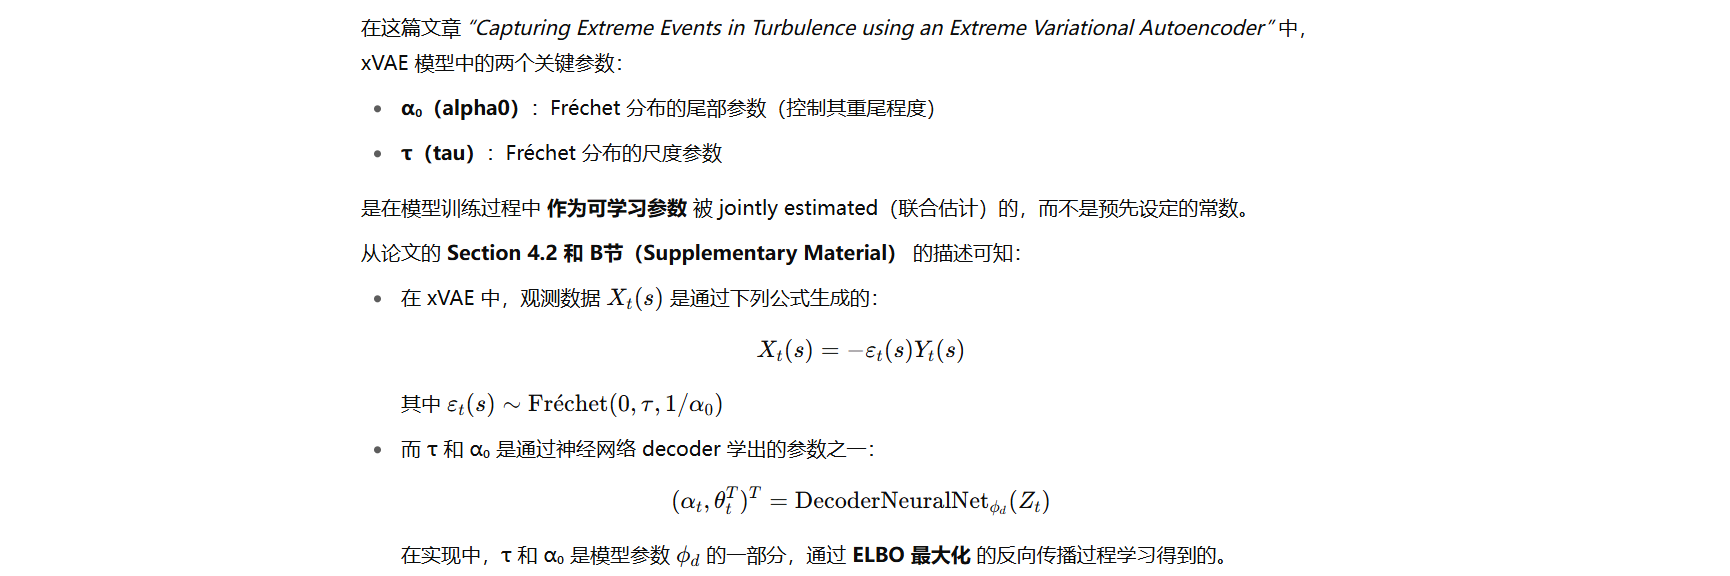

X_train shape: (95, 10, 20, 1)
Y_train shape: (95, 50, 100)
X_test shape: (24, 10, 20, 1)
Y_test shape: (24, 50, 100)
Target shape: (50, 100)
Y_flat shape for NMF: (95, 5000)
Z_nmf shape: (95, 50)
omega shape: (50, 5000)
Epoch 1/50
alpha0: 0.7999999523162842, tau: 0.9999999403953552
1/6 [====>.........................] - ETA: 0s - loss: 2193183232.0000 - nll: -8525.8477 - kl: 21931915264.0000alpha0: 0.8000550270080566, tau: 1.000063180923462
alpha0: 0.8001100420951843, tau: 1.0001263618469238
3/6 [==============>...............] - ETA: 0s - loss: 3207268010.6667 - nll: -8391.4287 - kl: 22080538624.0000

d:\anaconda\envs\dxtorch\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


alpha0: 0.8001651167869568, tau: 1.0001895427703857
alpha0: 0.800220251083374, tau: 1.0002528429031372
6/6 [==============================] - 0s 50ms/step - loss: 5132841618.2857 - nll: -8487.1572 - kl: 20817055744.0000 - val_loss: 1.3854 - val_nll: 0.9430 - val_kl: 0.4424
Epoch 2/50
alpha0: 0.8003304600715637, tau: 1.0003793239593506
1/6 [====>.........................] - ETA: 0s - loss: 15686999040.0000 - nll: -8545.5996 - kl: 22410010624.0000alpha0: 0.8003855347633362, tau: 1.000442624092102
alpha0: 0.8004407286643982, tau: 1.0005059242248535
3/6 [==============>...............] - ETA: 0s - loss: 15641124864.0000 - nll: -8470.0156 - kl: 19375816704.0000alpha0: 0.8004958033561707, tau: 1.0005689859390259
alpha0: 0.8005508780479431, tau: 1.0006322860717773
6/6 [==============================] - 0s 47ms/step - loss: 17128028891.4286 - nll: -8527.4307 - kl: 20911765504.0000 - val_loss: 1.3349 - val_nll: 0.8254 - val_kl: 0.5094
Epoch 3/50
alpha0: 0.8006612062454224, tau: 1.00075900554656

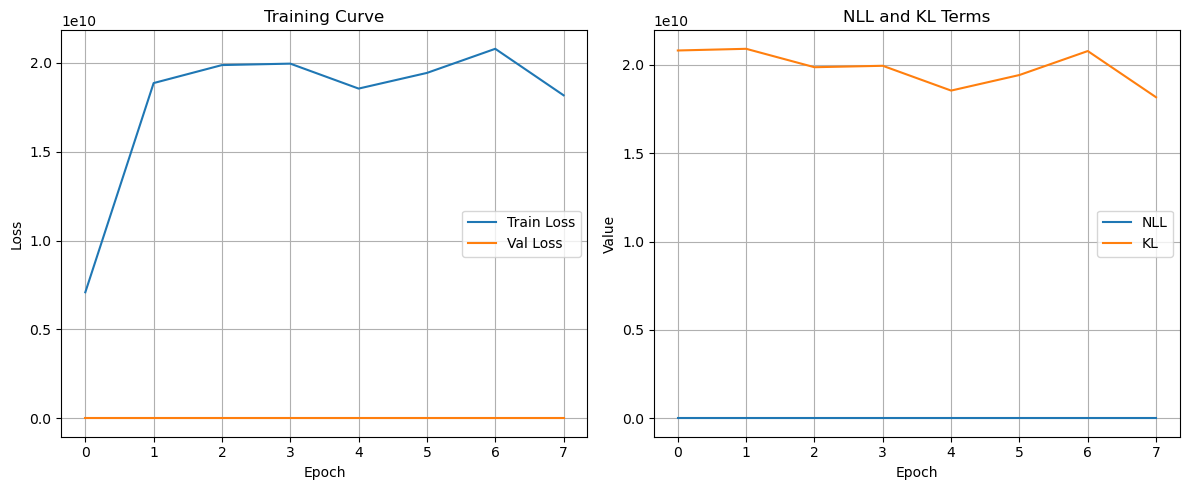

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


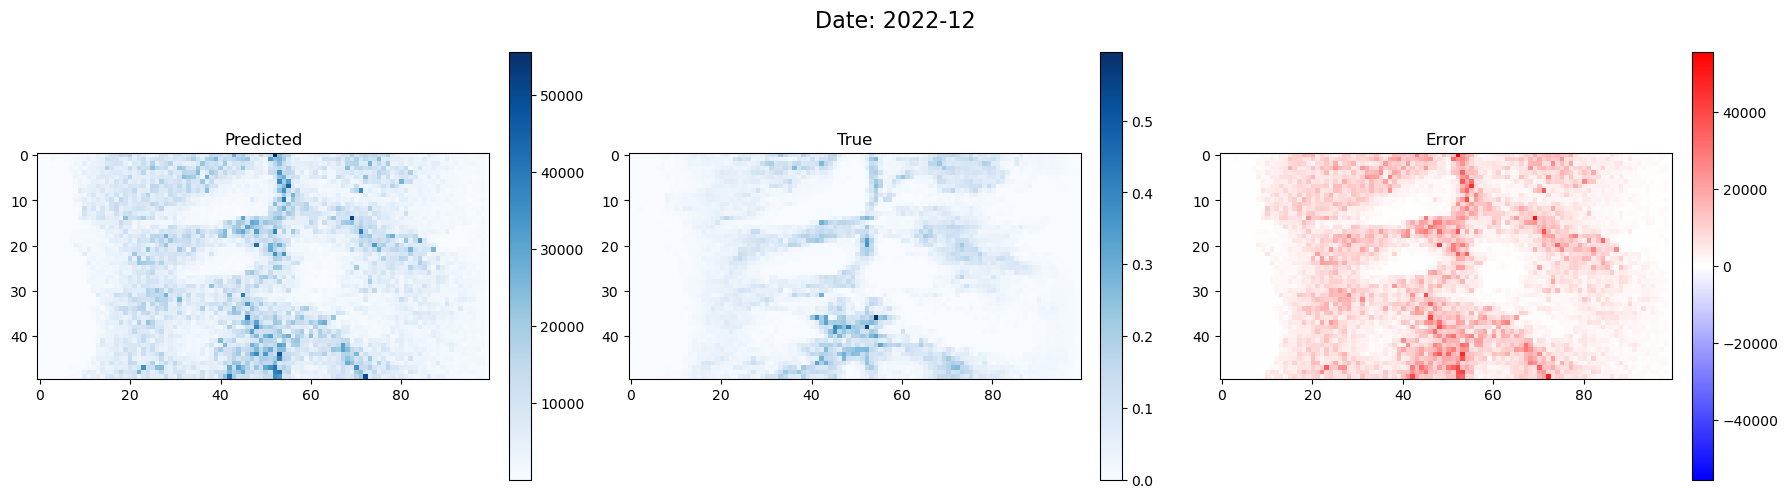

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


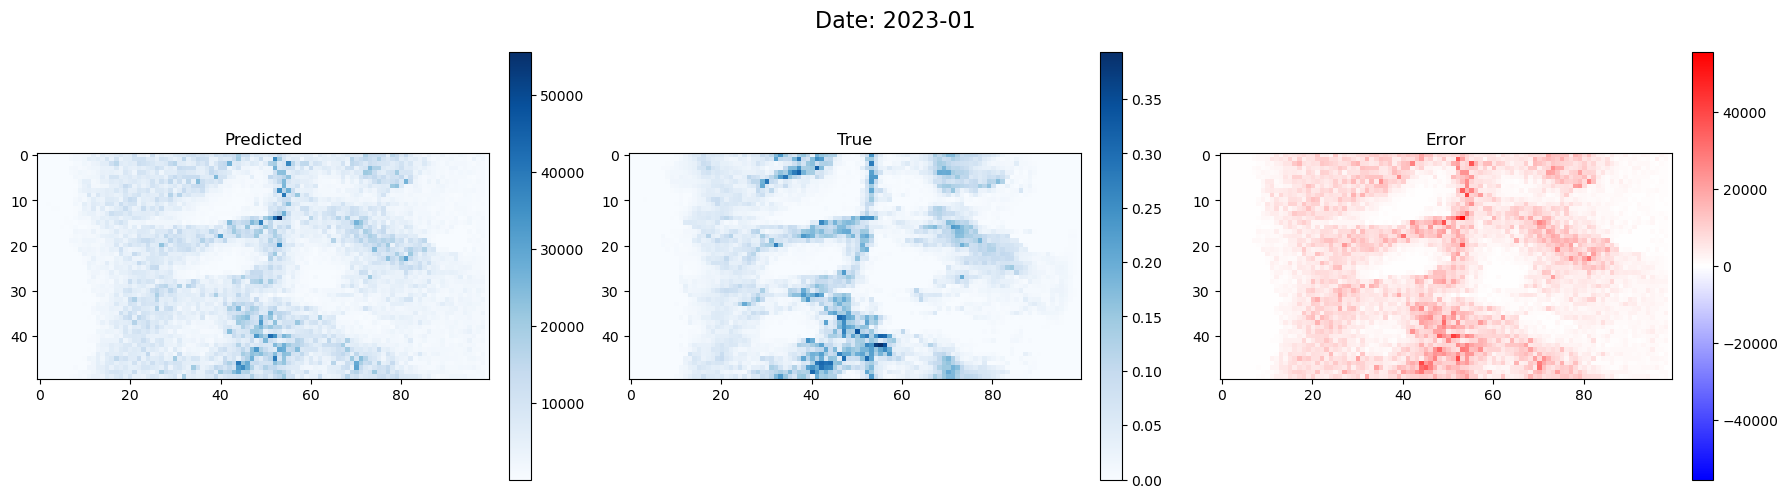

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


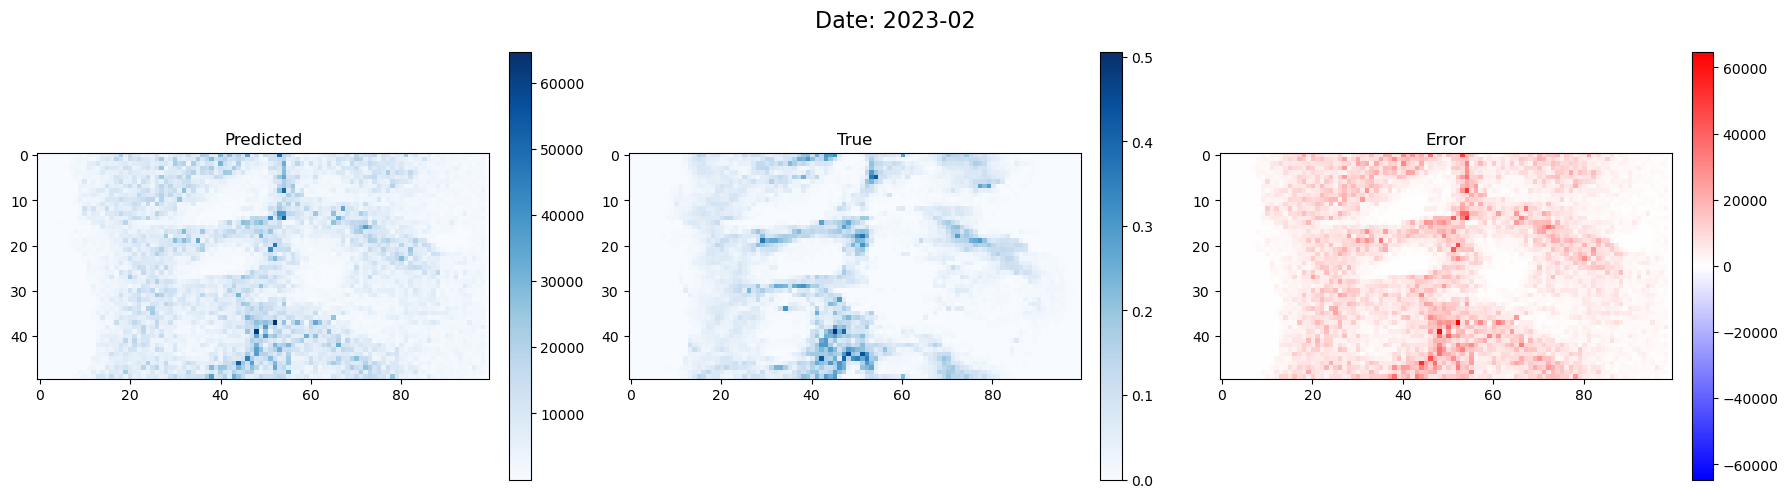

Overall RMSE: 8510.6220703125
No values below p=0.1 threshold
No values below p=0.05 threshold
No values below p=0.01 threshold


In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, Model
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Non-negative Matrix Factorization for basis functions
# ------------------------------------------------------
def perform_nmf_decomposition(Y_train, n_components=50):
    """
    Perform NMF decomposition on training data
    
    Parameters:
    -----------
    Y_train : np.ndarray
        Training data for high resolution, shape (time, lat, lon, [channel])
    n_components : int
        Number of NMF components
        
    Returns:
    --------
    Z_nmf : np.ndarray
        NMF coefficients, shape (samples, n_components)
    omega : np.ndarray
        NMF components, shape (n_components, flat_features)
    Y_train_min : float
        Minimum value of Y_train (needed to make data non-negative)
    """
    # Ensure Y_train is non-negative for NMF
    Y_train_min = Y_train.min()
    Y_train_nmf_input = Y_train - Y_train_min  # Shift to make non-negative
    
    # Flatten to (samples, features) shape
    orig_shape = Y_train.shape
    if len(orig_shape) == 4:  # (samples, height, width, channels)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    else:  # (samples, height, width)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    
    print(f"Y_flat shape for NMF: {Y_flat.shape}")
    
    # Perform NMF decomposition
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
    Z_nmf = nmf.fit_transform(Y_flat)
    omega = nmf.components_  # shape: (n_components, features)
    
    print(f"Z_nmf shape: {Z_nmf.shape}")
    print(f"omega shape: {omega.shape}")
    
    return Z_nmf, omega, Y_train_min

# ------------------------------------------------------
# 2. xVAE Model Components
# ------------------------------------------------------

class Encoder(tf.keras.Model):
    """
    Encoder network for the xVAE
    Maps input data to latent space parameters (mu, log_zeta)
    """
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_net = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim * 2)  # Output mu and log_zeta
        ])
        
    def call(self, x):
        h = self.encoder_net(x)
        mu, log_zeta = tf.split(h, num_or_size_splits=2, axis=1)
        return mu, log_zeta

def sample_exp_ps(mu, log_zeta, alpha=0.5):
    """
    Sample from the exponentially-tilted positive stable distribution
    
    Parameters:
    -----------
    mu : tf.Tensor
        Location parameter
    log_zeta : tf.Tensor
        Log of scale parameter
    alpha : float
        Stability parameter (0 < alpha < 1)
        
    Returns:
    --------
    z : tf.Tensor
        Sampled values
    """
    # Generate gamma distribution samples
    eps = tf.random.gamma(shape=tf.shape(mu), alpha=alpha, beta=1.0)
    eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
    
    # Transform to exponentially-tilted positive stable distribution
    # When alpha = 0.5, -1/alpha = -2.0
    z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -1.0/alpha)
    return z

class MaxIDDecoder(tf.keras.Model):
    """
    Decoder network for the xVAE based on max-infinitely divisible process
    Maps latent variables to reconstructed data
    """
    def __init__(self, omega, target_shape):
        super(MaxIDDecoder, self).__init__()
        self.omega = tf.constant(omega, dtype=tf.float32)
        self.target_shape = target_shape

        self.log_alpha0 = tf.Variable(tf.math.log(tf.exp(0.8) - 1.0), trainable=True, dtype=tf.float32)
        self.log_tau = tf.Variable(tf.math.log(tf.exp(1.0) - 1.0), trainable=True, dtype=tf.float32)
        
    def call(self, z):
        alpha0 = tf.nn.softplus(self.log_alpha0)
        tau = tf.nn.softplus(self.log_tau)

        # First, project latent variables using NMF basis
        raw = tf.matmul(z, self.omega)
        
        # Apply softplus to ensure positivity
        positive = tf.nn.softplus(raw)
        
        # Raise to power alpha0 (model equation 6 in the paper)
        Y = tf.pow(positive + 1e-6, alpha0)
        
        # Generate Fréchet noise (model equation 5 in the paper)
        epsilon = tf.random.gamma(shape=tf.shape(Y), alpha=alpha0)
        
        # Final output: -epsilon * Y (negative because we want to model low extremes)
        x_rec = Y * epsilon * tau
        
        # Get the batch size 
        batch_size = tf.shape(z)[0]
        
        # Check compatibility of dimensions
        total_elements = tf.size(x_rec)
        target_elements = np.prod(self.target_shape)
        expected_elements = batch_size * target_elements
        
        if total_elements != expected_elements:
            print(f"Dimension mismatch: {total_elements} vs {expected_elements}")
            
            # Calculate new dimensions that preserve the spatial shape as much as possible
            elements_per_sample = total_elements // batch_size
            
            if len(self.target_shape) == 3:  # (height, width, channels)
                width = self.target_shape[1]
                channels = self.target_shape[2]
                height = elements_per_sample // (width * channels)
                adjusted_shape = (height, width, channels)
            else:  # (height, width)
                width = self.target_shape[1]
                height = elements_per_sample // width
                adjusted_shape = (height, width)
            
            print(f"Adjusted shape: {adjusted_shape} (original: {self.target_shape})")
            return tf.reshape(x_rec, (batch_size,) + adjusted_shape)
        
        return tf.reshape(x_rec, (batch_size,) + self.target_shape), alpha0, tau


class xVAE(tf.keras.Model):
    """
    Extreme Variational Autoencoder
    Combines encoder and decoder with KL divergence for extreme value modeling
    """
    def __init__(self, encoder, decoder, kl_annealing=False):
        super(xVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_annealing = kl_annealing
        
        # Metrics for tracking
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.nll_tracker = tf.keras.metrics.Mean(name="nll")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")
        self.epoch_counter = 0
        self.metrics_list = [self.total_loss_tracker, self.nll_tracker, self.kl_tracker]

    @property
    def metrics(self):
        return self.metrics_list

    def log_frechet_likelihood(self, y, Y, alpha, tau):
        """
        Compute negative log-likelihood under Fréchet distribution.
        y : target
        Y : deterministic part (i.e., output of decoder before noise)
        alpha, tau : Fréchet parameters
        """
        y = tf.maximum(y, 1e-6)
        return tf.reduce_mean(
            -tf.math.log(alpha + 1e-6)
            - (alpha + 1) * tf.math.log(y)
            - tf.pow(tau / y, alpha)
        )

    def compile(self, optimizer, kl_max_weight=1.0, kl_warmup_epochs=10):
        super().compile()
        self.optimizer = optimizer
        self.kl_max_weight = kl_max_weight
        self.kl_warmup_epochs = kl_warmup_epochs

    def train_step(self, data):
        alpha0 = tf.nn.softplus(self.decoder.log_alpha0)
        tau = tf.nn.softplus(self.decoder.log_tau)
        print(f"alpha0: {alpha0.numpy()}, tau: {tau.numpy()}")

        x, y = data
        self.epoch_counter += 1
        
        # Calculate KL weight for annealing
        kl_weight = min(self.epoch_counter / self.kl_warmup_epochs, 1.0) * self.kl_max_weight

        with tf.GradientTape() as tape:
            # Encode input to get mu and log_zeta
            mu, log_zeta = self.encoder(x)
            
            # Sample from exponentially-tilted positive stable distribution
            # Using alpha = 0.5 as in the paper
            eps = tf.random.gamma(shape=tf.shape(mu), alpha=0.5, beta=1.0)
            eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
            z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -2.0)  # alpha = 0.5 → -1/alpha = -2

            # Decode to get reconstruction
            x_rec, alpha0, tau = self.decoder(z)
            
            # Need to reshape y to match x_rec
            y_reshaped = tf.reshape(y, tf.shape(x_rec))
            
            # Calculate loss components
            # MSE loss for reconstruction
            nll = self.log_frechet_likelihood(y_reshaped, x_rec, alpha=alpha0, tau=tau)
            
            # KL divergence for regularization
            # For expPS distribution, using a simpler approximation
            kl = tf.reduce_mean(0.5 * tf.square(z))
            
            # Total loss
            loss = nll + kl_weight * kl

        # Get gradients and update model parameters
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "nll": self.nll_tracker.result(), 
            "kl": self.kl_tracker.result()
        }

    def test_step(self, data):
        x, y = data
        
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = mu + tf.exp(0.5 * log_zeta) * tf.random.normal(tf.shape(mu))
        
        # Decode
        x_rec, alpha0, tau = self.decoder(z)

        y_reshaped = tf.reshape(y, tf.shape(x_rec))

        
        # Calculate loss components
        nll = tf.reduce_mean(tf.square(x_rec - y_reshaped))
        kl = tf.reduce_mean(0.5 * tf.square(z))
        loss = nll + kl

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)

        return {
            "loss": loss, 
            "nll": nll, 
            "kl": kl
        }
    
    def call(self, x):
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = sample_exp_ps(mu, log_zeta, alpha=0.5)
        
        # Decode
        return self.decoder(z)

# KL weight scheduler callback
class KLWeightScheduler(callbacks.Callback):
    """Callback to schedule KL weight during training"""
    def __init__(self, kl_weight_var, max_value, epochs):
        self.kl_weight = kl_weight_var
        self.max_value = max_value
        self.epochs = epochs
        
    def on_epoch_begin(self, epoch, logs=None):
        # Linear annealing of KL weight
        tf.keras.backend.set_value(self.kl_weight, self.max_value * epoch / self.epochs)

# ------------------------------------------------------
# 3. Data Preprocessing Functions
# ------------------------------------------------------

def preprocess_precipitation_data(low_res_data, high_res_data):
    """
    Preprocess precipitation data for xVAE model
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    
    Returns:
    --------
    X_train, X_test, Y_train, Y_test, Y_train_min, split_time
    """
    # Replace NaN with 0
    low_res = np.nan_to_num(low_res_data, nan=0.0)
    high_res = np.nan_to_num(high_res_data, nan=0.0)
    
    # Normalize data
    max_precip = np.max([low_res.max(), high_res.max()])
    low_res = low_res / max_precip
    high_res = high_res / max_precip
    
    # Add channel dimension if needed
    if low_res.ndim == 3:
        low_res = low_res[..., np.newaxis]  # shape (time, lat, lon, 1)
    
    # For high_res, we'll keep the original dimensions
    # This is a key fix - we don't add a channel dimension to high_res to ensure
    # compatibility with the model input/output
    
    # Split by time (80% train, 20% test)
    num_samples = low_res.shape[0]
    split_time = int(num_samples * 0.8)
    X_train, Y_train = low_res[:split_time], high_res[:split_time]
    X_test, Y_test = low_res[split_time:], high_res[split_time:]
    
    # Get minimum value of Y_train for later denormalization
    Y_train_min = Y_train.min()
    
    # Print shapes for debugging
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")
    
    return X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time

# ------------------------------------------------------
# 4. Visualization and Evaluation Functions
# ------------------------------------------------------

def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array=None, split_time=None):
    """
    Visualize prediction comparison for a single sample
    
    Parameters:
    -----------
    index : int
        Index of the sample to visualize
    preds_actual : np.ndarray
        Predicted values (after denormalization)
    y_test_actual : np.ndarray
        True values (after denormalization)
    time_array : np.ndarray, optional
        Array of time values for labeling plots
    split_time : int, optional
        Index where test set begins
    """
    if index >= len(preds_actual) or index >= len(y_test_actual):
        print(f"Index {index} out of range. preds_actual length: {len(preds_actual)}, y_test_actual length: {len(y_test_actual)}")
        return
    
    # Get prediction and ground truth
    pred = preds_actual[index]
    truth = y_test_actual[index]
    
    # Remove unnecessary singleton dimensions if any
    if pred.ndim > 2:
        pred = np.squeeze(pred)
    if truth.ndim > 2:
        truth = np.squeeze(truth)
    
    # Print shapes for debugging
    print(f"Pred shape after squeeze: {pred.shape}")
    print(f"Truth shape after squeeze: {truth.shape}")
    
    # If prediction and ground truth have different shapes, resize prediction
    if pred.shape != truth.shape:
        print(f"Warning: Shape mismatch. Resizing prediction to match ground truth.")
        # Simple resize - could be improved with interpolation
        from scipy.ndimage import zoom
        
        # Calculate zoom factors
        zoom_factors = [ts/ps for ts, ps in zip(truth.shape, pred.shape)]
        pred_resized = zoom(pred, zoom_factors)
        pred = pred_resized
        print(f"Resized pred shape: {pred.shape}")
    
    # Calculate error
    error = pred - truth
    
    # Get time string if available
    time_str = ""
    if time_array is not None and split_time is not None and (split_time + index) < len(time_array):
        try:
            time_str = np.datetime_as_string(time_array[split_time + index], unit='M')
        except:
            time_str = f"Sample {index}"
    else:
        time_str = f"Sample {index}"
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im0 = axes[0].imshow(pred, cmap='Blues')
    axes[0].set_title(f"Predicted")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(truth, cmap='Blues')
    axes[1].set_title(f"True")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    im2 = axes[2].imshow(error, cmap='bwr', 
                       vmin=-np.max(np.abs(error)), 
                       vmax=np.max(np.abs(error)))
    axes[2].set_title("Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Date: {time_str}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to calculate tail RMSE
def calculate_tail_rmse(predictions, ground_truth, p=0.05):
    """
    Calculate RMSE for values below a quantile threshold
    
    Parameters:
    -----------
    predictions : np.ndarray
        Predicted values
    ground_truth : np.ndarray
        True values
    p : float
        Quantile threshold (0 < p < 1)
        
    Returns:
    --------
    tail_rmse : float
        RMSE for values below threshold
    """
    # Reshape if needed
    if predictions.shape != ground_truth.shape:
        from scipy.ndimage import zoom
        
        # Calculate zoom factors for each spatial dimension
        zoom_factors = [gs/ps for gs, ps in zip(ground_truth.shape, predictions.shape)]
        
        # We keep the batch dimension as is
        if len(zoom_factors) >= 3:  # Handle batch dimension
            zoom_factors = [1] + zoom_factors[1:]
            
        # Resize predictions to match ground truth
        predictions_resized = zoom(predictions, zoom_factors)
        predictions = predictions_resized
    
    # Find threshold
    threshold = np.quantile(ground_truth, p)
    
    # Create mask for values below threshold
    mask = ground_truth < threshold
    
    # Check if there are any values below threshold
    if np.sum(mask) == 0:
        print(f"No values below p={p} threshold")
        return None
    
    # Calculate RMSE for values below threshold
    tail_rmse = np.sqrt(np.mean((predictions[mask] - ground_truth[mask])**2))
    
    return tail_rmse

# ------------------------------------------------------
# 5. Main Function to Run the xVAE Model
# ------------------------------------------------------

def run_xvae_model(low_res_data, high_res_data, latent_dim=50,
                  epochs=50, batch_size=16, time_array=None):
    """
    Run the complete xVAE pipeline for precipitation super-resolution
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    latent_dim : int, optional
        Latent dimension for the VAE
    epochs : int, optional
        Number of training epochs
    batch_size : int, optional
        Batch size for training
    time_array : np.ndarray, optional
        Array of time values for visualization
        
    Returns:
    --------
    model : xVAE
        Trained model
    history : tf.keras.callbacks.History
        Training history
    predictions : np.ndarray
        Model predictions
    ground_truth : np.ndarray
        Ground truth data
    """
    # Set TensorFlow to eager execution for better debugging
    tf.config.run_functions_eagerly(True)
    
    # 1. Preprocess data
    X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time = preprocess_precipitation_data(
        low_res_data, high_res_data
    )
    
    # 2. Get target shape for decoder output
    # Using Y_train shape directly to ensure dimensions match
    target_shape = Y_train.shape[1:]  # (height, width) or (height, width, channels)
    print(f"Target shape: {target_shape}")
    
    # 3. Perform NMF decomposition to get basis functions
    _, omega, _ = perform_nmf_decomposition(Y_train, n_components=latent_dim)
    
    # 4. Ensure omega shape is compatible with target shape
    flat_size = np.prod(target_shape)
    if omega.shape[1] != flat_size:
        print(f"Warning: Omega shape {omega.shape[1]} doesn't match target shape flat size {flat_size}")
        
        # Two options:
        # 1. Adjust target shape to match omega (keeping spatial dimensions as close as possible)
        # 2. Adjust omega to match target shape (requires re-running NMF with constraints)
        
        # We'll go with option 1 for simplicity
        width = target_shape[-1]  # Last dimension (width)
        if len(target_shape) == 3:  # (height, width, channels)
            channels = target_shape[-1]
            width = target_shape[-2]
            height = omega.shape[1] // (width * channels)
            target_shape = (height, width, channels)
        else:  # (height, width)
            height = omega.shape[1] // width
            target_shape = (height, width)
        
        print(f"Adjusted target shape to: {target_shape}")
    
    # 5. Build xVAE model
    encoder = Encoder(latent_dim=latent_dim)
    decoder = MaxIDDecoder(omega=omega, target_shape=target_shape)  # 不传 alpha0, tau
    model = xVAE(encoder, decoder, kl_annealing=True)
    model.compile(optimizer=optimizers.Adam(1e-4), kl_max_weight=1.0, kl_warmup_epochs=10)
    
    # 6. Train model with a callback for early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 7. Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["nll"], label="NLL")
    plt.plot(history.history["kl"], label="KL")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("NLL and KL Terms")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    # 8. Generate predictions - multiple samples for uncertainty
    n_samples = 10
    all_predictions = []
    
    for _ in range(n_samples):
        mu_test, log_zeta_test = model.encoder(X_test)
        z_test = sample_exp_ps(mu_test, log_zeta_test, alpha=0.5)
        x_rec_test, _, _ = model.decoder(z_test)
        all_predictions.append(x_rec_test.numpy())
    
    # Average the samples for the final prediction
    preds_mean = np.mean(all_predictions, axis=0)
    
    # 9. Denormalize predictions
    preds_actual = preds_mean + Y_train_min
    preds_actual = np.maximum(preds_actual, 0)  # Clip negative values to 0
    
    # 10. Denormalize ground truth
    y_test_actual = Y_test + Y_train_min
    
    # 11. Visualize samples and calculate metrics
    for i in range(min(3, len(X_test))):
        plot_prediction_comparison(i, preds_actual, y_test_actual, time_array, split_time)
    
    # 12. Calculate and print metrics for different tail quantiles
    metrics = {}
    
    # Overall RMSE
    overall_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=1.0)
    metrics["overall_rmse"] = overall_rmse
    print(f"Overall RMSE: {overall_rmse}")
    
    # Tail RMSEs
    for p in [0.1, 0.05, 0.01]:
        tail_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=p)
        if tail_rmse is not None:
            metrics[f"tail_rmse_{p}"] = tail_rmse
            print(f"Tail RMSE (p={p}): {tail_rmse}")
    
    return model, history, preds_actual, y_test_actual, metrics

# Example usage with real data

# Run the xVAE model on real data
model, history, predictions, ground_truth, metrics = run_xvae_model(
    combined005["precipitation"].values,  # Low-res data
    combined001["precipitation"].values,  # High-res data
    latent_dim=50,
    epochs=50,
    batch_size=16,
    time_array=combined005.time.values
)


In [ ]:
# 调整
重点推荐】调整 KL 权重：
model.compile(..., kl_max_weight=0.001)  # 从 1.0 降低到 0.001 或 0.0001
这样可以减少 KL 对总 loss 的主导作用，让模型更关注 NLL（即 reconstruction）。

<xarray.Dataset>
Dimensions:       (time: 24, lat: 50, lon: 100)
Coordinates:
  * time          (time) datetime64[ns] 2022-12-01 2023-01-01 ... 2024-11-01
  * lat           (lat) float32 40.4 40.41 40.42 40.43 ... 40.88 40.89 40.9
  * lon           (lon) float32 -74.1 -74.09 -74.08 ... -73.12 -73.11 -73.1
Data variables:
    prediction    (time, lat, lon) float32 0.3367 0.6588 ... 3.019e+03 0.4344
    ground_truth  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0001915 0.0
X_train shape: (95, 10, 20, 1)
Y_train shape: (95, 50, 100)
X_test shape: (24, 10, 20, 1)
Y_test shape: (24, 50, 100)
Target shape: (50, 100)
Y_flat shape for NMF: (95, 5000)
Z_nmf shape: (95, 50)
omega shape: (50, 5000)
Epoch 1/50
alpha0: 0.7999999523162842, tau: 0.9999999403953552
1/6 [====>.........................] - ETA: 0s - loss: -8469730.0000 - nll: -8486128.0000 - kl: 16398087168.0000

d:\anaconda\envs\dxtorch\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
d:\anaconda\envs\dxtorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


alpha0: 0.8000550270080566, tau: 1.000063180923462
alpha0: 0.8001100420951843, tau: 1.0001263618469238
3/6 [==============>...............] - ETA: 0s - loss: -8380466.0000 - nll: -8395436.0000 - kl: 21223350272.0000alpha0: 0.8001651763916016, tau: 1.0001895427703857
alpha0: 0.800220251083374, tau: 1.0002528429031372
6/6 [==============================] - 0s 49ms/step - loss: -8389074.3571 - nll: -8488954.0000 - kl: 22281887744.0000 - val_loss: 1.3588 - val_nll: 0.8419 - val_kl: 0.5168
Epoch 2/50
alpha0: 0.8003305196762085, tau: 1.0003795623779297
1/6 [====>.........................] - ETA: 0s - loss: -8742526.0000 - nll: -8907261.0000 - kl: 23533500416.0000alpha0: 0.8003858327865601, tau: 1.0004429817199707
alpha0: 0.8004410266876221, tau: 1.0005062818527222
3/6 [==============>...............] - ETA: 0s - loss: -8488159.8333 - nll: -8463727.0000 - kl: 22959437824.0000alpha0: 0.8004961013793945, tau: 1.0005693435668945
alpha0: 0.800551176071167, tau: 1.000632643699646
6/6 [============

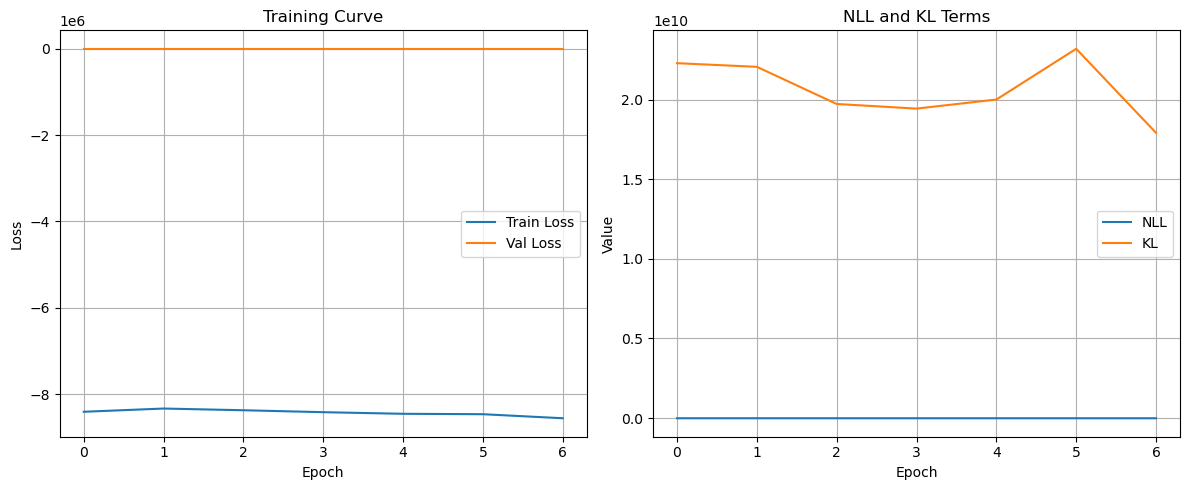

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


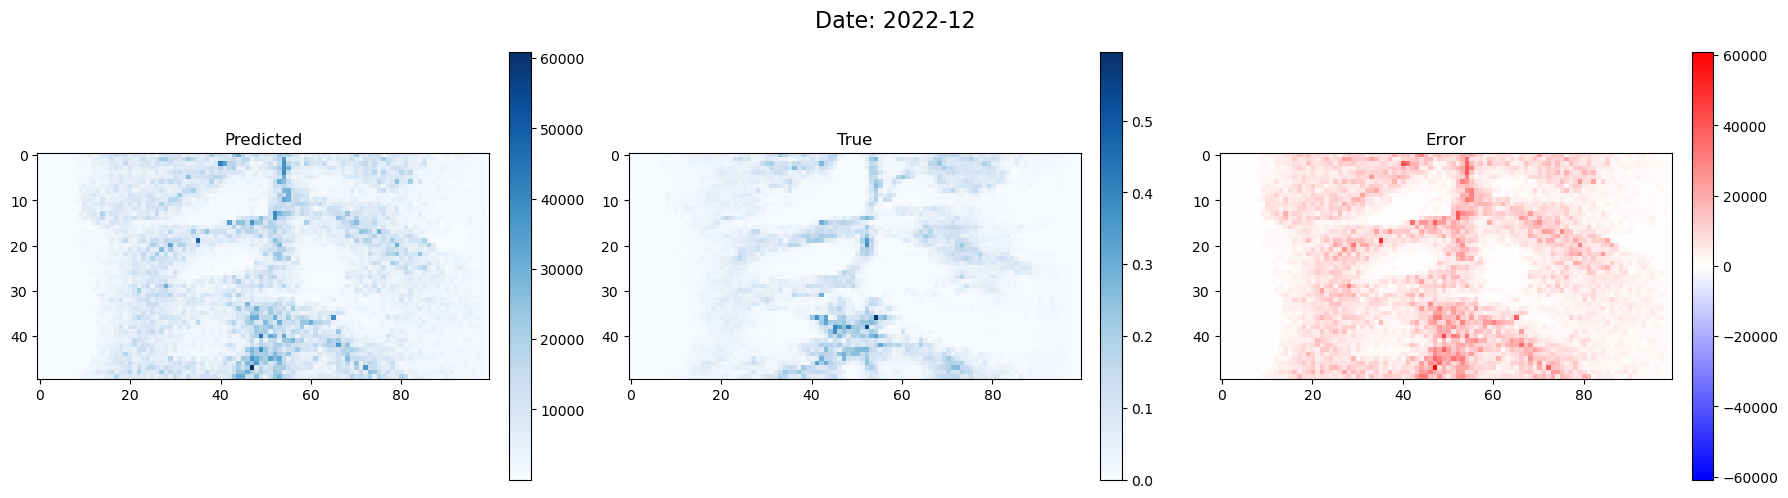

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


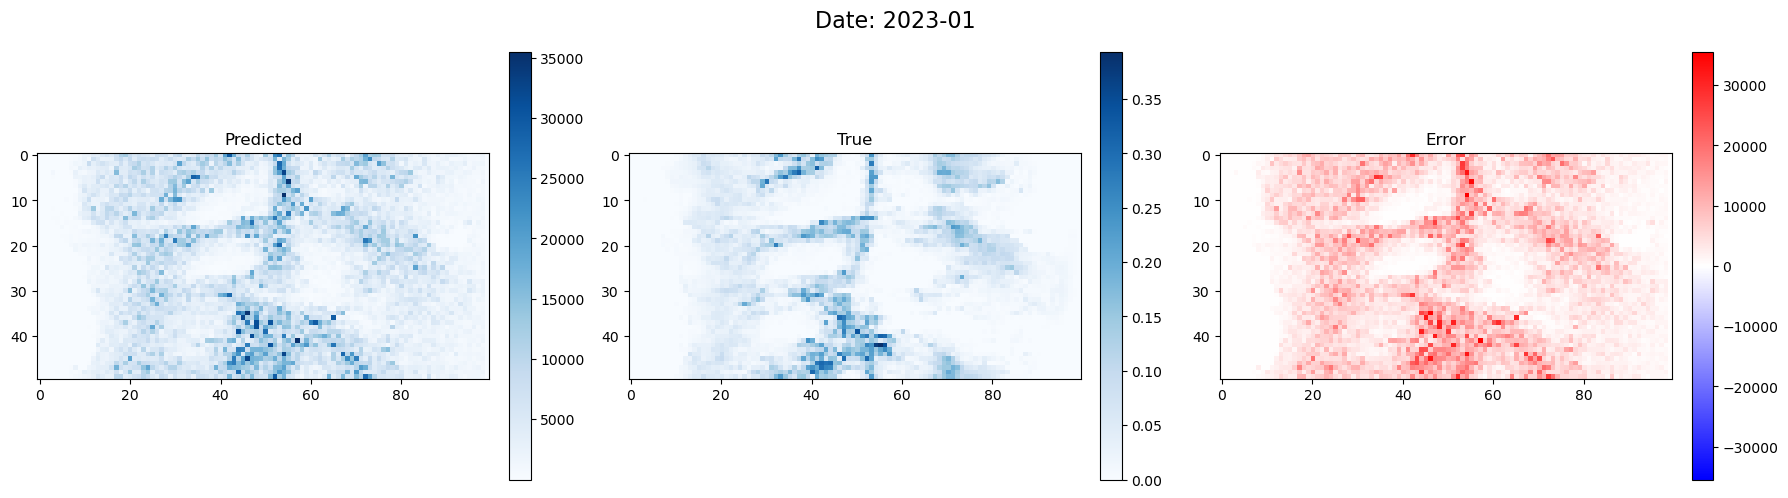

Pred shape after squeeze: (50, 100)
Truth shape after squeeze: (50, 100)


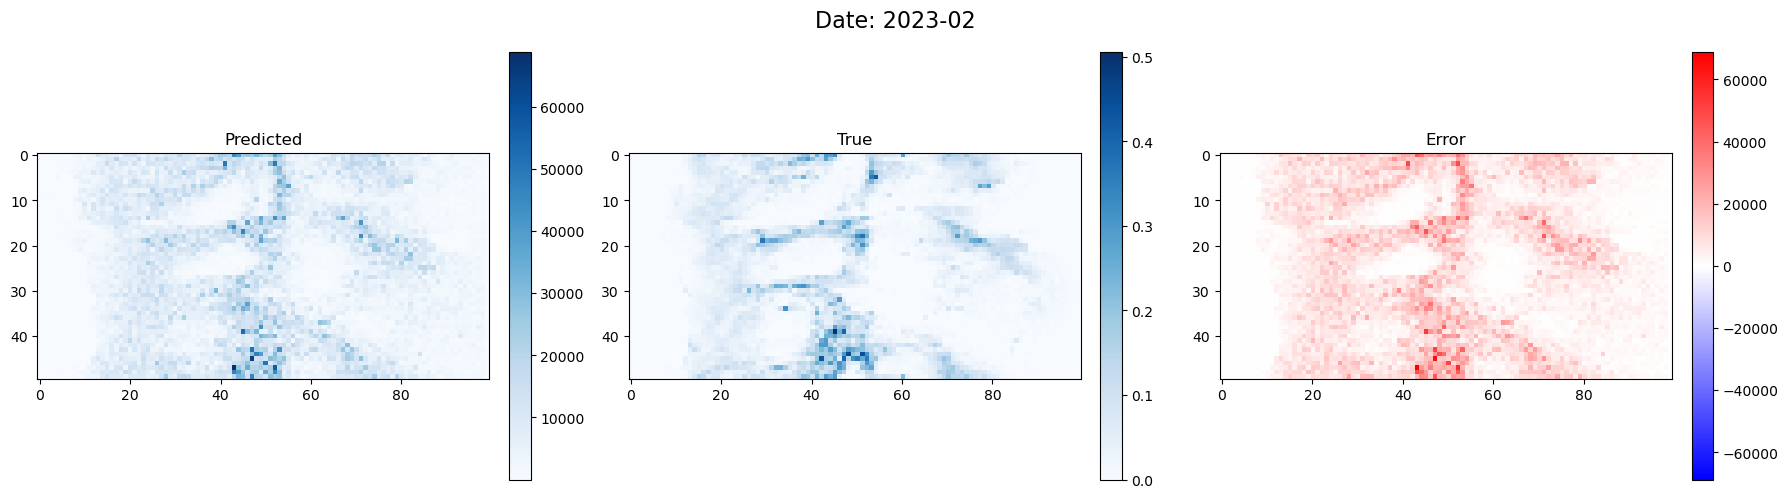

Overall RMSE: 8124.19921875
No values below p=0.1 threshold
No values below p=0.05 threshold
No values below p=0.01 threshold


In [71]:
# 调整
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, Model
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Non-negative Matrix Factorization for basis functions
# ------------------------------------------------------
def perform_nmf_decomposition(Y_train, n_components=50):
    """
    Perform NMF decomposition on training data
    
    Parameters:
    -----------
    Y_train : np.ndarray
        Training data for high resolution, shape (time, lat, lon, [channel])
    n_components : int
        Number of NMF components
        
    Returns:
    --------
    Z_nmf : np.ndarray
        NMF coefficients, shape (samples, n_components)
    omega : np.ndarray
        NMF components, shape (n_components, flat_features)
    Y_train_min : float
        Minimum value of Y_train (needed to make data non-negative)
    """
    # Ensure Y_train is non-negative for NMF
    Y_train_min = Y_train.min()
    Y_train_nmf_input = Y_train - Y_train_min  # Shift to make non-negative
    
    # Flatten to (samples, features) shape
    orig_shape = Y_train.shape
    if len(orig_shape) == 4:  # (samples, height, width, channels)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    else:  # (samples, height, width)
        Y_flat = Y_train_nmf_input.reshape((orig_shape[0], -1))
    
    print(f"Y_flat shape for NMF: {Y_flat.shape}")
    
    # Perform NMF decomposition
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
    Z_nmf = nmf.fit_transform(Y_flat)
    omega = nmf.components_  # shape: (n_components, features)
    
    print(f"Z_nmf shape: {Z_nmf.shape}")
    print(f"omega shape: {omega.shape}")
    
    return Z_nmf, omega, Y_train_min

# ------------------------------------------------------
# 2. xVAE Model Components
# ------------------------------------------------------

class Encoder(tf.keras.Model):
    """
    Encoder network for the xVAE
    Maps input data to latent space parameters (mu, log_zeta)
    """
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_net = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
            layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim * 2)  # Output mu and log_zeta
        ])
        
    def call(self, x):
        h = self.encoder_net(x)
        mu, log_zeta = tf.split(h, num_or_size_splits=2, axis=1)
        return mu, log_zeta

def sample_exp_ps(mu, log_zeta, alpha=0.5):
    """
    Sample from the exponentially-tilted positive stable distribution
    
    Parameters:
    -----------
    mu : tf.Tensor
        Location parameter
    log_zeta : tf.Tensor
        Log of scale parameter
    alpha : float
        Stability parameter (0 < alpha < 1)
        
    Returns:
    --------
    z : tf.Tensor
        Sampled values
    """
    # Generate gamma distribution samples
    eps = tf.random.gamma(shape=tf.shape(mu), alpha=alpha, beta=1.0)
    eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
    
    # Transform to exponentially-tilted positive stable distribution
    # When alpha = 0.5, -1/alpha = -2.0
    z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -1.0/alpha)
    return z

class MaxIDDecoder(tf.keras.Model):
    """
    Decoder network for the xVAE based on max-infinitely divisible process
    Maps latent variables to reconstructed data
    """
    def __init__(self, omega, target_shape):
        super(MaxIDDecoder, self).__init__()
        self.omega = tf.constant(omega, dtype=tf.float32)
        self.target_shape = target_shape

        self.log_alpha0 = tf.Variable(tf.math.log(tf.exp(0.8) - 1.0), trainable=True, dtype=tf.float32)
        self.log_tau = tf.Variable(tf.math.log(tf.exp(1.0) - 1.0), trainable=True, dtype=tf.float32)
        
    def call(self, z):
        alpha0 = tf.nn.softplus(self.log_alpha0)
        tau = tf.nn.softplus(self.log_tau)

        # First, project latent variables using NMF basis
        raw = tf.matmul(z, self.omega)
        
        # Apply softplus to ensure positivity
        positive = tf.nn.softplus(raw)
        
        # Raise to power alpha0 (model equation 6 in the paper)
        Y = tf.pow(positive + 1e-6, alpha0)
        
        # Generate Fréchet noise (model equation 5 in the paper)
        epsilon = tf.random.gamma(shape=tf.shape(Y), alpha=alpha0)
        
        # Final output: -epsilon * Y (negative because we want to model low extremes)
        x_rec = Y * epsilon * tau
        
        # Get the batch size 
        batch_size = tf.shape(z)[0]
        
        # Check compatibility of dimensions
        total_elements = tf.size(x_rec)
        target_elements = np.prod(self.target_shape)
        expected_elements = batch_size * target_elements
        
        if total_elements != expected_elements:
            print(f"Dimension mismatch: {total_elements} vs {expected_elements}")
            
            # Calculate new dimensions that preserve the spatial shape as much as possible
            elements_per_sample = total_elements // batch_size
            
            if len(self.target_shape) == 3:  # (height, width, channels)
                width = self.target_shape[1]
                channels = self.target_shape[2]
                height = elements_per_sample // (width * channels)
                adjusted_shape = (height, width, channels)
            else:  # (height, width)
                width = self.target_shape[1]
                height = elements_per_sample // width
                adjusted_shape = (height, width)
            
            print(f"Adjusted shape: {adjusted_shape} (original: {self.target_shape})")
            return tf.reshape(x_rec, (batch_size,) + adjusted_shape)
        
        return tf.reshape(x_rec, (batch_size,) + self.target_shape), alpha0, tau


class xVAE(tf.keras.Model):
    """
    Extreme Variational Autoencoder
    Combines encoder and decoder with KL divergence for extreme value modeling
    """
    def __init__(self, encoder, decoder, kl_annealing=False):
        super(xVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_annealing = kl_annealing
        
        # Metrics for tracking
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.nll_tracker = tf.keras.metrics.Mean(name="nll")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")
        self.epoch_counter = 0
        self.metrics_list = [self.total_loss_tracker, self.nll_tracker, self.kl_tracker]

    @property
    def metrics(self):
        return self.metrics_list

    def log_frechet_likelihood(self, y, Y, alpha, tau):
        """
        Compute negative log-likelihood under Fréchet distribution.
        y : target
        Y : deterministic part (i.e., output of decoder before noise)
        alpha, tau : Fréchet parameters
        """
        y = tf.maximum(y, 1e-6)
        return tf.reduce_mean(
            -tf.math.log(alpha + 1e-6)
            - (alpha + 1) * tf.math.log(y)
            - tf.pow(tau / y, alpha)
        )

    def compile(self, optimizer, kl_max_weight=1.0, kl_warmup_epochs=10):
        super().compile()
        self.optimizer = optimizer
        self.kl_max_weight = kl_max_weight
        self.kl_warmup_epochs = kl_warmup_epochs

    def train_step(self, data):
        alpha0 = tf.nn.softplus(self.decoder.log_alpha0)
        tau = tf.nn.softplus(self.decoder.log_tau)
        print(f"alpha0: {alpha0.numpy()}, tau: {tau.numpy()}")

        x, y = data
        self.epoch_counter += 1
        
        # Calculate KL weight for annealing
        kl_weight = min(self.epoch_counter / self.kl_warmup_epochs, 1.0) * self.kl_max_weight

        with tf.GradientTape() as tape:
            # Encode input to get mu and log_zeta
            mu, log_zeta = self.encoder(x)
            
            # Sample from exponentially-tilted positive stable distribution
            # Using alpha = 0.5 as in the paper
            eps = tf.random.gamma(shape=tf.shape(mu), alpha=0.5, beta=1.0)
            eps = tf.clip_by_value(eps, 1e-3, 10.0)  # Avoid numerical issues
            z = mu + tf.exp(0.5 * log_zeta) * tf.pow(eps, -2.0)  # alpha = 0.5 → -1/alpha = -2

            # Decode to get reconstruction
            x_rec, alpha0, tau = self.decoder(z)
            
            # Need to reshape y to match x_rec
            y_reshaped = tf.reshape(y, tf.shape(x_rec))
            
            # Calculate loss components
            # MSE loss for reconstruction
            nll = 1000.0*self.log_frechet_likelihood(y_reshaped, x_rec, alpha=alpha0, tau=tau)
            
            # KL divergence for regularization
            # For expPS distribution, using a simpler approximation
            kl = tf.reduce_mean(0.5 * tf.square(z))
            
            # Total loss
            loss = nll + kl_weight * kl

        # Get gradients and update model parameters
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "nll": self.nll_tracker.result(), 
            "kl": self.kl_tracker.result()
        }

    def test_step(self, data):
        x, y = data
        
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = mu + tf.exp(0.5 * log_zeta) * tf.random.normal(tf.shape(mu))
        
        # Decode
        x_rec, alpha0, tau = self.decoder(z)

        y_reshaped = tf.reshape(y, tf.shape(x_rec))

        
        # Calculate loss components
        nll = tf.reduce_mean(tf.square(x_rec - y_reshaped))
        kl = tf.reduce_mean(0.5 * tf.square(z))
        loss = nll + kl

        # Update metrics
        self.total_loss_tracker.update_state(loss)
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl)

        return {
            "loss": loss, 
            "nll": nll, 
            "kl": kl
        }
    
    def call(self, x):
        # Encode
        mu, log_zeta = self.encoder(x)
        
        # Sample latent variables
        z = sample_exp_ps(mu, log_zeta, alpha=0.5)
        
        # Decode
        return self.decoder(z)

# KL weight scheduler callback
class KLWeightScheduler(callbacks.Callback):
    """Callback to schedule KL weight during training"""
    def __init__(self, kl_weight_var, max_value, epochs):
        self.kl_weight = kl_weight_var
        self.max_value = max_value
        self.epochs = epochs
        
    def on_epoch_begin(self, epoch, logs=None):
        # Linear annealing of KL weight
        tf.keras.backend.set_value(self.kl_weight, self.max_value * epoch / self.epochs)

# ------------------------------------------------------
# 3. Data Preprocessing Functions
# ------------------------------------------------------

def preprocess_precipitation_data(low_res_data, high_res_data):
    """
    Preprocess precipitation data for xVAE model
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    
    Returns:
    --------
    X_train, X_test, Y_train, Y_test, Y_train_min, split_time
    """
    # Replace NaN with 0
    low_res = np.nan_to_num(low_res_data, nan=0.0)
    high_res = np.nan_to_num(high_res_data, nan=0.0)
    
    # Normalize data
    max_precip = np.max([low_res.max(), high_res.max()])
    low_res = low_res / max_precip
    high_res = high_res / max_precip
    
    # Add channel dimension if needed
    if low_res.ndim == 3:
        low_res = low_res[..., np.newaxis]  # shape (time, lat, lon, 1)
    
    # For high_res, we'll keep the original dimensions
    # This is a key fix - we don't add a channel dimension to high_res to ensure
    # compatibility with the model input/output
    
    # Split by time (80% train, 20% test)
    num_samples = low_res.shape[0]
    split_time = int(num_samples * 0.8)
    X_train, Y_train = low_res[:split_time], high_res[:split_time]
    X_test, Y_test = low_res[split_time:], high_res[split_time:]
    
    # Get minimum value of Y_train for later denormalization
    Y_train_min = Y_train.min()
    
    # Print shapes for debugging
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")
    
    return X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time

# ------------------------------------------------------
# 4. Visualization and Evaluation Functions
# ------------------------------------------------------

def plot_prediction_comparison(index, preds_actual, y_test_actual, time_array=None, split_time=None):
    """
    Visualize prediction comparison for a single sample
    
    Parameters:
    -----------
    index : int
        Index of the sample to visualize
    preds_actual : np.ndarray
        Predicted values (after denormalization)
    y_test_actual : np.ndarray
        True values (after denormalization)
    time_array : np.ndarray, optional
        Array of time values for labeling plots
    split_time : int, optional
        Index where test set begins
    """
    if index >= len(preds_actual) or index >= len(y_test_actual):
        print(f"Index {index} out of range. preds_actual length: {len(preds_actual)}, y_test_actual length: {len(y_test_actual)}")
        return
    
    # Get prediction and ground truth
    pred = preds_actual[index]
    truth = y_test_actual[index]
    
    # Remove unnecessary singleton dimensions if any
    if pred.ndim > 2:
        pred = np.squeeze(pred)
    if truth.ndim > 2:
        truth = np.squeeze(truth)
    
    # Print shapes for debugging
    print(f"Pred shape after squeeze: {pred.shape}")
    print(f"Truth shape after squeeze: {truth.shape}")
    
    # If prediction and ground truth have different shapes, resize prediction
    if pred.shape != truth.shape:
        print(f"Warning: Shape mismatch. Resizing prediction to match ground truth.")
        # Simple resize - could be improved with interpolation
        from scipy.ndimage import zoom
        
        # Calculate zoom factors
        zoom_factors = [ts/ps for ts, ps in zip(truth.shape, pred.shape)]
        pred_resized = zoom(pred, zoom_factors)
        pred = pred_resized
        print(f"Resized pred shape: {pred.shape}")
    
    # Calculate error
    error = pred - truth
    
    # Get time string if available
    time_str = ""
    if time_array is not None and split_time is not None and (split_time + index) < len(time_array):
        try:
            time_str = np.datetime_as_string(time_array[split_time + index], unit='M')
        except:
            time_str = f"Sample {index}"
    else:
        time_str = f"Sample {index}"
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im0 = axes[0].imshow(pred, cmap='Blues')
    axes[0].set_title(f"Predicted")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(truth, cmap='Blues')
    axes[1].set_title(f"True")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    im2 = axes[2].imshow(error, cmap='bwr', 
                       vmin=-np.max(np.abs(error)), 
                       vmax=np.max(np.abs(error)))
    axes[2].set_title("Error")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Date: {time_str}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to calculate tail RMSE
def calculate_tail_rmse(predictions, ground_truth, p=0.05):
    """
    Calculate RMSE for values below a quantile threshold
    
    Parameters:
    -----------
    predictions : np.ndarray
        Predicted values
    ground_truth : np.ndarray
        True values
    p : float
        Quantile threshold (0 < p < 1)
        
    Returns:
    --------
    tail_rmse : float
        RMSE for values below threshold
    """
    # Reshape if needed
    if predictions.shape != ground_truth.shape:
        from scipy.ndimage import zoom
        
        # Calculate zoom factors for each spatial dimension
        zoom_factors = [gs/ps for gs, ps in zip(ground_truth.shape, predictions.shape)]
        
        # We keep the batch dimension as is
        if len(zoom_factors) >= 3:  # Handle batch dimension
            zoom_factors = [1] + zoom_factors[1:]
            
        # Resize predictions to match ground truth
        predictions_resized = zoom(predictions, zoom_factors)
        predictions = predictions_resized
    
    # Find threshold
    threshold = np.quantile(ground_truth, p)
    
    # Create mask for values below threshold
    mask = ground_truth < threshold
    
    # Check if there are any values below threshold
    if np.sum(mask) == 0:
        print(f"No values below p={p} threshold")
        return None
    
    # Calculate RMSE for values below threshold
    tail_rmse = np.sqrt(np.mean((predictions[mask] - ground_truth[mask])**2))
    
    return tail_rmse

import xarray as xr

def to_xarray_dataset(predictions, ground_truth, time, lon, lat):
    """
    Convert predictions and ground truth into an xarray.Dataset.

    Parameters:
    -----------
    predictions : np.ndarray
        Predicted values, shape: (time, lat, lon)
    ground_truth : np.ndarray
        Ground truth values, shape: (time, lat, lon)
    time : np.ndarray
        Time values
    lon : np.ndarray
        Longitude values
    lat : np.ndarray
        Latitude values

    Returns:
    --------
    xr.Dataset
        Dataset with 'prediction' and 'ground_truth' variables
    """
    # Squeeze channel dim if needed
    if predictions.ndim == 4:
        predictions = np.squeeze(predictions, axis=-1)
    if ground_truth.ndim == 4:
        ground_truth = np.squeeze(ground_truth, axis=-1)

    ds = xr.Dataset(
        data_vars={
            "prediction": (["time", "lat", "lon"], predictions),
            "ground_truth": (["time", "lat", "lon"], ground_truth)
        },
        coords={
            "time": time,
            "lat": lat,
            "lon": lon
        }
    )
    return ds


# ------------------------------------------------------
# 5. Main Function to Run the xVAE Model
# ------------------------------------------------------

def run_xvae_model(low_res_data, high_res_data, latent_dim=50,
                  epochs=50, batch_size=16, time_array=None):
    """
    Run the complete xVAE pipeline for precipitation super-resolution
    
    Parameters:
    -----------
    low_res_data : np.ndarray
        Low resolution precipitation data, shape (time, lat, lon)
    high_res_data : np.ndarray
        High resolution precipitation data, shape (time, lat, lon)
    latent_dim : int, optional
        Latent dimension for the VAE
    epochs : int, optional
        Number of training epochs
    batch_size : int, optional
        Batch size for training
    time_array : np.ndarray, optional
        Array of time values for visualization
        
    Returns:
    --------
    model : xVAE
        Trained model
    history : tf.keras.callbacks.History
        Training history
    predictions : np.ndarray
        Model predictions
    ground_truth : np.ndarray
        Ground truth data
    """
    # Set TensorFlow to eager execution for better debugging
    tf.config.run_functions_eagerly(True)
    
    # 1. Preprocess data
    X_train, X_test, Y_train, Y_test, Y_train_min, max_precip, split_time = preprocess_precipitation_data(
        low_res_data, high_res_data
    )
    
    # 2. Get target shape for decoder output
    # Using Y_train shape directly to ensure dimensions match
    target_shape = Y_train.shape[1:]  # (height, width) or (height, width, channels)
    print(f"Target shape: {target_shape}")
    
    # 3. Perform NMF decomposition to get basis functions
    _, omega, _ = perform_nmf_decomposition(Y_train, n_components=latent_dim)
    
    # 4. Ensure omega shape is compatible with target shape
    flat_size = np.prod(target_shape)
    if omega.shape[1] != flat_size:
        print(f"Warning: Omega shape {omega.shape[1]} doesn't match target shape flat size {flat_size}")
        
        # Two options:
        # 1. Adjust target shape to match omega (keeping spatial dimensions as close as possible)
        # 2. Adjust omega to match target shape (requires re-running NMF with constraints)
        
        # We'll go with option 1 for simplicity
        width = target_shape[-1]  # Last dimension (width)
        if len(target_shape) == 3:  # (height, width, channels)
            channels = target_shape[-1]
            width = target_shape[-2]
            height = omega.shape[1] // (width * channels)
            target_shape = (height, width, channels)
        else:  # (height, width)
            height = omega.shape[1] // width
            target_shape = (height, width)
        
        print(f"Adjusted target shape to: {target_shape}")
    
    # 5. Build xVAE model
    encoder = Encoder(latent_dim=latent_dim)
    decoder = MaxIDDecoder(omega=omega, target_shape=target_shape)  # 不传 alpha0, tau
    model = xVAE(encoder, decoder, kl_annealing=True)
    model.compile(optimizer=optimizers.Adam(1e-4), kl_max_weight=0.00001, kl_warmup_epochs=10)
    
    # 6. Train model with a callback for early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 7. Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["nll"], label="NLL")
    plt.plot(history.history["kl"], label="KL")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("NLL and KL Terms")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    # 8. Generate predictions - multiple samples for uncertainty
    n_samples = 10
    all_predictions = []
    
    for _ in range(n_samples):
        mu_test, log_zeta_test = model.encoder(X_test)
        z_test = sample_exp_ps(mu_test, log_zeta_test, alpha=0.5)
        x_rec_test, _, _ = model.decoder(z_test)
        all_predictions.append(x_rec_test.numpy())
    
    # Average the samples for the final prediction
    preds_mean = np.mean(all_predictions, axis=0)
    
    # 9. Denormalize predictions
    preds_actual = preds_mean + Y_train_min
    preds_actual = np.maximum(preds_actual, 0)  # Clip negative values to 0
    
    # 10. Denormalize ground truth
    y_test_actual = Y_test + Y_train_min
    
    # 11. Visualize samples and calculate metrics
    for i in range(min(3, len(X_test))):
        plot_prediction_comparison(i, preds_actual, y_test_actual, time_array, split_time)
    
    # 12. Calculate and print metrics for different tail quantiles
    metrics = {}
    
    # Overall RMSE
    overall_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=1.0)
    metrics["overall_rmse"] = overall_rmse
    print(f"Overall RMSE: {overall_rmse}")
    
    # Tail RMSEs
    for p in [0.1, 0.05, 0.01]:
        tail_rmse = calculate_tail_rmse(preds_actual, y_test_actual, p=p)
        if tail_rmse is not None:
            metrics[f"tail_rmse_{p}"] = tail_rmse
            print(f"Tail RMSE (p={p}): {tail_rmse}")
    
    return model, history, preds_actual, y_test_actual, metrics
xvae_ds = to_xarray_dataset(
    predictions=predictions,
    ground_truth=ground_truth,
    time=combined005.time.values[split_time:],  # 只取 test 部分时间
    lon=combined001.lon.values,
    lat=combined001.lat.values
)

print(xvae_ds)

# Example usage with real data

# Run the xVAE model on real data
model, history, predictions, ground_truth, metrics = run_xvae_model(
    combined005["precipitation"].values,  # Low-res data
    combined001["precipitation"].values,  # High-res data
    latent_dim=50,
    epochs=50,
    batch_size=16,
    time_array=combined005.time.values
)


In [72]:
xvae_ds

<xarray.Dataset>
Dimensions:       (time: 24, lat: 50, lon: 100)
Coordinates:
  * time          (time) datetime64[ns] 2022-12-01 2023-01-01 ... 2024-11-01
  * lat           (lat) float32 40.4 40.41 40.42 40.43 ... 40.88 40.89 40.9
  * lon           (lon) float32 -74.1 -74.09 -74.08 ... -73.12 -73.11 -73.1
Data variables:
    prediction    (time, lat, lon) float32 0.3367 0.6588 ... 3.019e+03 0.4344
    ground_truth  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0001915 0.0

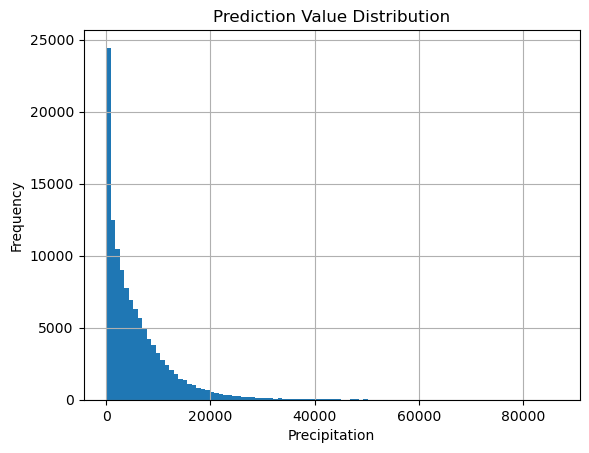

In [74]:
xvae_ds.prediction.plot.hist(bins=100)
plt.title("Prediction Value Distribution")
plt.xlabel("Precipitation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


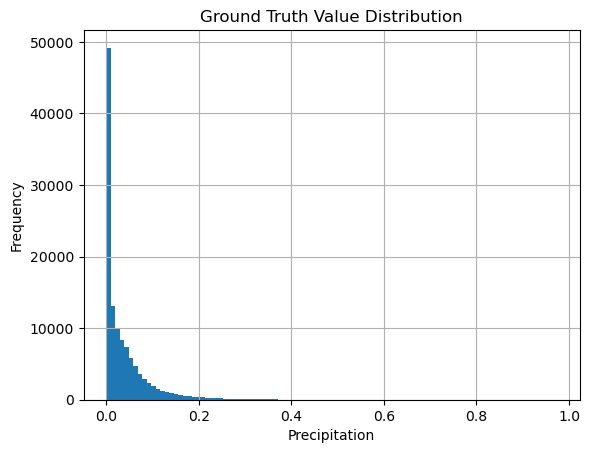

In [75]:
xvae_ds.ground_truth.plot.hist(bins=100)
plt.title("Ground Truth Value Distribution")
plt.xlabel("Precipitation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Cali: Quantile mapping

In [89]:
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

# Split into calibration (80%) and test (20%) sets along time
split_index = int(xvae_ds.sizes["time"] * 0.8)
ds_calib = xvae_ds.isel(time=slice(0, split_index))
ds_test = xvae_ds.isel(time=slice(split_index, None))

# Calibration: flatten and clean
pred_calib = ds_calib["prediction"].values.flatten()
truth_calib = ds_calib["ground_truth"].values.flatten()
mask_calib = np.isfinite(pred_calib) & np.isfinite(truth_calib)
pred_calib = pred_calib[mask_calib]
truth_calib = truth_calib[mask_calib]
pred_calib = np.clip(pred_calib, 0, np.percentile(pred_calib, 99.9))

# Quantile mapping
sorted_pred = np.sort(pred_calib)
sorted_truth = np.sort(truth_calib)
mapping_func = interp1d(sorted_pred, sorted_truth, bounds_error=False, fill_value="extrapolate")

# Apply calibration to calibration set
pred_calib_full = ds_calib["prediction"].values
pred_calib_calibrated = mapping_func(pred_calib_full)
ds_calib_result = ds_calib.copy()
ds_calib_result["prediction_calibrated"] = (("time", "lat", "lon"), pred_calib_calibrated)

# Apply calibration to test set
pred_test_full = ds_test["prediction"].values
pred_test_calibrated = mapping_func(pred_test_full)
ds_test_result = ds_test.copy()
ds_test_result["prediction_calibrated"] = (("time", "lat", "lon"), pred_test_calibrated)
ds_calib_result, ds_test_result


(<xarray.Dataset>
 Dimensions:                (time: 19, lat: 50, lon: 100)
 Coordinates:
   * time                   (time) datetime64[ns] 2022-12-01 ... 2024-06-01
   * lat                    (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
   * lon                    (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
 Data variables:
     prediction             (time, lat, lon) float32 0.3367 0.6588 ... 0.8043
     ground_truth           (time, lat, lon) float32 0.0 0.0 0.0 ... 0.005725 0.0
     prediction_calibrated  (time, lat, lon) float32 0.0 0.0 ... 8.922e-05 0.0,
 <xarray.Dataset>
 Dimensions:                (time: 5, lat: 50, lon: 100)
 Coordinates:
   * time                   (time) datetime64[ns] 2024-07-01 ... 2024-11-01
   * lat                    (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
   * lon                    (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
 Data variables:
     prediction             (time, lat, lon) float32 0.4922 0.7402 ... 0.4344

重新绘制这两个降雨的对比图以及分布图以及correlation以及R2

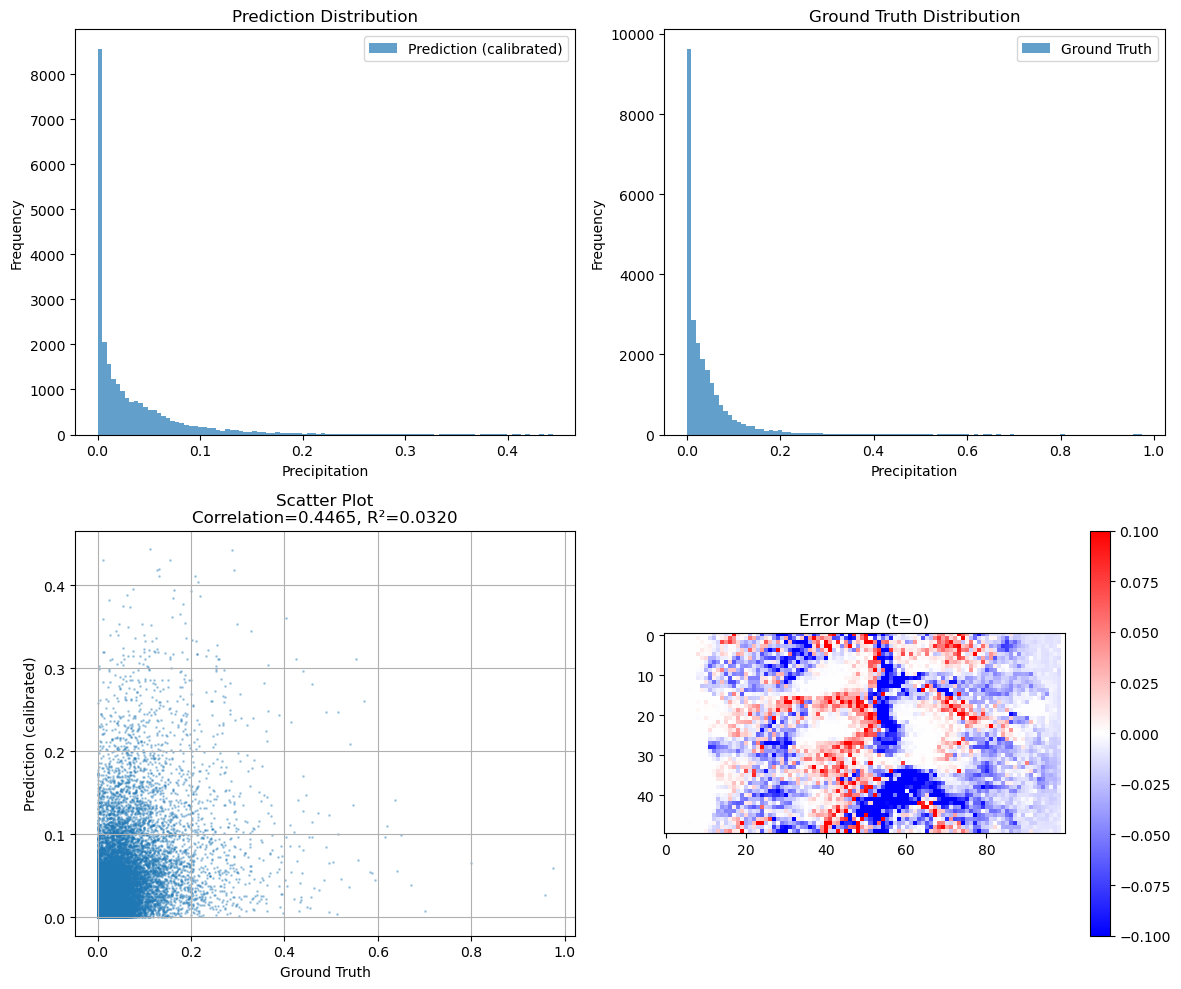

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import r2_score

# 载入数据集（来自先前的上下文）
ds_test_result

# 取出变量
pred = ds_test_result["prediction_calibrated"].values
truth = ds_test_result["ground_truth"].values

# 展平为1维以进行统计分析
pred_flat = pred.flatten()
truth_flat = truth.flatten()

# 过滤掉无效值（如nan或inf）
mask = np.isfinite(pred_flat) & np.isfinite(truth_flat)
pred_flat = pred_flat[mask]
truth_flat = truth_flat[mask]

# 计算相关性和R2
correlation = np.corrcoef(pred_flat, truth_flat)[0, 1]
r2 = r2_score(truth_flat, pred_flat)

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 分布图
axes[0, 0].hist(pred_flat, bins=100, alpha=0.7, label="Prediction (calibrated)")
axes[0, 0].set_title("Prediction Distribution")
axes[0, 0].set_xlabel("Precipitation")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()

axes[0, 1].hist(truth_flat, bins=100, alpha=0.7, label="Ground Truth")
axes[0, 1].set_title("Ground Truth Distribution")
axes[0, 1].set_xlabel("Precipitation")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()

# 散点图
axes[1, 0].scatter(truth_flat, pred_flat, alpha=0.3, s=1)
axes[1, 0].set_title(f"Scatter Plot\nCorrelation={correlation:.4f}, R²={r2:.4f}")
axes[1, 0].set_xlabel("Ground Truth")
axes[1, 0].set_ylabel("Prediction (calibrated)")
axes[1, 0].grid(True)

# 差值热图（第一个时间点的一个切片）
sample_idx = 0
truth_img = ds_test_result["ground_truth"].isel(time=sample_idx)
pred_img = ds_test_result["prediction_calibrated"].isel(time=sample_idx)
error_img = pred_img - truth_img

im = axes[1, 1].imshow(error_img, cmap="bwr", vmin=-np.nanmax(abs(error_img)), vmax=np.nanmax(abs(error_img)))
axes[1, 1].set_title(f"Error Map (t={sample_idx})")
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()


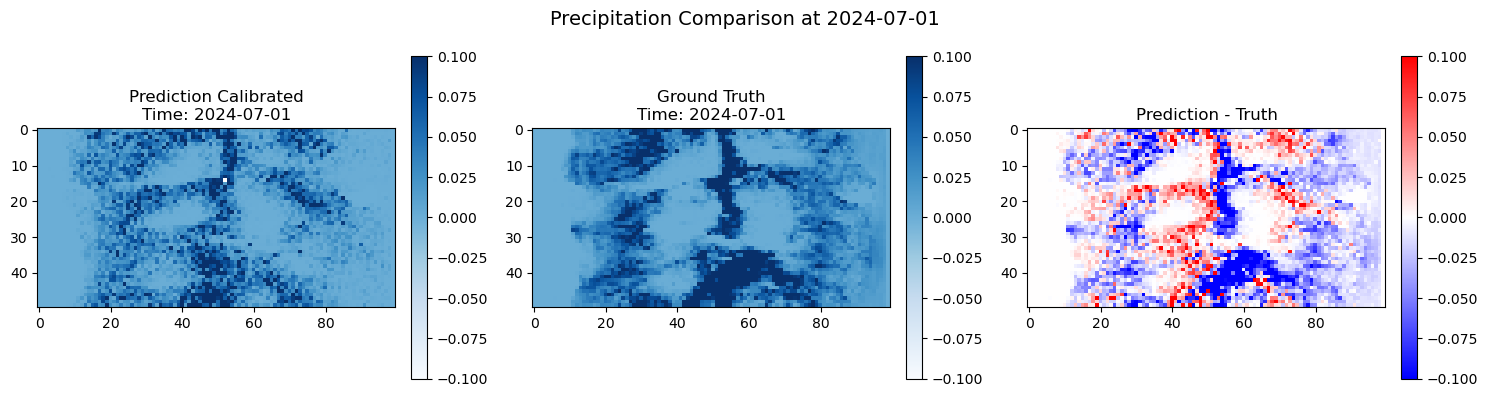

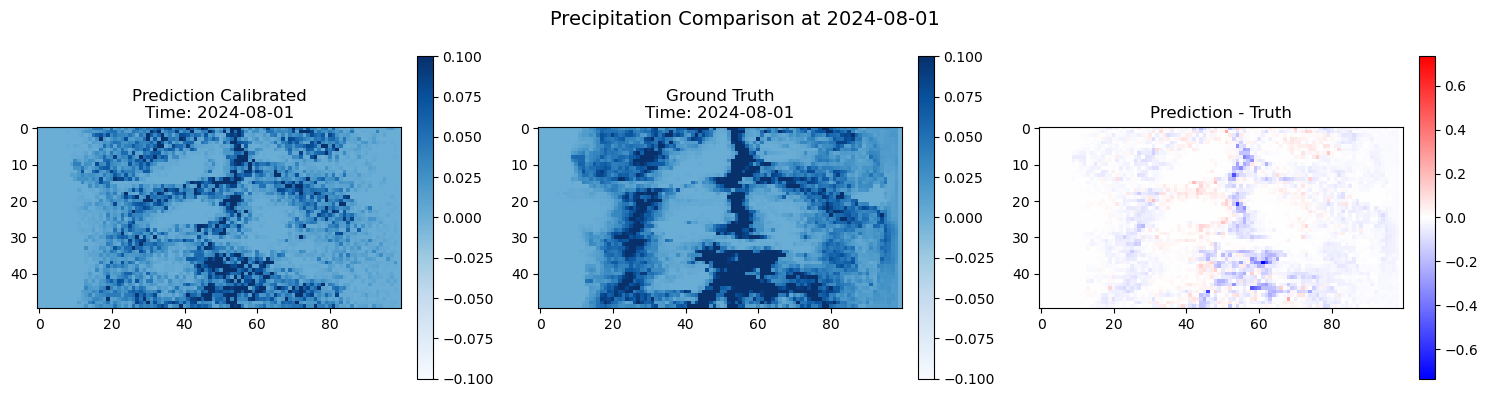

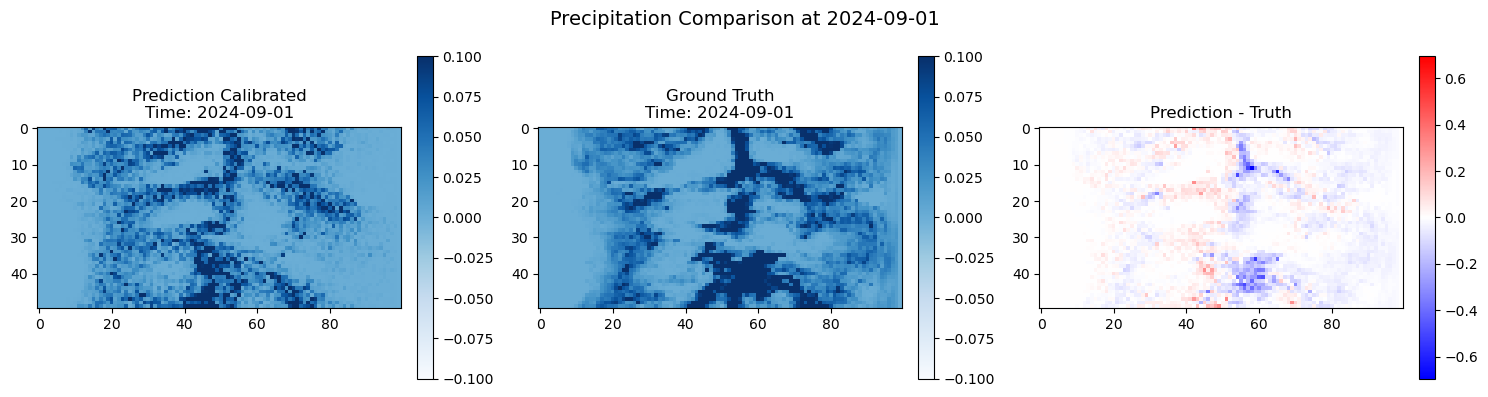

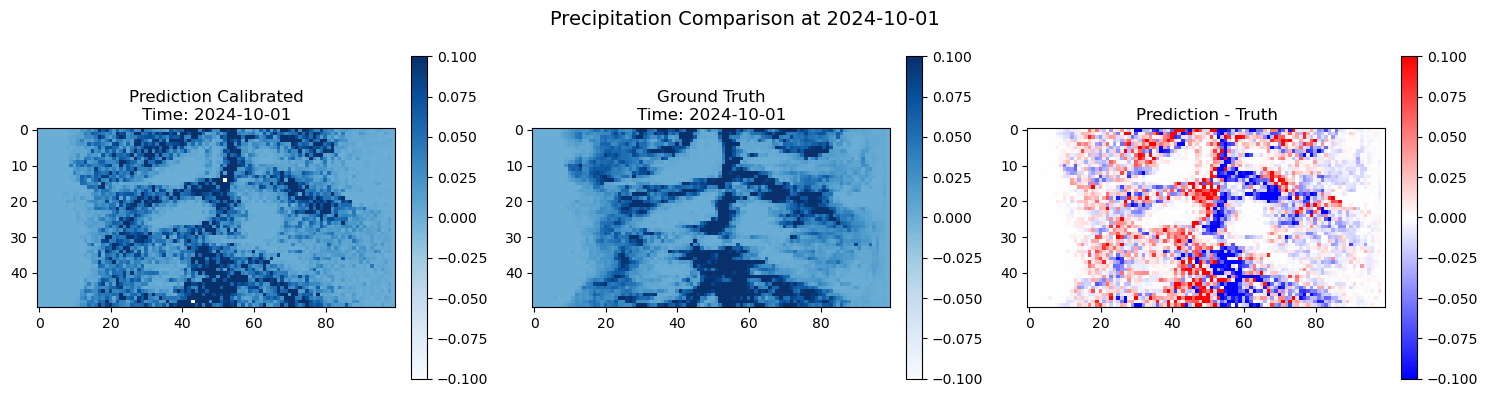

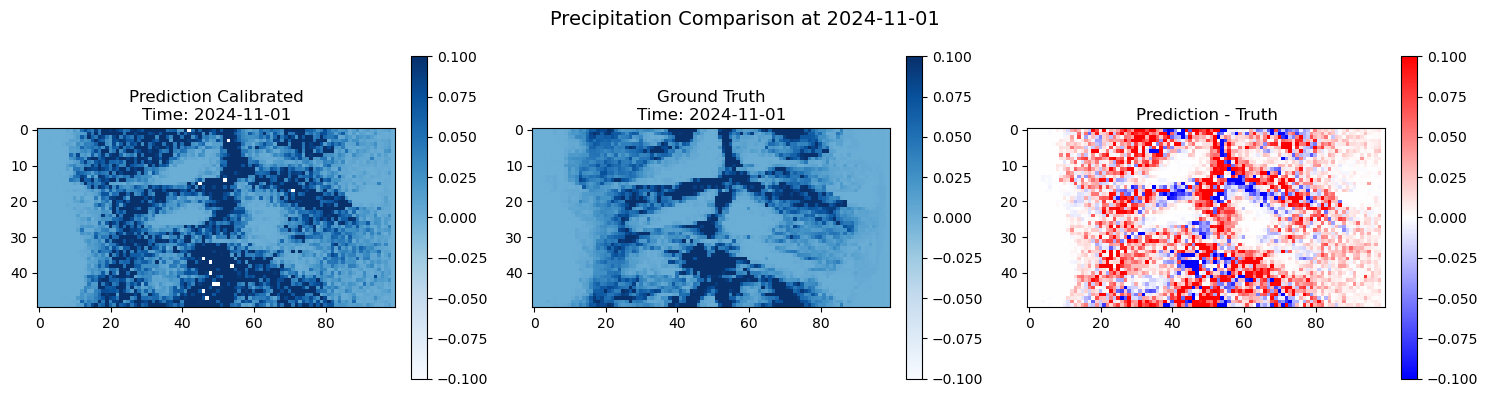

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# 统一色阶的最大值（预测和真实值中最大的）
vmax = float(
    max(ds_test_result.prediction_calibrated.max().item(),
        ds_test_result.ground_truth.max().item())
)
vmin = 0.0

# 所有时间点
times = ds_test_result.time.values
n_times = len(times)

for i in range(n_times):
    pred = ds_test_result.prediction_calibrated.isel(time=i)
    true = ds_test_result.ground_truth.isel(time=i)
    error = pred - true
    err_max = np.max(np.abs(error))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 预测图
    im0 = axes[0].imshow(pred, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Prediction Calibrated\nTime: {str(times[i])[:10]}')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 真实图
    im1 = axes[1].imshow(true, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Ground Truth\nTime: {str(times[i])[:10]}')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 误差图
    im2 = axes[2].imshow(error, cmap='bwr', vmin=-err_max, vmax=err_max)
    axes[2].set_title("Prediction - Truth")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Precipitation Comparison at {str(times[i])[:10]}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import xarray as xr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import directed_hausdorff
from skimage.metrics import structural_similarity as ssim
from scipy import ndimage
import warnings
import pandas as pd

# Assume ds_test_result is defined in memory, load and copy
ds = ds_test_result.copy()

# Extract variables
truth = ds["ground_truth"].values
pred = ds["prediction_calibrated"].values

# Flatten for global comparison metrics
truth_flat = truth.flatten()
pred_flat = pred.flatten()
mask = np.isfinite(truth_flat) & np.isfinite(pred_flat)
truth_flat = truth_flat[mask]
pred_flat = pred_flat[mask]

# Compute scalar metrics
rmse = np.sqrt(mean_squared_error(truth_flat, pred_flat))
mae = mean_absolute_error(truth_flat, pred_flat)
r2 = r2_score(truth_flat, pred_flat)
correlation = np.corrcoef(truth_flat, pred_flat)[0, 1]

# SSIM per time step (mean)
ssim_values = []
for t in range(truth.shape[0]):
    try:
        if np.std(truth[t]) == 0 or np.std(pred[t]) == 0:
            continue
        score = ssim(truth[t], pred[t], data_range=np.max(pred[t]) - np.min(pred[t]))
        if not np.isnan(score):
            ssim_values.append(score)
    except Exception as e:
        warnings.warn(f"SSIM failed at time {t}: {str(e)}")
ssim_mean = np.nanmean(ssim_values)

# Hausdorff Distance
rain_threshold = 0.0001
truth_bin = truth > rain_threshold
pred_bin = pred > rain_threshold
hausdorff_dists = []
for t in range(truth.shape[0]):
    a = np.column_stack(np.where(truth_bin[t]))
    b = np.column_stack(np.where(pred_bin[t]))
    if len(a) > 0 and len(b) > 0:
        d = max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])
        hausdorff_dists.append(d)
hausdorff_mean = np.mean(hausdorff_dists) if hausdorff_dists else np.nan

# Dice Coefficient
def dice_coef(a, b):
    intersection = np.logical_and(a, b).sum()
    return 2. * intersection / (a.sum() + b.sum() + 1e-8)

dice_scores = [dice_coef(truth_bin[t], pred_bin[t]) for t in range(truth.shape[0])]
dice_mean = np.mean(dice_scores)

# Jaccard Index
def jaccard_index(a, b):
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return intersection / (union + 1e-8)

jaccard_scores = [jaccard_index(truth_bin[t], pred_bin[t]) for t in range(truth.shape[0])]
jaccard_mean = np.mean(jaccard_scores)

# Assemble results
results = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R2", "Correlation", "SSIM (mean)", "Hausdorff (mean)", "Dice (mean)", "Jaccard (mean)"],
    "Value": [rmse, mae, r2, correlation, ssim_mean, hausdorff_mean, dice_mean, jaccard_mean]
})
results

d:\anaconda\envs\dxtorch\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\anaconda\envs\dxtorch\lib\site-packages\skimage\metrics\_structural_similarity.py:239: RuntimeWarning: invalid value encountered in subtract
  vy = cov_norm * (uyy - uy * uy)
d:\anaconda\envs\dxtorch\lib\site-packages\skimage\metrics\_structural_similarity.py:240: RuntimeWarning: invalid value encountered in subtract
  vxy = cov_norm * (uxy - ux * uy)
d:\anaconda\envs\dxtorch\lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Metric     Value
0              RMSE  0.056780
1               MAE  0.031002
2                R2  0.031995
3       Correlation  0.446478
4       SSIM (mean)  0.318928
5  Hausdorff (mean)  4.455220
6       Dice (mean)  0.953352
7    Jaccard (mean)  0.911078


## 1. Root Mean Square Error (RMSE)

**Formula**:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

**Meaning**: Measures the average squared difference between predicted and actual values. Sensitive to outliers.

**Result Analysis**:
The RMSE of **0.0568** indicates small overall prediction error. Lower RMSE is preferred.

---

## 2. Mean Absolute Error (MAE)

**Formula**:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

**Meaning**: Measures the average absolute difference between predictions and actual values. More robust to outliers than RMSE.

**Result Analysis**:
The MAE of **0.0310** shows that the model performs well with minimal average error.

---

## 3. Coefficient of Determination (R²)

**Formula**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

**Meaning**: Represents the proportion of variance explained by the model. Values close to 1 are ideal.

**Result Analysis**:
An R² of **0.032** is low, suggesting that the model explains very little of the data’s variance.

---

## 4. Pearson Correlation Coefficient

**Formula**:

$$
r = \frac{\text{Cov}(y, \hat{y})}{\sigma_y \sigma_{\hat{y}}}
$$

**Meaning**: Measures linear correlation between true and predicted values. Ranges from -1 to 1.

**Result Analysis**:
The correlation of **0.446** implies a moderate positive relationship between predictions and ground truth.

---

## 5. Structural Similarity Index (SSIM)

**Formula (simplified)**:

$$
\text{SSIM}(x, y) = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

**Meaning**: Evaluates perceived image quality based on structural similarity. Range: \[0, 1].

**Result Analysis**:
The SSIM of **0.319** indicates weak structural similarity between predicted and true images. Improvements in texture or edge detail are likely needed.

---

## 6. Hausdorff Distance (Mean)

**Definition**:

$$
d_H(A, B) = \max \left\{ \sup_{a \in A} \inf_{b \in B} \|a - b\|, \sup_{b \in B} \inf_{a \in A} \|b - a\| \right\}
$$

**Meaning**: Measures the greatest mismatch between the boundaries of predicted and ground truth objects.

**Result Analysis**:
A mean Hausdorff distance of **4.46** indicates some outlier points or misaligned boundaries. Lower values are better.

---

# Threshold = 0.0001(Rain or not)
## 7. Dice Similarity Coefficient (Mean)

**Formula**:

$$
\text{Dice} = \frac{2 |A \cap B|}{|A| + |B|}
$$

**Meaning**: Evaluates the overlap between predicted and ground truth regions. Range: \[0, 1].

**Result Analysis**:
The Dice score of **0.953** is excellent, indicating very high segmentation overlap.

---

## 8. Jaccard Index (Mean)

**Formula**:

$$
\text{Jaccard} = \frac{|A \cap B|}{|A \cup B|}
$$

**Meaning**: Another similarity measure, stricter than Dice. Also known as Intersection over Union (IoU).

**Result Analysis**:
The Jaccard index of **0.911** supports the Dice result—excellent region-level segmentation performance.

---

## Overall Summary

* **Prediction metrics (RMSE, MAE)** are low → Good numeric accuracy.
* **R² and Correlation** suggest moderate to low explanatory power → Potentially underfit or noisy data.
* **SSIM and Hausdorff** indicate structural mismatches → Spatial features may need improvement.
* **Dice and Jaccard** show excellent segmentation accuracy → Strong performance on region overlap.



In [103]:
import numpy as np
import xarray as xr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import directed_hausdorff
from skimage.metrics import structural_similarity as ssim
from scipy import ndimage
import warnings
import pandas as pd

# Assume ds_test_result is defined in memory, load and copy
ds = ds_test_result.copy()

# Extract variables
truth = ds["ground_truth"].values
pred = ds["prediction_calibrated"].values

# Flatten for global comparison metrics
truth_flat = truth.flatten()
pred_flat = pred.flatten()
mask = np.isfinite(truth_flat) & np.isfinite(pred_flat)
truth_flat = truth_flat[mask]
pred_flat = pred_flat[mask]

# Compute scalar metrics
rmse = np.sqrt(mean_squared_error(truth_flat, pred_flat))
mae = mean_absolute_error(truth_flat, pred_flat)
r2 = r2_score(truth_flat, pred_flat)
correlation = np.corrcoef(truth_flat, pred_flat)[0, 1]

# SSIM per time step (mean)
ssim_values = []
for t in range(truth.shape[0]):
    try:
        if np.std(truth[t]) == 0 or np.std(pred[t]) == 0:
            continue
        score = ssim(truth[t], pred[t], data_range=np.max(pred[t]) - np.min(pred[t]))
        if not np.isnan(score):
            ssim_values.append(score)
    except Exception as e:
        warnings.warn(f"SSIM failed at time {t}: {str(e)}")
ssim_mean = np.nanmean(ssim_values)

# Hausdorff Distance
rain_threshold = 0.05
truth_bin = truth > rain_threshold
pred_bin = pred > rain_threshold
hausdorff_dists = []
for t in range(truth.shape[0]):
    a = np.column_stack(np.where(truth_bin[t]))
    b = np.column_stack(np.where(pred_bin[t]))
    if len(a) > 0 and len(b) > 0:
        d = max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])
        hausdorff_dists.append(d)
hausdorff_mean = np.mean(hausdorff_dists) if hausdorff_dists else np.nan

# Dice Coefficient
def dice_coef(a, b):
    intersection = np.logical_and(a, b).sum()
    return 2. * intersection / (a.sum() + b.sum() + 1e-8)

dice_scores = [dice_coef(truth_bin[t], pred_bin[t]) for t in range(truth.shape[0])]
dice_mean = np.mean(dice_scores)

# Jaccard Index
def jaccard_index(a, b):
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return intersection / (union + 1e-8)

jaccard_scores = [jaccard_index(truth_bin[t], pred_bin[t]) for t in range(truth.shape[0])]
jaccard_mean = np.mean(jaccard_scores)

# Assemble results
results = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R2", "Correlation", "SSIM (mean)", "Hausdorff (mean)", "Dice (mean)", "Jaccard (mean)"],
    "Value": [rmse, mae, r2, correlation, ssim_mean, hausdorff_mean, dice_mean, jaccard_mean]
})
results

d:\anaconda\envs\dxtorch\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\anaconda\envs\dxtorch\lib\site-packages\skimage\metrics\_structural_similarity.py:239: RuntimeWarning: invalid value encountered in subtract
  vy = cov_norm * (uyy - uy * uy)
d:\anaconda\envs\dxtorch\lib\site-packages\skimage\metrics\_structural_similarity.py:240: RuntimeWarning: invalid value encountered in subtract
  vxy = cov_norm * (uxy - ux * uy)
d:\anaconda\envs\dxtorch\lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Metric      Value
0              RMSE   0.056780
1               MAE   0.031002
2                R2   0.031995
3       Correlation   0.446478
4       SSIM (mean)   0.318928
5  Hausdorff (mean)  11.247680
6       Dice (mean)   0.512893
7    Jaccard (mean)   0.349170

# Cali: Hybrid Mapping

将主分布用常规 quantile mapping 校准，将尾部分段拟合 GPD（Generalized Pareto Distribution）

In [108]:
import numpy as np
from scipy.interpolate import interp1d

def piecewise_quantile_mapping(pred_calib, truth_calib, quantile_bins=[0.0, 0.5, 0.9, 1.0]):
    # 清洗数据
    mask = np.isfinite(pred_calib) & np.isfinite(truth_calib)
    pred_calib = pred_calib[mask]
    truth_calib = truth_calib[mask]

    # 分位点边界
    pred_qs = np.quantile(pred_calib, quantile_bins)
    truth_qs = np.quantile(truth_calib, quantile_bins)

    # 构建分段函数列表
    mapping_funcs = []
    for i in range(len(quantile_bins) - 1):
        # 当前段的预测和真实值范围
        lower, upper = pred_qs[i], pred_qs[i+1]
        mask_bin = (pred_calib >= lower) & (pred_calib <= upper)

        pred_bin = pred_calib[mask_bin]
        truth_bin = truth_calib[mask_bin]

        if len(pred_bin) < 10:  # 避免空段
            pred_bin = np.array([lower, upper])
            truth_bin = np.array([lower, upper])

        sorted_pred = np.sort(pred_bin)
        sorted_truth = np.sort(truth_bin)

        f = interp1d(sorted_pred, sorted_truth, bounds_error=False, fill_value="extrapolate")
        mapping_funcs.append((lower, upper, f))

    # 整体映射函数
    def mapping(x):
        x = np.asarray(x)
        result = np.zeros_like(x)
        for lower, upper, f in mapping_funcs:
            mask = (x >= lower) & (x <= upper)
            result[mask] = f(x[mask])
        # 外部 extrapolation
        result[x < pred_qs[0]] = mapping_funcs[0][2](x[x < pred_qs[0]])
        result[x > pred_qs[-1]] = mapping_funcs[-1][2](x[x > pred_qs[-1]])
        return result

    return mapping

# 分训练/测试
split_index = int(xvae_ds.sizes["time"] * 0.8)
ds_calib = xvae_ds.isel(time=slice(0, split_index))
ds_test = xvae_ds.isel(time=slice(split_index, None))

# 拍平数据
pred_calib = ds_calib["prediction"].values.flatten()
truth_calib = ds_calib["ground_truth"].values.flatten()

# 构建分段 quantile mapping 函数
mapping_func = piecewise_quantile_mapping(pred_calib, truth_calib, quantile_bins=[0.0, 0.5, 0.9, 1.0])

# 应用到 calibration set
pred_calib_full = ds_calib["prediction"].values
pred_calib_calibrated = mapping_func(pred_calib_full)
ds_calib_result = ds_calib.copy()
ds_calib_result["prediction_calibrated"] = (("time", "lat", "lon"), pred_calib_calibrated)

# 应用到 test set
pred_test_full = ds_test["prediction"].values
pred_test_calibrated = mapping_func(pred_test_full)
ds_test_result = ds_test.copy()
ds_test_result["prediction_calibrated"] = (("time", "lat", "lon"), pred_test_calibrated)
ds_calib_result, ds_test_result


(<xarray.Dataset>
 Dimensions:                (time: 19, lat: 50, lon: 100)
 Coordinates:
   * time                   (time) datetime64[ns] 2022-12-01 ... 2024-06-01
   * lat                    (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
   * lon                    (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
 Data variables:
     prediction             (time, lat, lon) float32 0.3367 0.6588 ... 0.8043
     ground_truth           (time, lat, lon) float32 0.0 0.0 0.0 ... 0.005725 0.0
     prediction_calibrated  (time, lat, lon) float32 0.0 0.0 ... 0.0001516 0.0,
 <xarray.Dataset>
 Dimensions:                (time: 5, lat: 50, lon: 100)
 Coordinates:
   * time                   (time) datetime64[ns] 2024-07-01 ... 2024-11-01
   * lat                    (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
   * lon                    (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
 Data variables:
     prediction             (time, lat, lon) float32 0.4922 0.7402 ... 0.4344

重新绘制这两个降雨的对比图以及分布图以及correlation以及R2

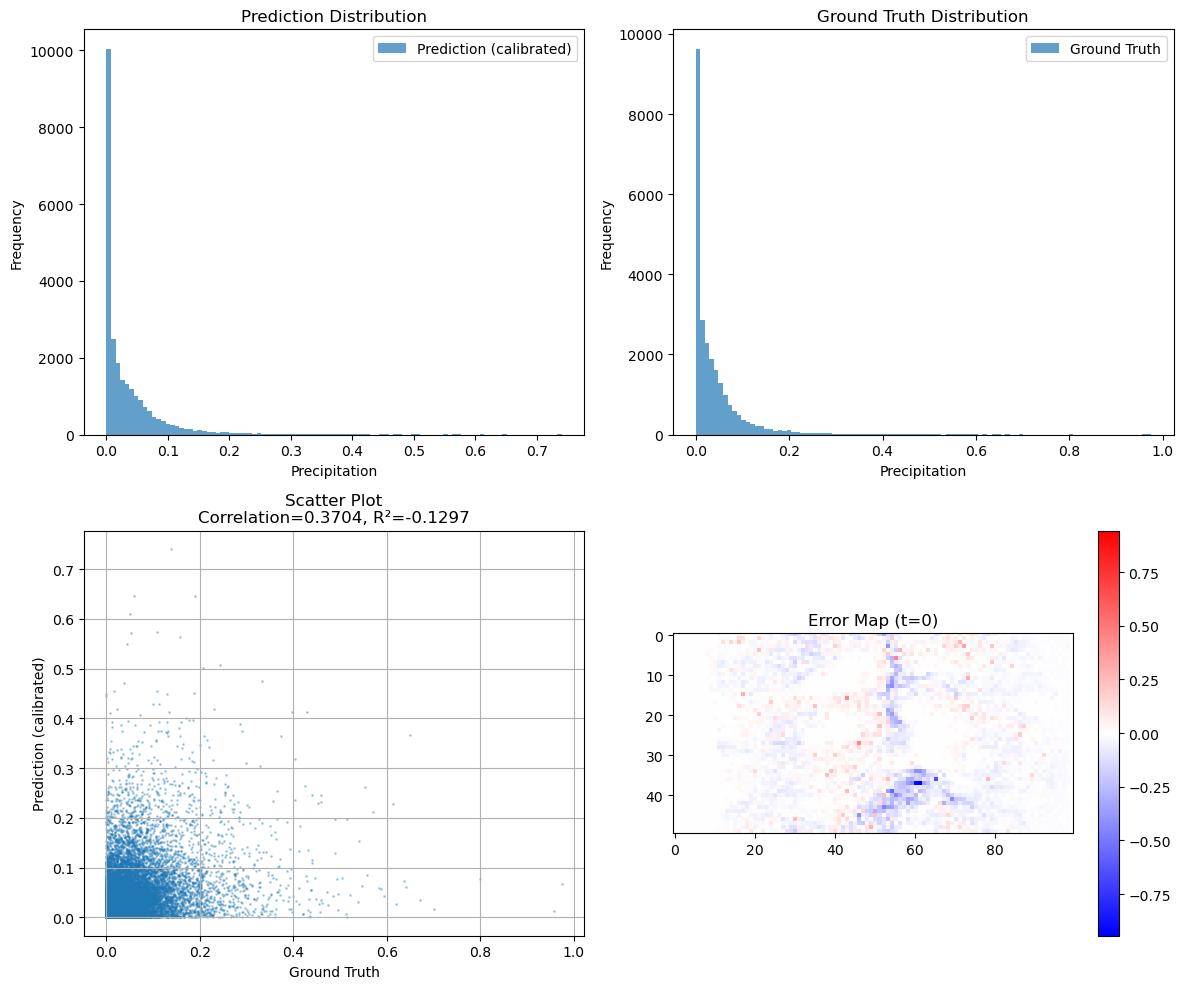

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import r2_score

# 载入数据集（来自先前的上下文）
ds_test_result

# 取出变量
pred = ds_test_result["prediction_calibrated"].values
truth = ds_test_result["ground_truth"].values

# 展平为1维以进行统计分析
pred_flat = pred.flatten()
truth_flat = truth.flatten()

# 过滤掉无效值（如nan或inf）
mask = np.isfinite(pred_flat) & np.isfinite(truth_flat)
pred_flat = pred_flat[mask]
truth_flat = truth_flat[mask]

# 计算相关性和R2
correlation = np.corrcoef(pred_flat, truth_flat)[0, 1]
r2 = r2_score(truth_flat, pred_flat)

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 分布图
axes[0, 0].hist(pred_flat, bins=100, alpha=0.7, label="Prediction (calibrated)")
axes[0, 0].set_title("Prediction Distribution")
axes[0, 0].set_xlabel("Precipitation")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()

axes[0, 1].hist(truth_flat, bins=100, alpha=0.7, label="Ground Truth")
axes[0, 1].set_title("Ground Truth Distribution")
axes[0, 1].set_xlabel("Precipitation")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()

# 散点图
axes[1, 0].scatter(truth_flat, pred_flat, alpha=0.3, s=1)
axes[1, 0].set_title(f"Scatter Plot\nCorrelation={correlation:.4f}, R²={r2:.4f}")
axes[1, 0].set_xlabel("Ground Truth")
axes[1, 0].set_ylabel("Prediction (calibrated)")
axes[1, 0].grid(True)

# 差值热图（第一个时间点的一个切片）
sample_idx = 0
truth_img = ds_test_result["ground_truth"].isel(time=sample_idx)
pred_img = ds_test_result["prediction_calibrated"].isel(time=sample_idx)
error_img = pred_img - truth_img

im = axes[1, 1].imshow(error_img, cmap="bwr", vmin=-np.nanmax(abs(error_img)), vmax=np.nanmax(abs(error_img)))
axes[1, 1].set_title(f"Error Map (t={sample_idx})")
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()


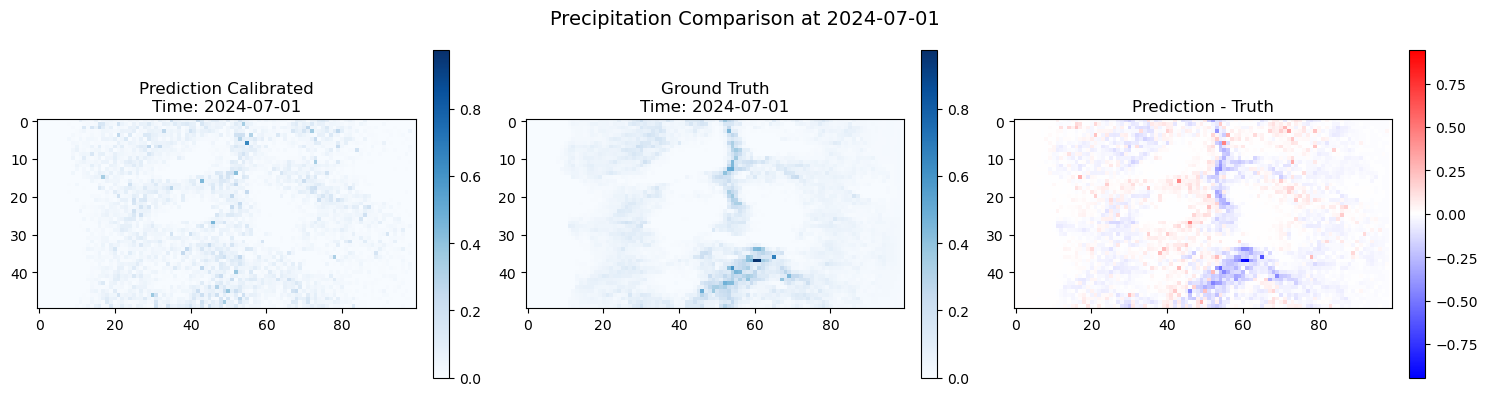

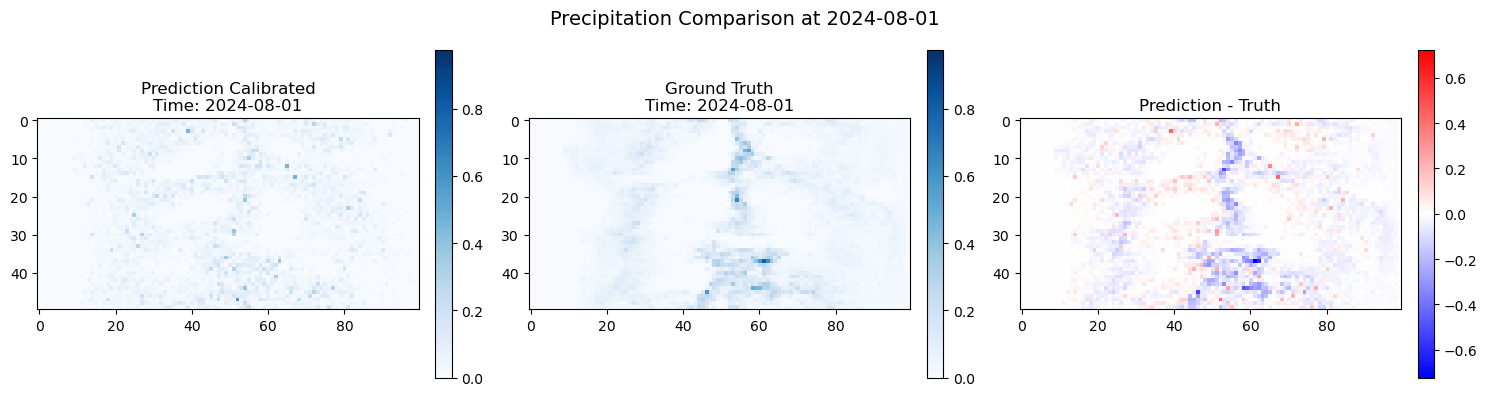

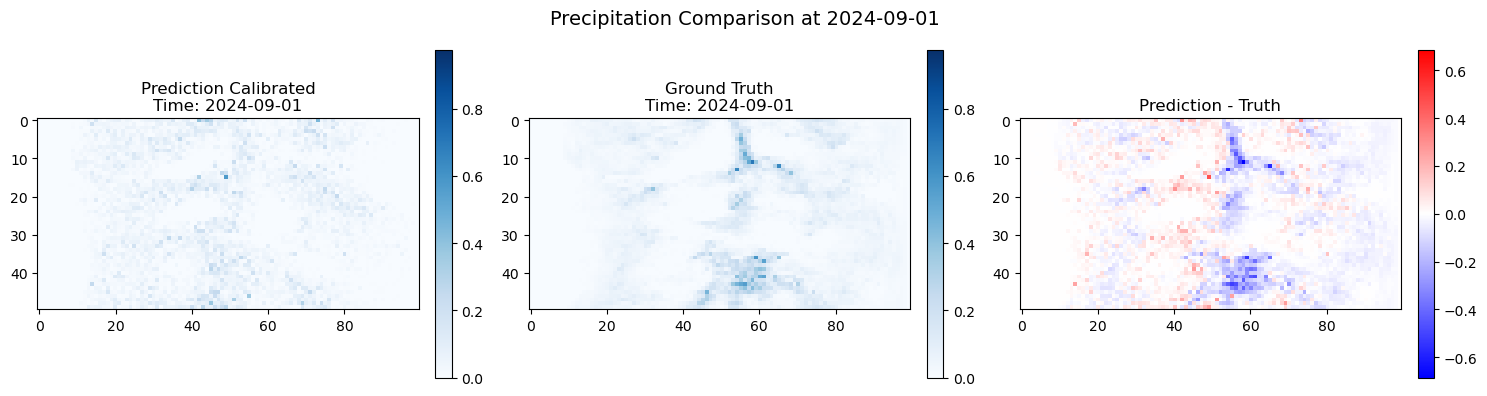

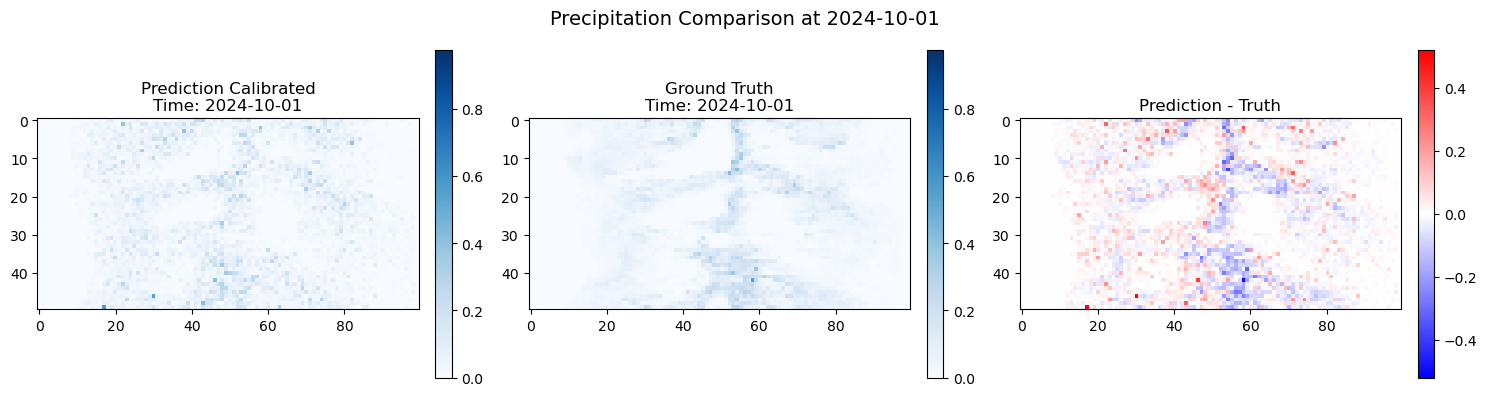

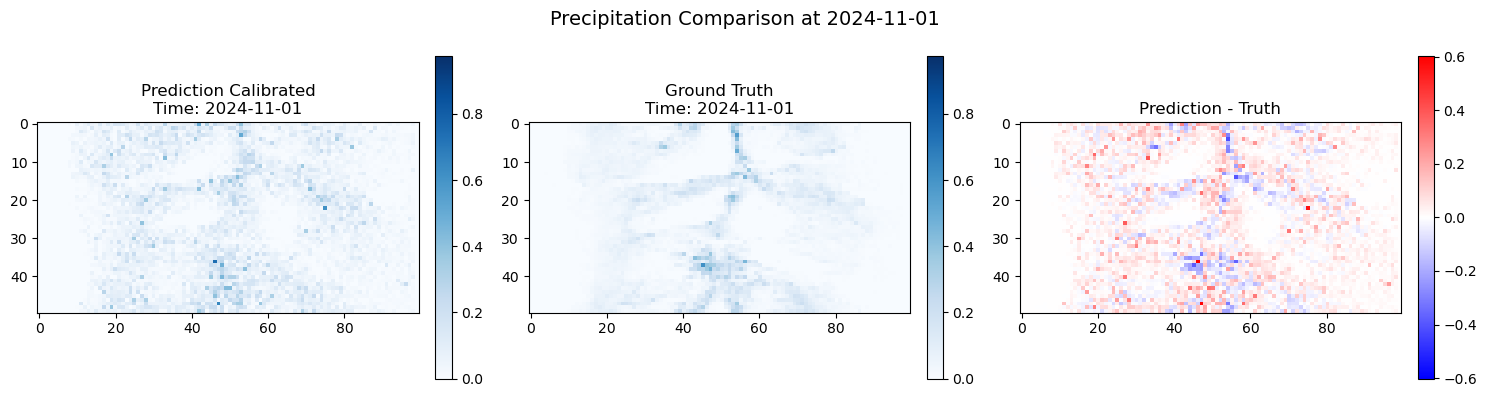

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# 统一色阶的最大值（预测和真实值中最大的）
vmax = float(
    max(ds_test_result.prediction_calibrated.max().item(),
        ds_test_result.ground_truth.max().item())
)
vmin = 0.0

# 所有时间点
times = ds_test_result.time.values
n_times = len(times)

for i in range(n_times):
    pred = ds_test_result.prediction_calibrated.isel(time=i)
    true = ds_test_result.ground_truth.isel(time=i)
    error = pred - true
    err_max = np.max(np.abs(error))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 预测图
    im0 = axes[0].imshow(pred, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Prediction Calibrated\nTime: {str(times[i])[:10]}')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 真实图
    im1 = axes[1].imshow(true, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Ground Truth\nTime: {str(times[i])[:10]}')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 误差图
    im2 = axes[2].imshow(error, cmap='bwr', vmin=-err_max, vmax=err_max)
    axes[2].set_title("Prediction - Truth")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Precipitation Comparison at {str(times[i])[:10]}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [111]:
import numpy as np
import xarray as xr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import directed_hausdorff
from skimage.metrics import structural_similarity as ssim
from scipy import ndimage
import warnings
import pandas as pd

# Assume ds_test_result is defined in memory, load and copy
ds = ds_test_result.copy()

# Extract variables
truth = ds["ground_truth"].values
pred = ds["prediction_calibrated"].values

# Flatten for global comparison metrics
truth_flat = truth.flatten()
pred_flat = pred.flatten()
mask = np.isfinite(truth_flat) & np.isfinite(pred_flat)
truth_flat = truth_flat[mask]
pred_flat = pred_flat[mask]

# Compute scalar metrics
rmse = np.sqrt(mean_squared_error(truth_flat, pred_flat))
mae = mean_absolute_error(truth_flat, pred_flat)
r2 = r2_score(truth_flat, pred_flat)
correlation = np.corrcoef(truth_flat, pred_flat)[0, 1]

# SSIM per time step (mean)
ssim_values = []
for t in range(truth.shape[0]):
    try:
        if np.std(truth[t]) == 0 or np.std(pred[t]) == 0:
            continue
        score = ssim(truth[t], pred[t], data_range=np.max(pred[t]) - np.min(pred[t]))
        if not np.isnan(score):
            ssim_values.append(score)
    except Exception as e:
        warnings.warn(f"SSIM failed at time {t}: {str(e)}")
ssim_mean = np.nanmean(ssim_values)

# Hausdorff Distance
rain_threshold = 0.0001
truth_bin = truth > rain_threshold
pred_bin = pred > rain_threshold
hausdorff_dists = []
for t in range(truth.shape[0]):
    a = np.column_stack(np.where(truth_bin[t]))
    b = np.column_stack(np.where(pred_bin[t]))
    if len(a) > 0 and len(b) > 0:
        d = max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])
        hausdorff_dists.append(d)
hausdorff_mean = np.mean(hausdorff_dists) if hausdorff_dists else np.nan

# Dice Coefficient
def dice_coef(a, b):
    intersection = np.logical_and(a, b).sum()
    return 2. * intersection / (a.sum() + b.sum() + 1e-8)

dice_scores = [dice_coef(truth_bin[t], pred_bin[t]) for t in range(truth.shape[0])]
dice_mean = np.mean(dice_scores)

# Jaccard Index
def jaccard_index(a, b):
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return intersection / (union + 1e-8)

jaccard_scores = [jaccard_index(truth_bin[t], pred_bin[t]) for t in range(truth.shape[0])]
jaccard_mean = np.mean(jaccard_scores)

# Assemble results
results = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R2", "Correlation", "SSIM (mean)", "Hausdorff (mean)", "Dice (mean)", "Jaccard (mean)"],
    "Value": [rmse, mae, r2, correlation, ssim_mean, hausdorff_mean, dice_mean, jaccard_mean]
})
results

Metric     Value
0              RMSE  0.061530
1               MAE  0.033935
2                R2 -0.129727
3       Correlation  0.370386
4       SSIM (mean)  0.329861
5  Hausdorff (mean)  4.046671
6       Dice (mean)  0.952340
7    Jaccard (mean)  0.909200

潜在分布假设	方法	适用场景
高斯混合	Mixture of Gaussians VAE (MoG-VAE)	多模态潜空间
轻尾分布	Student-t VAE / Laplace VAE	抗异常、鲁棒学习
非参数分布	Normalizing Flows / VampPrior / VAEAC	高级建模能力、灵活边界
🧠 结论
你的当前实现中，latent space 是显式服从标准正态分布，这是最常见的 VAE 设置。如果你想建模更加灵活或稀疏的潜在空间（比如用于极端降水建模），可以考虑：

更换 prior 分布；

使用 flow-based VAE；

或 max-infinitely divisible VAE（比如你之前提到的 xVAE 结构）。